In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, ExpSineSquared, RBF, RationalQuadratic
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage import median_filter
import time
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
#sns.set_style("whitegrid")
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [5]:
df_source = pd.read_csv('../data/20221106.csv')
df_source = df_source[df_source['symbol'].str.contains("BTC_USD")]
df_source = df_source[(np.abs(stats.zscore(df_source.select_dtypes(include=np.number))) < 3).all(axis=1)]

In [6]:
#t = np.arange(len(df))
#df['t'] = pd.DataFrame({'t' : t})

print('OK - data loaded successfully')

n = 100000

df = df_source.iloc[:n, :]
df

OK - data loaded successfully


,id,symbol,sequence,ask_price,ask_size,bid_price,bid_size,time_coinapi,time_exchange,ts
4,53f656c3-7eef-4481-b1d6-fb4a8bfac980,BINANCEUS_SPOT_BTC_USD,1712700.0,21300.26,0.270019,21295.95,0.060000,2022-11-05 23:59:59.998364,2022-11-05 23:59:59.998364,2022-11-06 00:00:00.071445
6,53350a7c-77cd-43ce-810e-6a8a009068af,BINANCEUS_SPOT_BTC_USD,1712701.0,21300.08,0.195000,21295.95,0.060000,2022-11-06 00:00:00.01175,2022-11-06 00:00:00.01175,2022-11-06 00:00:00.087446
7,2316be78-6fed-49a4-b182-c49769f95fda,FTX_SPOT_BTC_USD,1670120.0,21303.00,19.018100,21302.00,2.801700,2022-11-06 00:00:00.033136,2022-11-06 00:00:00.032462,2022-11-06 00:00:00.087665
12,5044d46f-2d63-406e-a147-bba3273af29f,BEQUANT_SPOT_BTC_USD_5A882C,760091.0,21313.46,0.162520,21290.56,0.153700,2022-11-06 00:00:00.065215,2022-11-06 00:00:00.065215,2022-11-06 00:00:00.136056
13,31d61830-0351-49cd-8304-50e73f12d9d6,BINANCEUS_SPOT_BTC_USD,1712702.0,21300.08,0.195000,21295.96,0.017000,2022-11-06 00:00:00.073366,2022-11-06 00:00:00.073366,2022-11-06 00:00:00.136281
...,...,...,...,...,...,...,...,...,...,...
167120,20aeb53e-42a9-4e09-93b2-ab5b82f3f513,KRAKEN_SPOT_BTC_USDT,910645.0,21313.40,0.020000,21312.30,1.030416,2022-11-06 00:25:00.778868,2022-11-06 00:25:00.778868,2022-11-06 00:25:00.799906
167121,ee0abc91-831c-4437-a385-583edb3078fc,KRAKEN_SPOT_BTC_USD,1224548.0,21316.10,2.214985,21316.00,0.012570,2022-11-06 00:25:00.78243,2022-11-06 00:25:00.78243,2022-11-06 00:25:00.804524
167122,83017a54-d6d2-4d55-8aec-a1647b75b352,COINBASE_SPOT_BTC_USDT,2164608.0,21314.26,1.050000,21308.20,0.023224,2022-11-06 00:25:00.786275,2022-11-06 00:25:00.729433,2022-11-06 00:25:00.817967
167123,de93b968-c5b9-47cd-ae95-4e9dd6022de7,KRAKEN_SPOT_BTC_USD,1224549.0,21316.10,2.464985,21316.00,0.012570,2022-11-06 00:25:00.80777,2022-11-06 00:25:00.80777,2022-11-06 00:25:00.834004


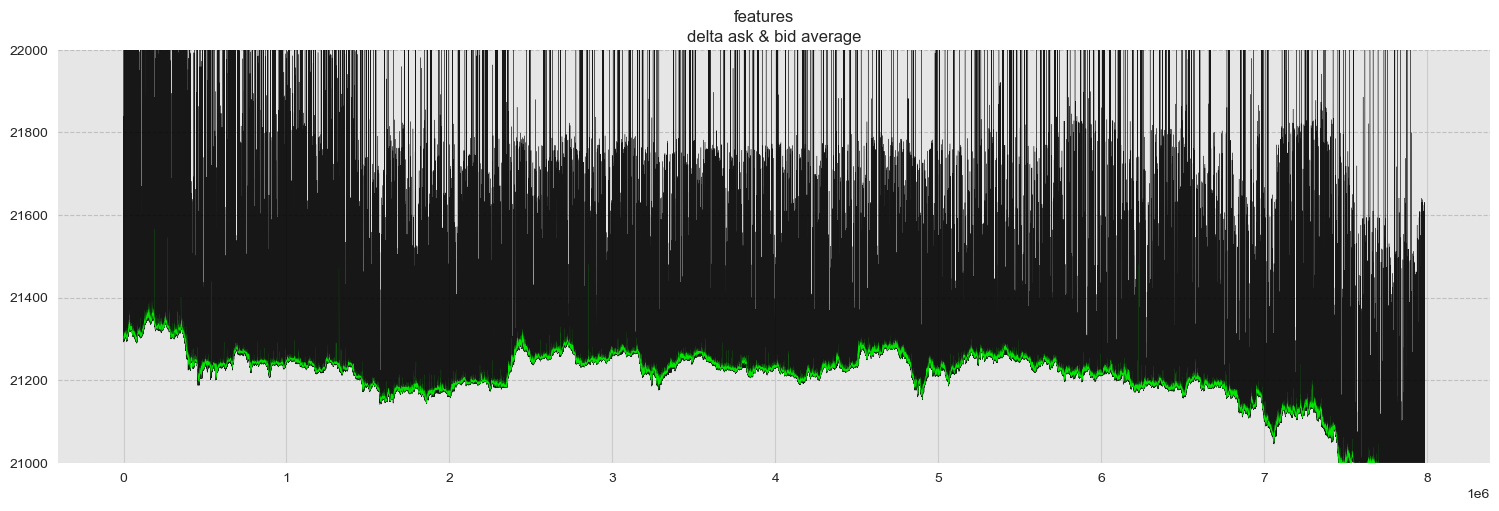

In [8]:
x = df_source.copy()
x.ask_price = median_filter(df_source.ask_price, size=5)
x.bid_price = median_filter(df_source.bid_price, size=5)

fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('features')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('delta ask & bid average')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, df_source.shape[0]), df_source.ask_price, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, x.shape[0]), x.ask_price, '-', color="lime", alpha=0.9, linewidth=0.05)
# sp1.plot(np.arange(0, df.shape[0]), df.bid_price, '-', color="black", alpha=0.9, linewidth=0.25)
# sp1.plot(np.arange(0, x.shape[0]), x.bid_price, '-', color="orange", alpha=0.9, linewidth=0.05)

plt.ylim([21000, 22000])
plt.show()

In [7]:

df['time_coinapi'] = pd.to_datetime(df['time_coinapi'])
#df = df.set_index('time_coinapi')
#df = df.resample('1.0S').mean()
#df.fillna(method="ffill", inplace=True)
#df.fillna(method="bfill", inplace=True)
#df.fillna(0, inplace=True)
df

/var/folders/y9/pj73b0qj1ldbz0rrclnfjhjh0000gn/T/ipykernel_74243/1647248782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_coinapi'] = pd.to_datetime(df['time_coinapi'])


,id,symbol,sequence,ask_price,ask_size,bid_price,bid_size,time_coinapi,time_exchange,ts
4,53f656c3-7eef-4481-b1d6-fb4a8bfac980,BINANCEUS_SPOT_BTC_USD,1712700.0,21300.26,0.270019,21295.95,0.060000,2022-11-05 23:59:59.998364,2022-11-05 23:59:59.998364,2022-11-06 00:00:00.071445
6,53350a7c-77cd-43ce-810e-6a8a009068af,BINANCEUS_SPOT_BTC_USD,1712701.0,21300.08,0.195000,21295.95,0.060000,2022-11-06 00:00:00.011750,2022-11-06 00:00:00.01175,2022-11-06 00:00:00.087446
7,2316be78-6fed-49a4-b182-c49769f95fda,FTX_SPOT_BTC_USD,1670120.0,21303.00,19.018100,21302.00,2.801700,2022-11-06 00:00:00.033136,2022-11-06 00:00:00.032462,2022-11-06 00:00:00.087665
12,5044d46f-2d63-406e-a147-bba3273af29f,BEQUANT_SPOT_BTC_USD_5A882C,760091.0,21313.46,0.162520,21290.56,0.153700,2022-11-06 00:00:00.065215,2022-11-06 00:00:00.065215,2022-11-06 00:00:00.136056
13,31d61830-0351-49cd-8304-50e73f12d9d6,BINANCEUS_SPOT_BTC_USD,1712702.0,21300.08,0.195000,21295.96,0.017000,2022-11-06 00:00:00.073366,2022-11-06 00:00:00.073366,2022-11-06 00:00:00.136281
...,...,...,...,...,...,...,...,...,...,...
167120,20aeb53e-42a9-4e09-93b2-ab5b82f3f513,KRAKEN_SPOT_BTC_USDT,910645.0,21313.40,0.020000,21312.30,1.030416,2022-11-06 00:25:00.778868,2022-11-06 00:25:00.778868,2022-11-06 00:25:00.799906
167121,ee0abc91-831c-4437-a385-583edb3078fc,KRAKEN_SPOT_BTC_USD,1224548.0,21316.10,2.214985,21316.00,0.012570,2022-11-06 00:25:00.782430,2022-11-06 00:25:00.78243,2022-11-06 00:25:00.804524
167122,83017a54-d6d2-4d55-8aec-a1647b75b352,COINBASE_SPOT_BTC_USDT,2164608.0,21314.26,1.050000,21308.20,0.023224,2022-11-06 00:25:00.786275,2022-11-06 00:25:00.729433,2022-11-06 00:25:00.817967
167123,de93b968-c5b9-47cd-ae95-4e9dd6022de7,KRAKEN_SPOT_BTC_USD,1224549.0,21316.10,2.464985,21316.00,0.012570,2022-11-06 00:25:00.807770,2022-11-06 00:25:00.80777,2022-11-06 00:25:00.834004


In [8]:
#df['time_coinapi'] = pd.to_datetime(df['time_coinapi'])
#df['time_coinapi'] = pd.to_datetime(df.index)
df['ts'] = df['time_coinapi'].values.astype(np.int64) // 10 ** 9
#df = df.sort_values('ts', ascending=True).drop_duplicates('ts').sort_index()
df = df.drop(columns=['time_exchange', 'id', 'symbol', 'sequence',])
#df = df.drop(columns=['sequence', 'time_coinapi'])
n = 500
df = df[:n]
df = df.reset_index()
t = np.arange(len(df))
df['t'] = pd.DataFrame({'t' : t})
df

/var/folders/y9/pj73b0qj1ldbz0rrclnfjhjh0000gn/T/ipykernel_74243/1340929866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ts'] = df['time_coinapi'].values.astype(np.int64) // 10 ** 9


,index,ask_price,ask_size,bid_price,bid_size,time_coinapi,ts,t
0,4,21300.26,0.270019,21295.95,0.0600,2022-11-05 23:59:59.998364,1667692799,0
1,6,21300.08,0.195000,21295.95,0.0600,2022-11-06 00:00:00.011750,1667692800,1
2,7,21303.00,19.018100,21302.00,2.8017,2022-11-06 00:00:00.033136,1667692800,2
3,12,21313.46,0.162520,21290.56,0.1537,2022-11-06 00:00:00.065215,1667692800,3
4,13,21300.08,0.195000,21295.96,0.0170,2022-11-06 00:00:00.073366,1667692800,4
...,...,...,...,...,...,...,...,...
495,776,21302.00,0.110000,21300.00,0.2200,2022-11-06 00:00:06.912619,1667692806,495
496,777,21303.00,8.362000,21302.00,3.0355,2022-11-06 00:00:06.921382,1667692806,496
497,779,21300.00,1.100300,21298.00,0.5500,2022-11-06 00:00:06.937391,1667692806,497
498,780,21301.40,3.520907,21299.70,0.1000,2022-11-06 00:00:06.940954,1667692806,498


In [9]:
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 1.5**2))

k1 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=0.01, periodicity=1, periodicity_bounds=(1e-3, 45))

k2 = ConstantKernel(constant_value=0.1, constant_value_bounds=(1e-2, 500)) * \
  RationalQuadratic(length_scale=0.01, length_scale_bounds=(0.01, 1e8), alpha= 15.0, alpha_bounds=(1, 1e3))

k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=0.01, periodicity=10, periodicity_bounds=(1, 15))

kernel_4  = k0 + k1 + k2 + k3

In [10]:
# Define GaussianProcessRegressor object.
gp4 = GaussianProcessRegressor(
    kernel=kernel_4,
    n_restarts_optimizer=10,
    normalize_y=True,
    alpha=0.0
)

df['delta'] = 10000 * (df['ask_price'].shift(-1) / df['ask_price'] - 1)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)
#df = df.drop(columns=['ask_price', 'ask_size', 'bid_price', 'bid_size'])

# train the normalization
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = scaler.fit(df)
#print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
#normalized = scaler.transform(df)

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(df)
# names = df.columns
# data_scaled = pd.DataFrame(data_scaled, columns=names)
# data_scaled

X = df['t'].values.reshape(n, 1)
y = df['delta'].values.reshape(n, 1)

prop_train = 0.8
n_train = round(prop_train * n)

X_train = X[:n_train]
X_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
df

,index,ask_price,ask_size,bid_price,bid_size,time_coinapi,ts,t,delta
0,4,21300.26,0.270019,21295.95,0.0600,2022-11-05 23:59:59.998364,1667692799,0,-0.084506
1,6,21300.08,0.195000,21295.95,0.0600,2022-11-06 00:00:00.011750,1667692800,1,1.370887
2,7,21303.00,19.018100,21302.00,2.8017,2022-11-06 00:00:00.033136,1667692800,2,4.910107
3,12,21313.46,0.162520,21290.56,0.1537,2022-11-06 00:00:00.065215,1667692800,3,-6.277723
4,13,21300.08,0.195000,21295.96,0.0170,2022-11-06 00:00:00.073366,1667692800,4,-0.004695
...,...,...,...,...,...,...,...,...,...
495,776,21302.00,0.110000,21300.00,0.2200,2022-11-06 00:00:06.912619,1667692806,495,0.469439
496,777,21303.00,8.362000,21302.00,3.0355,2022-11-06 00:00:06.921382,1667692806,496,-1.408252
497,779,21300.00,1.100300,21298.00,0.5500,2022-11-06 00:00:06.937391,1667692806,497,0.657277
498,780,21301.40,3.520907,21299.70,0.1000,2022-11-06 00:00:06.940954,1667692806,498,0.000000


400


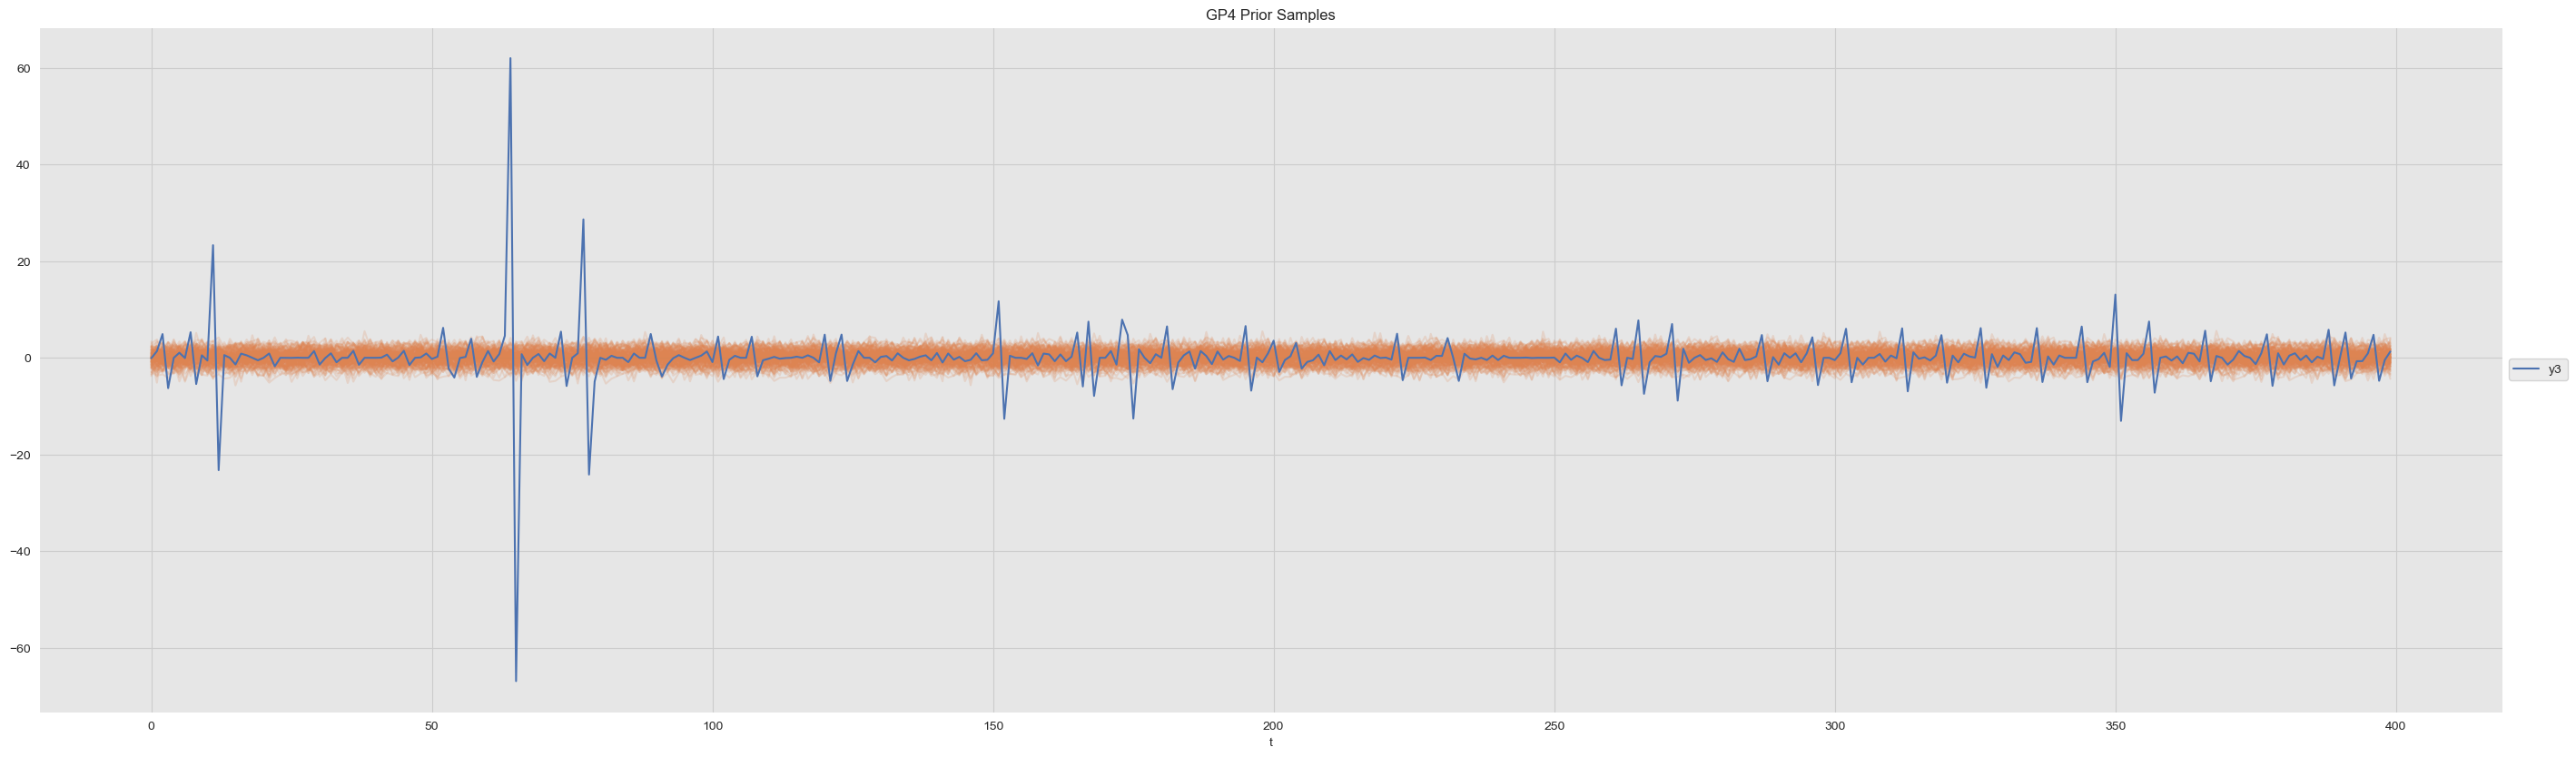

In [11]:
gp4_prior_samples = gp4.sample_y(X=X_train, n_samples=150)

print(len(X_train))

fig, ax = plt.subplots(figsize=(35,10))
for i in range(150):
    sns.lineplot(x=X_train[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y3', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP4 Prior Samples', xlabel='t');

In [9]:
gp4.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.5**2) + 1.41**2 * ExpSineSquared(length_scale=0.001, periodicity=1) + 1**2 * RationalQuadratic(alpha=5, length_scale=0.001) + 1**2 * ExpSineSquared(length_scale=0.001, periodicity=1),
                         n_restarts_optimizer=10, normalize_y=True)
y_pred, y_std = gp4.predict(X, return_std=True)

df['y_pred'] = y_pred
df['y_std'] = y_std
df['y_pred_lwr'] = df['y_pred'] - 2*df['y_std']
df['y_pred_upr'] = df['y_pred'] + 2*df['y_std']
#df.loc[155:, :]
df

/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,index,ask_price,ask_size,bid_price,bid_size,time_coinapi,ts,t,delta,y_pred,y_std,y_pred_lwr,y_pred_upr
0,4,21300.26,0.270019,21295.95,0.0600,2022-11-05 23:59:59.998364,1667692799,0,-0.084506,-0.059187,1.496531,-3.052249,2.933875
1,6,21300.08,0.195000,21295.95,0.0600,2022-11-06 00:00:00.011750,1667692800,1,1.370887,1.498086,1.496531,-1.494976,4.491148
2,7,21303.00,19.018100,21302.00,2.8017,2022-11-06 00:00:00.033136,1667692800,2,4.910107,4.503677,1.496531,1.510615,7.496739
3,12,21313.46,0.162520,21290.56,0.1537,2022-11-06 00:00:00.065215,1667692800,3,-6.277723,-5.991099,1.496531,-8.984161,-2.998037
4,13,21300.08,0.195000,21295.96,0.0170,2022-11-06 00:00:00.073366,1667692800,4,-0.004695,0.002736,1.496531,-2.990326,2.995798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,776,21302.00,0.110000,21300.00,0.2200,2022-11-06 00:00:06.912619,1667692806,495,0.469439,0.548171,5.012216,-9.476262,10.572603
496,777,21303.00,8.362000,21302.00,3.0355,2022-11-06 00:00:06.921382,1667692806,496,-1.408252,-0.543953,5.012216,-10.568386,9.480480
497,779,21300.00,1.100300,21298.00,0.5500,2022-11-06 00:00:06.937391,1667692806,497,0.657277,0.496162,5.012216,-9.528270,10.520595
498,780,21301.40,3.520907,21299.70,0.1000,2022-11-06 00:00:06.940954,1667692806,498,0.000000,-0.205933,5.012216,-10.230366,9.818499


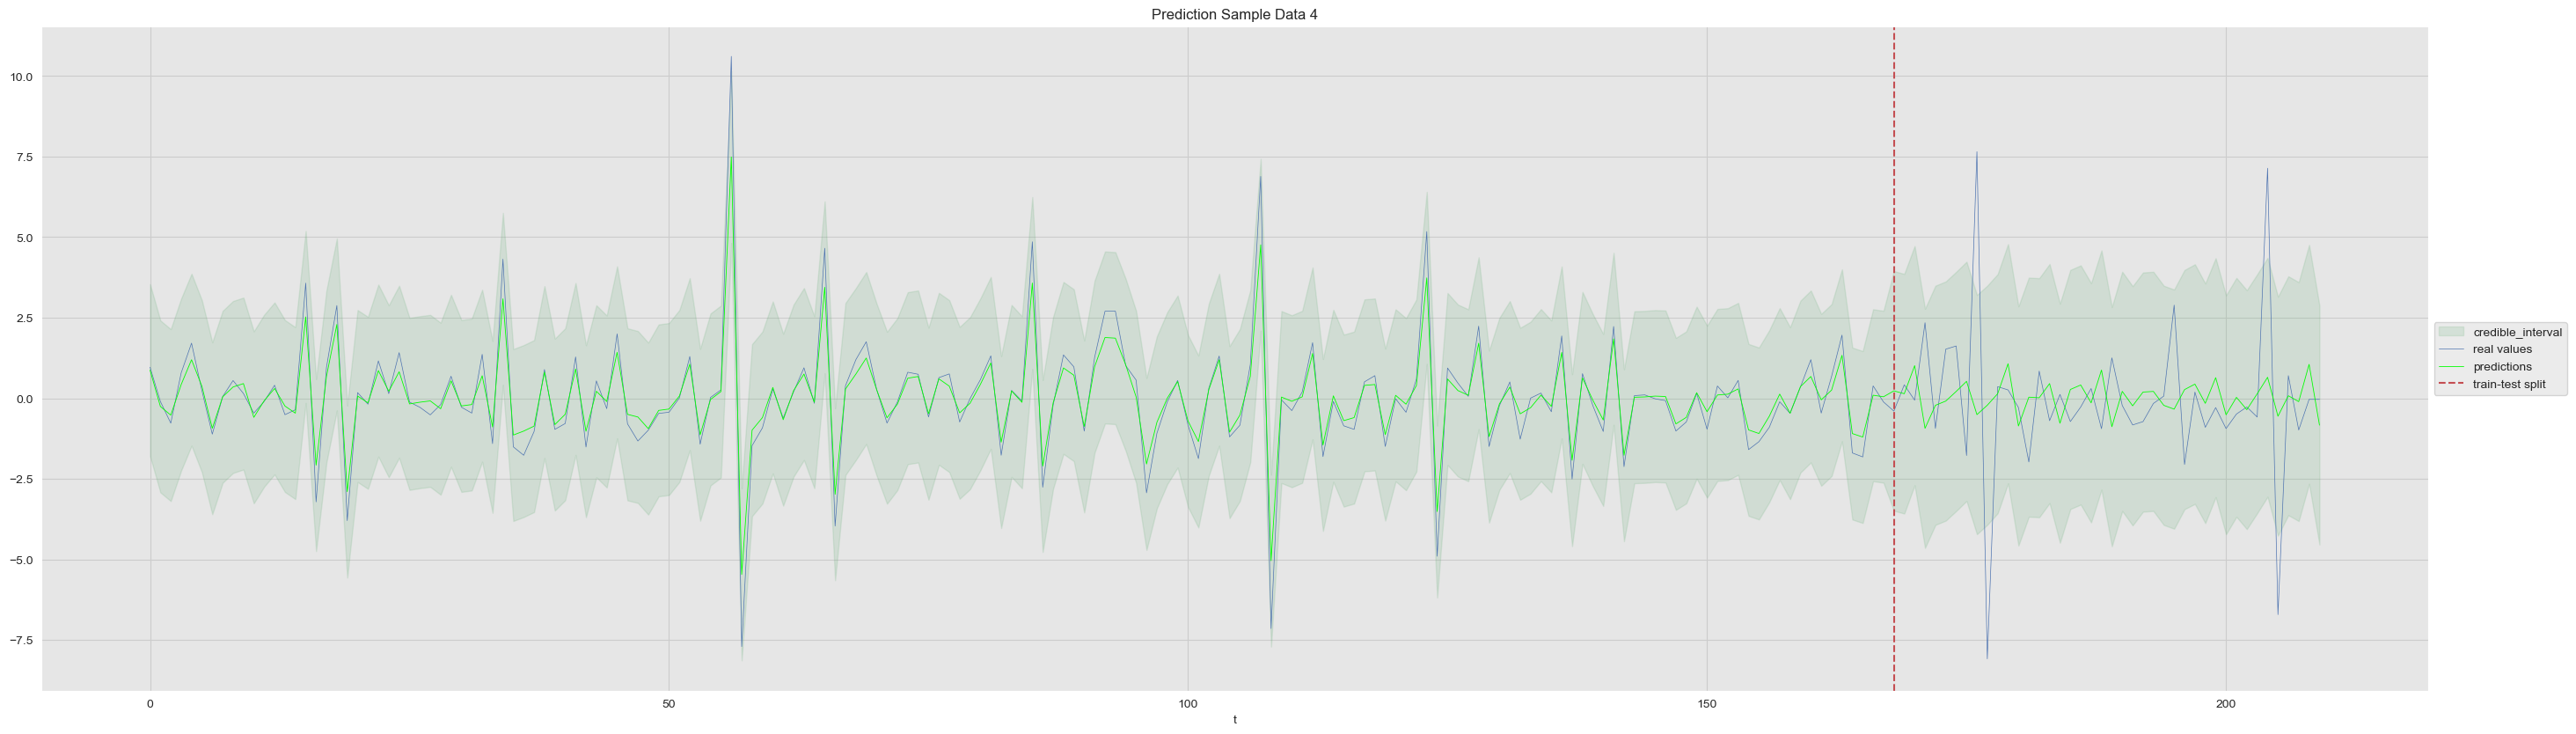

In [96]:
fig, ax = plt.subplots(figsize=(35,10))

ax.fill_between(
    x=df['t'],
    y1=df['y_pred_lwr'],
    y2=df['y_pred_upr'],
    color=sns_c[2],
    alpha=0.15,
    label='credible_interval'
)
#plt.style.use('Solarize_Light2')
sns.lineplot(x='t', y='delta', data=df, color=sns_c[0], label = 'real values', ax=ax, linewidth=0.5)
sns.lineplot(x='t', y='y_pred', data=df, color='lime', label='predictions', ax=ax, linewidth=0.6)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');
#df
#plt.savefig('prediction_sample.png', dpi=1200)

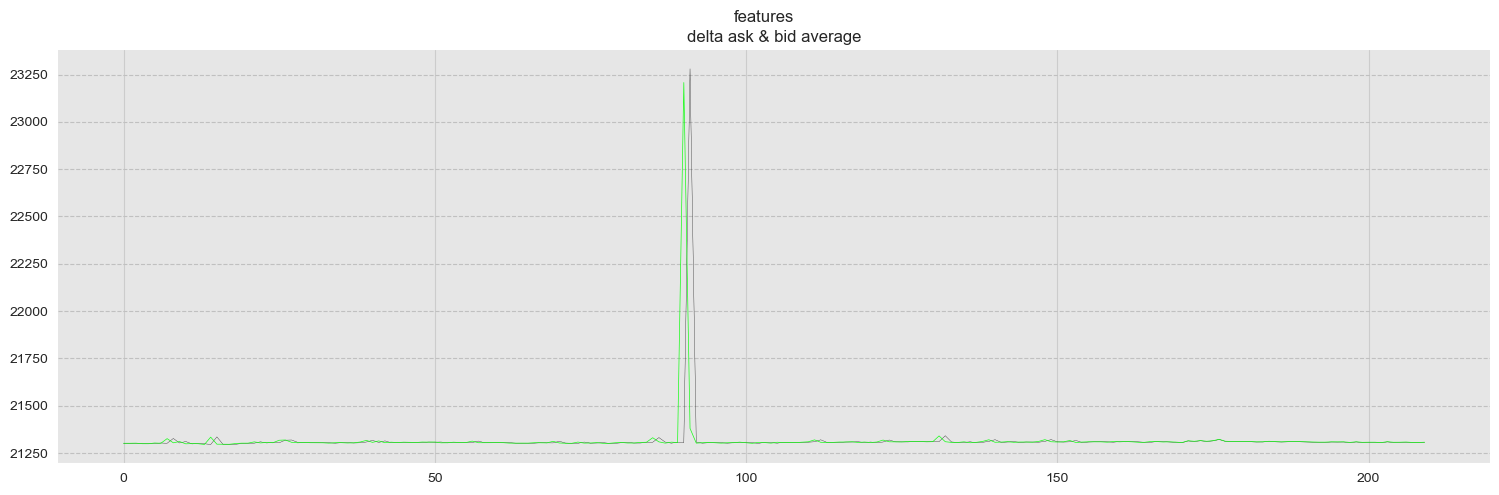

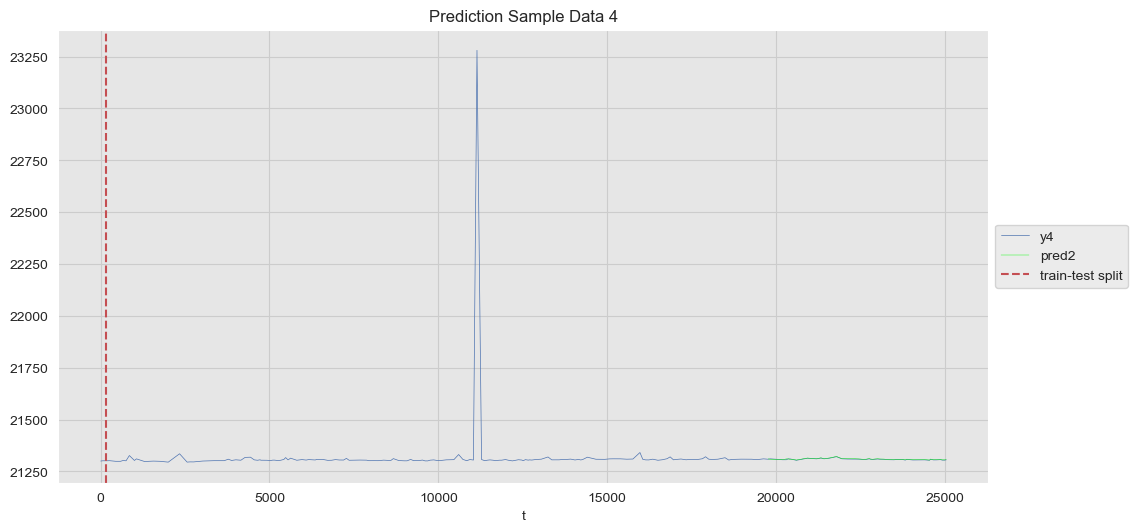

,ask_price,ask_size,bid_price,bid_size,ts,t,delta,y_pred,y_std,y_pred_lwr,y_pred_upr,pred2
18687,21308.00,6.110000,21307.00,0.440100,1667692954,18687,0.610099,1.000061,26.052663,-51.499631,52.711021,21309.290615
18964,21309.30,0.051835,21305.80,0.843866,1667692955,18964,-0.140784,0.999988,26.052663,-52.222914,51.987739,21309.049430
19169,21309.00,0.220000,21307.00,2.667100,1667692956,19169,0.000000,1.000002,26.052663,-52.087305,52.123348,21309.038402
19278,21309.00,0.220000,21307.00,2.667100,1667692957,19278,-0.938571,0.999911,26.052663,-52.991376,51.219277,21307.111917
19432,21307.00,0.020000,21302.20,0.020000,1667692958,19432,1.783451,1.000174,26.052663,-50.369409,53.841244,21310.698719
19625,21310.80,0.000219,21305.80,0.100000,1667692959,19625,-0.858720,0.999919,26.052663,-52.914460,51.296193,21309.075672
19766,21308.97,0.140501,21300.26,0.042500,1667692960,19766,0.858793,1.000085,26.052663,-51.260079,52.950574,21310.771135
19830,21310.80,0.052057,21305.80,0.193867,1667692961,19830,-0.844642,0.999920,26.052663,-52.900900,51.309753,21309.104569
19994,21309.00,0.220000,21307.00,2.975200,1667692962,19994,-1.159135,0.999890,26.052663,-53.203832,51.006821,21306.659194
20189,21306.53,0.000505,21302.77,0.039000,1667692963,20189,0.000000,1.000002,26.052663,-52.087305,52.123348,21306.568397


In [30]:
df['y_pred'] = df['y_pred'] / 10000 + 1
df['pred2'] = df['y_pred'] * df['ask_price']

#print(df)

fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('features')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('delta ask & bid average')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, df.shape[0]), df.ask_price, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, df.shape[0]), df.pred2, '-', color="lime", alpha=0.9, linewidth=0.5)

plt.show()

fig, ax = plt.subplots()

# ax.fill_between(
#     x=df['t'],
#     y1=df['y_pred_lwr'],
#     y2=df['y_pred_upr'],
#     color=sns_c[2],
#     alpha=0.15,
#     label='credible_interval'
# )

sns.lineplot(x='t', y='ask_price', data=df, color=sns_c[0], label='y4', ax=ax, linewidth=0.5)
sns.lineplot(x='t', y='pred2', data=df[161:], color='lime', label='pred2', ax=ax, linewidth=0.3)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');



# plt.plot(np.arange(1247, 1558), df.askPrice[1247:], '-', color="black", alpha=0.9, linewidth=0.25)
# plt.plot(np.arange(1247, 1558), df.pred2[1247:], '-', color="lime", alpha=0.9, linewidth=0.15)

# plt.savefig('prediction_new.png', dpi=1200)

plt.show()
df.iloc[155:, :]

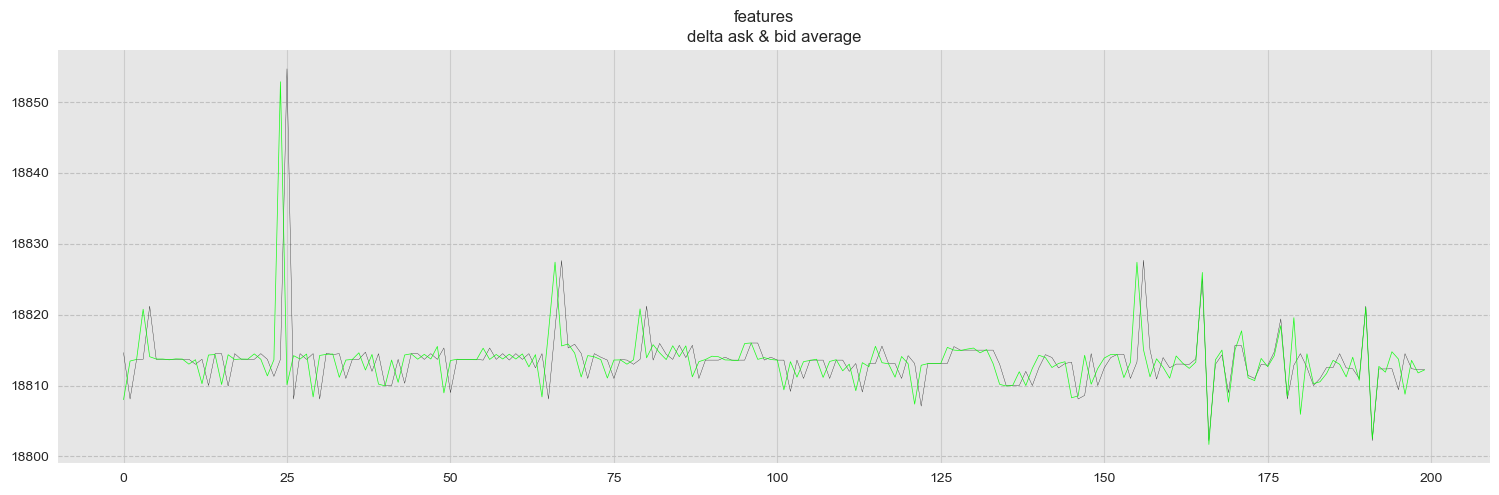

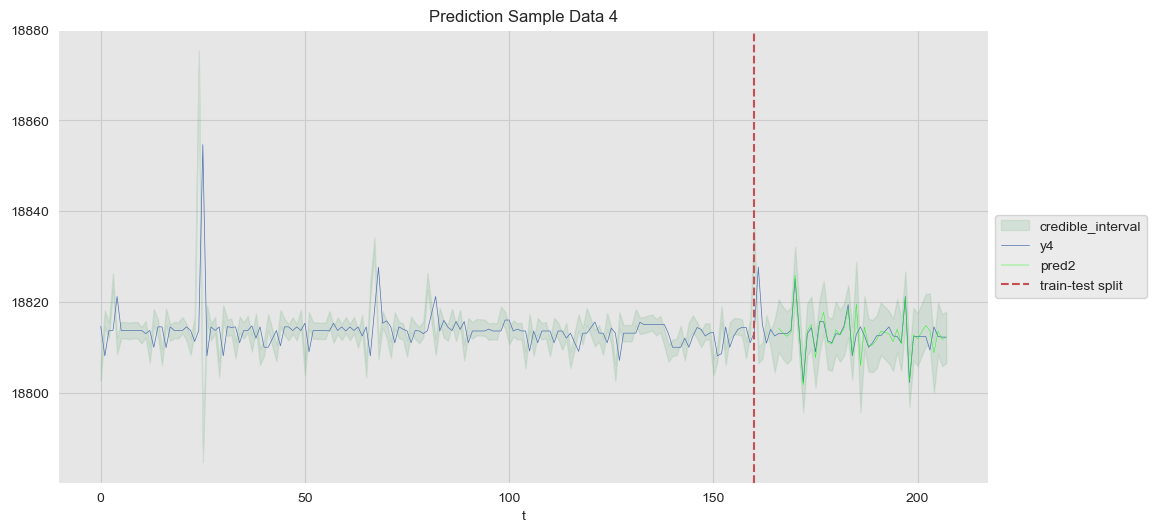

In [99]:
X = X[201:400]
X = df['t'].values.reshape(n, 1)
y = df['delta'].values.reshape(n, 1)

y_pred, y_std = gp4.predict(X, return_std=True)

fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('features')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('delta ask & bid average')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, df.shape[0]), df.ask_price, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, df.shape[0]), df.pred2, '-', color="lime", alpha=0.9, linewidth=0.5)

plt.show()

fig, ax = plt.subplots()

ax.fill_between(
    x=df['t'],
    y1=df['pred2'] + df['y_pred_lwr'],
    y2=df['pred2'] + df['y_pred_upr'],
    color=sns_c[2],
    alpha=0.15,
    label='credible_interval'
)

sns.lineplot(x='t', y='ask_price', data=df, color=sns_c[0], label='y4', ax=ax, linewidth=0.5)
sns.lineplot(x='t', y='pred2', data=df[161:], color='lime', label='pred2', ax=ax, linewidth=0.3)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');



# plt.plot(np.arange(1247, 1558), df.askPrice[1247:], '-', color="black", alpha=0.9, linewidth=0.25)
# plt.plot(np.arange(1247, 1558), df.pred2[1247:], '-', color="lime", alpha=0.9, linewidth=0.15)

# plt.savefig('prediction_new.png', dpi=1200)

plt.show()


In [12]:
def get_data(v, x, size):
    is_ready = False
    if len(x) < size:
        x.append(v)
    else:
        x.pop(0)
        x.append(v)
        is_ready = True
    return x, is_ready

In [13]:
def prepare_training_data(x):
    t = np.arange(size)
    daraframe = pd.DataFrame({'t' : t, 'ask_price' : np.array(x)})
    daraframe['delta'] = 10000 * (daraframe['ask_price'].shift(-1) / daraframe['ask_price'] - 1)
    daraframe.fillna(method="ffill", inplace=True)
    daraframe.fillna(method="bfill", inplace=True)
    return daraframe

In [14]:
x = []
#size = 20
training_data = None
#delta_preds = []
#ask_price_preds = []
#ask_price_preds = {"20": [], "50": [], "100": [], "150": [], "200": []}
#delta_preds = {"20": [], "50": [], "100": [], "150": [], "200": []}
#training_preds_time = {"20": [], "50": [], "100": [], "150": [], "200": []}
ask_price_preds = {"5": [], "10": [], "20": []}
delta_preds = {"5": [], "10": [], "20": []}
training_preds_time = {"5": [], "10": [], "20": []}
#[20, 50, 100, 150, 200]
for size in [5, 10, 20]:
    for index, row in df.iterrows():
        x, is_ready = get_data(row['ask_price'], x, size)
        if is_ready:
            start = time.time()
            training_data = prepare_training_data(x)
            xx_train = training_data['t'].values.reshape(size, 1)
            yy_train = training_data['delta'].values.reshape(size, 1)
            gp4.fit(xx_train, yy_train)
            end = time.time()
            xx = np.arange(size , size + 1, 1)
            xx = xx.reshape(-1, 1)
            delta_pred, std_dev = gp4.predict(xx, return_std=True)
            delta_preds[str(size)].append(delta_pred.item(0))
            ask_price_pred = (delta_pred / 10000 + 1) * row['ask_price']
            ask_price_preds[str(size)].append(ask_price_pred.item(0))
            training_preds_time[str(size)].append(end - start)
            print(index, delta_pred, ask_price_pred, end - start)
    x = []




/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5 [-0.00122386] [21300.06739317] 0.8530092239379883


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6 [0.1443157] [21302.60742563] 0.8963940143585205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


7 [-1.06587191] [21299.92945833] 0.8479528427124023


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


8 [3.53377711] [21320.99170172] 2.026978015899658


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


9 [-0.91235291] [21299.95651495] 0.971437931060791
10 [0.16957297] [21303.3612413] 0.7062857151031494


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


11 [0.13527547] [21302.0881611] 1.6038296222686768


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

12 [29.74954272] [21414.94952789] 1.099275827407837


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13 [-4.64742172] [21291.90015521] 0.8155262470245361
14 [0.12350405] [21303.26310068] 0.7164757251739502


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15 [0.1234977] [21303.26308715] 0.9072890281677246


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16 [-5.08635958] [21289.2360185] 1.4892122745513916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


17 [0.18124876] [21302.28609429] 0.8752799034118652


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


18 [0.10330614] [21303.22007308] 0.9396090507507324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


19 [2.89662492e-05] [21303.00006171] 0.7418880462646484


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

20 [-0.26854773] [21301.3279423] 1.521545171737671


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

21 [-0.02458624] [21301.84762663] 2.945749044418335


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

22 [0.04420482] [21303.89417306] 1.0006637573242188


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better v

23 [-0.83002576] [21298.29204015] 1.7493109703063965
24 [-1.40408071] [21297.06929967] 1.0897042751312256


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25 [-0.17460115] [21299.67809867] 0.8757278919219971


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26 [-0.36143968] [21299.23013347] 0.953575849533081


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

27 [0.00645052] [21300.06373964] 2.038032054901123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28 [0.01244387] [21300.06650549] 1.0081450939178467


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29 [-0.00093895] [21300.03800002] 0.5993630886077881


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

30 [0.83664285] [21304.78230027] 1.0419468879699707


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


31 [-0.28067335] [21299.43216492] 0.8612091541290283


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32 [-0.01967953] [21299.88808273] 0.9039452075958252
33 [-1.21054204] [21299.32131546] 0.8092219829559326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


34 [0.90317067] [21301.85374721] 0.8743071556091309
35 [-0.00937255] [21299.91003653] 0.8709359169006348


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

36 [-0.16125593] [21299.586526] 1.152534008026123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

37 [1.37979511] [21305.93937752] 1.0747129917144775


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38 [-0.29005858] [21299.30217755] 0.7137527465820312


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


39 [-0.00089729] [21299.91808877] 0.6745531558990479


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 [-0.00089729] [21299.91808877] 1.1365420818328857


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


41 [-0.28916115] [21299.30408906] 0.677772045135498


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


42 [0.02346237] [21300.04997484] 1.5260961055755615


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


43 [0.43485814] [21302.32630872] 1.2042279243469238


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

44 [-0.20784511] [21299.37729365] 2.247921943664551
45 [0.00939967] [21299.94002122] 0.6982579231262207


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

46 [0.89635681] [21304.90950891] 0.9218039512634277


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47 [-0.44685334] [21298.86821042] 0.48548388481140137


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48 [4.32147833e-05] [21299.82009205] 0.7540707588195801
49 [0.02445657] [21300.05209249] 0.7002878189086914


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

50 [0.73266919] [21303.46072458] 0.722790002822876


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


51 [0.74286975] [21302.98241657] 0.7590169906616211


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


52 [0.84575815] [21303.70162554] 0.7799320220947266


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

53 [3.50821129] [21322.57778746] 1.2556171417236328


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

54 [3.97736579] [21318.7858898] 1.2820820808410645


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Con

55 [-1.42231898] [21298.570233] 1.2066247463226318


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


56 [-0.0463432] [21301.40128203] 0.6874632835388184


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

57 [-0.88712061] [21300.01026454] 1.0783469676971436


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


58 [3.84027733] [21318.49375004] 3.000767946243286
59 [-0.8264646] [21300.13947337] 0.935896635055542


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60 [-0.31890803] [21299.32072589] 1.0514791011810303


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


61 [-1.97960995] [21298.78283691] 3.534543752670288


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

62 [-0.59931158] [21300.12338243] 1.4164721965789795


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


63 [0.25353845] [21303.54011296] 0.766273021697998


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

64 [1.24271395] [21315.3585602] 2.0404810905456543


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: Co

65 [42.91571341] [21536.86201784] 1.2014310359954834


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

66 [-17.6866776] [21263.72490058] 1.7682232856750488


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


67 [0.23364335] [21303.49773043] 0.8130550384521484


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68 [-1.42528922] [21296.78415963] 0.6886940002441406


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


69 [-13.52497532] [21271.01204601] 0.7264628410339355


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

70 [-1.46342599] [21298.38268312] 0.9353678226470947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


71 [-0.422472] [21299.10013463] 0.6889560222625732


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit ag

72 [-0.47287076] [21300.89269543] 0.9132497310638428


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


73 [0.19531641] [21302.31606107] 0.9219119548797607


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Convergence

74 [4.06363825] [21322.08100288] 1.873715877532959


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [-1.16855027] [21298.51087106] 1.6002840995788574


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76 [-0.08386923] [21300.82135016] 0.7544329166412354


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


77 [-1.25741696] [21300.32132465] 0.7859809398651123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


78 [31.57235293] [21431.44940925] 1.9349009990692139


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


79 [-3.74627239] [21304.41579443] 0.709773063659668


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80 [-0.88656314] [21300.01145206] 0.5229179859161377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


81 [-0.08900588] [21301.71040055] 0.8095791339874268


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

82 [-3.57217987] [21293.41089252] 0.7396609783172607


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


83 [-0.9027133] [21299.97704915] 0.8176860809326172


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84 [3.41331695e-06] [21301.90000727] 0.6687750816345215


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85 [1.86332156e-05] [21301.90003969] 0.8410508632659912


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better 

86 [-0.80815994] [21298.27861933] 0.604727029800415
87 [0.17841967] [21302.28006779] 0.8277781009674072


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


88 [1.59125306e-05] [21301.9000339] 0.8097481727600098


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


89 [1.59125306e-05] [21301.9000339] 0.9506349563598633


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

90 [2.80741877] [21318.38328317] 0.857144832611084


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [4.83441898] [21321.55275114] 1.056015968322754


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

92 [-1.71949643] [21299.33695675] 1.3339662551879883


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

93 [-1.76279455] [21296.2452476] 0.9656350612640381


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


94 [-3.69460114] [21291.95056608] 0.8440718650817871


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit aga

95 [0.36644066] [21301.78055526] 1.033545970916748


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

96 [0.10667307] [21301.24722452] 1.0738041400909424


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

97 [0.33705186] [21300.74792146] 1.5815508365631104


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


98 [-0.11617112] [21299.79255506] 1.959273099899292


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Con

99 [0.18847711] [21301.40147509] 1.3911290168762207


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


100 [1.19472261] [21306.34521316] 1.1622529029846191


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and

101 [-0.13529455] [21301.6117969] 0.9182958602905273


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

102 [2.20087959] [21315.97035613] 1.8684301376342773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


103 [-0.79537143] [21300.20570772] 0.8243610858917236


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


104 [-0.34322779] [21300.2888898] 0.8316962718963623


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

105 [-1.84022083] [21297.97997999] 1.0007681846618652


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

106 [-0.52104843] [21300.79006785] 1.6860251426696777


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


107 [3.41331695e-06] [21301.90000727] 0.657808780670166


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

108 [2.43582748] [21316.38103823] 1.423762321472168


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


109 [-0.66499805] [21301.58335464] 1.014697790145874
110 [-0.10293131] [21301.68073676] 0.6848068237304688
111 [-0.07477014] [21301.34072839] 1.1260919570922852


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


112 [-0.57692024] [21300.67105027] 0.7955849170684814


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


113 [-0.17838181] [21301.12002] 0.7092258930206299


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

114 [-0.09501947] [21301.19759522] 1.0179619789123535
115 [-0.00938927] [21301.37999953] 0.6684470176696777


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


116 [0.23152611] [21302.39319459] 1.456925868988037


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

117 [0.22145621] [21302.37174381] 0.6390149593353271


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a bette

118 [0.27434163] [21303.58442997] 0.8427882194519043


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


119 [0.39837289] [21303.84865378] 0.8179099559783936


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

120 [-0.4970867] [21299.94115563] 0.6903562545776367


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

121 [2.48885208] [21316.49403996] 0.9442782402038574


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


122 [-1.13986079] [21298.59198026] 0.5699987411499023


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

123 [-3.12343915] [21296.34613757] 0.9978101253509521


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

124 [-4.71142391] [21303.18843385] 0.917830228805542


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


125 [0.90584938] [21304.92973094] 0.8289279937744141


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


126 [-0.3713004] [21299.23912904] 0.6597397327423096
127 [0.27937272] [21303.5951477] 0.6381733417510986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

128 [0.02861961] [21303.06096836] 1.1577799320220947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


129 [3.88796111e-05] [21303.00008283] 0.58648681640625


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  w

130 [-0.80091257] [21299.29397614] 0.6132261753082275


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


131 [-0.01008149] [21301.37852502] 0.6312739849090576


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


132 [0.01594947] [21302.23397588] 1.219592809677124


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


133 [0.43239723] [21301.94105019] 1.014570951461792


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


134 [0.37369587] [21303.7960843] 0.6701178550720215


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


135 [0.15023234] [21303.32003996] 0.6090621948242188


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


136 [0.9201833] [21303.86016526] 1.1179249286651611


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

137 [-0.23847831] [21300.89200781] 0.8003199100494385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

138 [-0.35181038] [21301.15057704] 0.8636620044708252


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

139 [0.35085713] [21303.74743094] 0.6379001140594482


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


140 [0.15796773] [21302.23650128] 0.7022490501403809


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the b

141 [0.44128163] [21304.94010639] 0.8396801948547363


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


142 [-0.19712132] [21301.48009414] 0.740048885345459


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

143 [-0.6765278] [21302.35873869] 1.5809361934661865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


144 [0.85833898] [21304.82851953] 0.7682778835296631


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


145 [-0.01875541] [21303.3600446] 0.6990408897399902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

146 [-0.70166611] [21300.40531787] 0.8291409015655518


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

147 [0.1689018] [21301.35977772] 1.253901720046997


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

148 [0.37051232] [21303.78930239] 0.6278738975524902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


149 [0.91409871] [21303.84720393] 0.9873158931732178


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


150 [-0.16523021] [21300.6680428] 0.7172901630401611


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


151 [-0.50707885] [21301.91976992] 2.570802927017212


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

152 [8.00249025] [21344.98764719] 0.7304179668426514


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


153 [-0.08715251] [21300.81435644] 1.825798749923706


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


154 [0.16771385] [21302.25726238] 0.7123239040374756


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


155 [-0.1003109] [21301.68631872] 0.7515780925750732


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


156 [-2.43988749] [21296.70257607] 1.2469639778137207


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


157 [-0.18480858] [21301.00633186] 1.4495947360992432


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

158 [0.46477465] [21304.39012803] 1.4505159854888916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


159 [-0.54664298] [21298.86564881] 2.0938870906829834


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

160 [-1.59322858] [21298.50612041] 0.7944810390472412


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

161 [-1.51056627] [21300.18198024] 1.4674859046936035


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

162 [1.04935658] [21304.1353289] 1.0693199634552002


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


163 [0.45726154] [21304.37412255] 0.703545093536377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

164 [-0.3322058] [21301.19233853] 1.205435037612915


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


165 [-0.69969559] [21300.90948047] 1.407557725906372


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

166 [2.88781139] [21319.68494547] 1.1718251705169678


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

167 [-1.77793482] [21297.11283881] 1.2430810928344727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


168 [2.89815708] [21323.00795219] 1.0106210708618164
169 [-1.79693727] [21296.20251822] 0.7359988689422607
170 [-1.26567057] [21297.33411789] 0.47267603874206543
171 [0.61823405] [21301.33683977] 0.7373011112213135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


172 [-0.68167638] [21301.54782482] 1.143094778060913
173 [-0.28067263] [21299.42216675] 0.7556800842285156


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


174 [4.01703611] [21325.39304758] 2.2936599254608154


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


175 [3.45489306] [21334.1981917] 0.9201829433441162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

176 [-5.11752603] [21289.11965932] 1.2835981845855713


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


177 [0.71354324] [21305.32011824] 1.0445730686187744


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


178 [-2.32964922] [21298.8369619] 1.082618236541748


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


179 [-2.60989852] [21295.84055078] 0.8618168830871582


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


180 [-0.38335517] [21302.18333849] 0.9059052467346191


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

181 [-1.11818286] [21300.61793505] 1.1409108638763428


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


182 [5.066554] [21327.63028704] 1.1956660747528076


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


183 [-1.14649905] [21300.55761308] 0.8094038963317871
184 [-0.39346827] [21300.06187716] 0.9579000473022461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


185 [0.0102511] [21302.0218369] 0.8334500789642334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


186 [0.60863371] [21306.09668194] 1.4218077659606934


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Con

187 [-1.04195901] [21297.80062523] 1.1165440082550049


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


188 [-2.25636724] [21298.19326086] 1.0781209468841553


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

189 [1.18139678] [21306.32682526] 1.2820289134979248
190 [0.89060586] [21302.91708133] 0.7395339012145996


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

191 [-1.31787876] [21300.99241744] 0.9924039840698242


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

192 [1.05896631] [21305.25591593] 1.3790528774261475


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit ag

193 [-0.7845774] [21302.13855121] 0.9938838481903076


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


194 [0.26123518] [21304.35653021] 3.1753900051116943


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

195 [0.1848767] [21302.79383175] 0.9934639930725098


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packag

196 [3.50266597] [21323.84641588] 1.417146921157837
197 [-1.53700202] [21298.62589368] 0.9550189971923828


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


198 [-0.15870576] [21301.66192499] 0.6590139865875244


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


199 [-0.40845872] [21299.14998211] 0.5048930644989014


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


200 [-1.16325821] [21299.52202735] 0.554527997970581


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit ag

201 [2.23543728] [21314.31361626] 1.0126729011535645


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


202 [-0.82289685] [21301.54695815] 1.316127061843872


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

203 [3.15014827] [21309.01054035] 1.123737096786499


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


204 [0.15982121] [21303.34046712] 0.8265810012817383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


205 [3.09286697] [21316.14076033] 0.8151698112487793


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


206 [0.02250352] [21304.8479433] 0.7269251346588135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


207 [-0.10311516] [21302.78033376] 1.1123261451721191


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


208 [-0.20639233] [21301.46034512] 0.7345438003540039


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

209 [0.62575251] [21304.63305935] 0.6381707191467285


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

210 [-0.14507752] [21299.7109846] 0.9241280555725098


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


211 [0.27986222] [21303.59619048] 1.1026649475097656


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


212 [-0.08444488] [21301.82011552] 0.7443399429321289


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


213 [-0.23189532] [21302.5059934] 1.0422210693359375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


214 [0.14837946] [21302.61608237] 0.903066873550415


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


215 [0.21594569] [21304.26004638] 0.7581861019134521


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


216 [-0.16896856] [21301.64006318] 0.6189119815826416


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


217 [-0.1126501] [21301.66003389] 0.8861258029937744


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

218 [-0.14669886] [21300.68751676] 1.5251832008361816


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


219 [0.78660917] [21303.67563485] 0.9192318916320801


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


220 [-0.4191492] [21301.00713256] 0.9683809280395508


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


221 [-0.0111416] [21301.97626615] 1.187380075454712


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


222 [-0.6382073] [21299.84054187] 1.9786460399627686


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


223 [2.86183156] [21317.88907532] 1.5408039093017578


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


224 [-0.92766216] [21299.92390334] 0.7231791019439697
225 [-0.0089249] [21301.88098827] 0.6591129302978516


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


226 [0.06618542] [21302.04098752] 0.687371015548706
227 [-0.92812476] [21299.92291792] 0.7089972496032715
228 [0.02934623] [21302.06251335] 1.3989250659942627


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


229 [-0.24165389] [21300.50525257] 1.0866973400115967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


230 [0.08262901] [21302.07601549] 1.232408046722412


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

231 [-0.37062299] [21301.91047296] 1.6778042316436768


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


232 [3.34778632] [21318.53460135] 1.0995688438415527


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


233 [3.78080757] [21319.45743023] 2.244800090789795


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


234 [0.70906857] [21302.71040114] 1.0028431415557861


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

235 [-3.30986404] [21295.94899663] 0.9490859508514404
236 [-0.84455969] [21300.90085983] 0.8845109939575195


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


237 [-0.94783337] [21299.98092535] 0.7485790252685547


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


238 [0.07512014] [21302.16002093] 0.7331719398498535


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


239 [-0.2779047] [21300.42803465] 0.6632261276245117


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


240 [0.02629924] [21302.05602264] 0.5141510963439941


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


241 [-0.18777156] [21300.60002779] 0.5285439491271973


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


242 [0.07512249] [21302.06002517] 0.6693320274353027


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

243 [0.40582834] [21302.76449147] 0.5287811756134033


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


244 [-0.00938482] [21301.88000854] 0.6985518932342529


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


245 [0.08450307] [21302.08000761] 0.6170432567596436


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


246 [0.02932567] [21302.06246954] 0.8939130306243896


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


247 [-0.00938875] [21301.88000017] 0.4831879138946533


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


248 [4.40747437e-08] [21301.90000009] 0.5539243221282959


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


249 [4.40747437e-08] [21301.90000009] 0.7751369476318359


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


250 [-0.00938879] [21301.88000009] 0.4746561050415039


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


251 [0.029325] [21302.06246812] 1.8802001476287842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


252 [-0.54715805] [21298.83455335] 2.356837034225464


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


253 [0.17842057] [21302.28006972] 0.6047587394714355


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


254 [0.78728911] [21302.69700611] 0.6119232177734375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decrea

255 [-0.23217405] [21301.50542285] 0.8721888065338135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


256 [0.16901881] [21302.26004218] 0.5854477882385254


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

257 [0.12179177] [21300.25941646] 0.9208598136901855


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

258 [0.62400834] [21304.32932496] 0.7970249652862549


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

259 [0.86856399] [21304.85030188] 0.6395070552825928


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


260 [1.20771271] [21304.57266962] 0.868628978729248


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

261 [-0.30196226] [21300.55678414] 0.704293966293335


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

262 [3.15844444] [21320.77192112] 1.1104519367218018


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


263 [-1.24173853] [21299.25486099] 0.6626379489898682


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


264 [5.97975402] [21314.63801222] 0.9136788845062256


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


265 [-0.02747768] [21301.3414687] 0.6850371360778809


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


266 [7.37538388] [21333.60275485] 1.1594960689544678


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


267 [-1.47928687] [21298.84882311] 0.7667498588562012


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


268 [-0.36500882] [21299.22253122] 0.6676859855651855


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


269 [0.01994589] [21300.84248634] 0.7384908199310303


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

270 [-0.88996329] [21299.30427139] 1.0724737644195557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


271 [0.54672606] [21304.16469052] 0.825584888458252


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

272 [4.61306331] [21327.71407301] 1.6125340461730957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

273 [-2.92828649] [21292.76304261] 1.1507949829101562
274 [0.53742035] [21304.14486657] 0.6707439422607422


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


275 [1.18426323] [21303.32257543] 1.6848161220550537


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


276 [-1.60222224] [21297.38713845] 0.5728967189788818


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

277 [0.12483829] [21302.26593053] 0.7936651706695557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

278 [0.41876219] [21301.91200618] 0.9107959270477295


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


279 [0.53997308] [21301.95018585] 0.795482873916626
280 [-0.75889142] [21297.38363718] 0.6764700412750244


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


281 [0.30207154] [21302.04345467] 1.1219909191131592


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

282 [0.88817219] [21302.69187782] 0.8236129283905029


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit aga

283 [1.10110134] [21301.34523574] 0.6366150379180908


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

284 [0.14128389] [21303.30097706] 0.7788190841674805


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


285 [1.81645799] [21305.86941881] 0.8322412967681885


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


286 [1.57350436] [21304.75178459] 0.7745168209075928


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


287 [0.33805691] [21302.72012883] 0.6575431823730469


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


288 [3.32744212] [21319.13145795] 1.0504529476165771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


289 [-1.19014992] [21299.16477835] 2.1387650966644287


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


290 [0.08495883] [21302.1809793] 0.5910470485687256


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


291 [-0.56286965] [21297.80114393] 0.6227250099182129


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


292 [-0.84447992] [21299.22117164] 0.46378588676452637


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


293 [-0.06381666] [21300.884064] 0.5254220962524414


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

294 [0.65325629] [21304.39163187] 1.1379680633544922


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


295 [5.28947153e-05] [21301.00011267] 0.5706069469451904
296 [0.37370883] [21303.79611192] 0.7805149555206299


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

297 [2.70144251] [21317.79732508] 1.0769731998443604


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

298 [-2.17214492] [21295.39332698] 1.1885709762573242


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


299 [-0.09150952] [21299.82508454] 0.8262069225311279


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

300 [-2.32872787] [21295.05980497] 0.8696389198303223


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


301 [-1.31954998] [21296.1894905] 0.5246400833129883


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

302 [0.39261576] [21301.83631083] 1.019944190979004


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


303 [3.50250404] [21321.24516006] 0.866710901260376


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


304 [-0.98153507] [21300.90903584] 1.0794689655303955


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


305 [5.83620458] [21315.43286661] 0.5273489952087402


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


306 [-0.37115409] [21299.22944105] 0.4181809425354004


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


307 [-1.29132494] [21297.26947528] 1.0985231399536133
308 [-0.27977279] [21299.42408339] 0.6439568996429443


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


309 [0.73360717] [21303.26270797] 1.2674219608306885


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


310 [-0.15772156] [21299.68405276] 0.8511419296264648


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


311 [0.18780569] [21301.42004528] 0.7751109600067139


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

312 [0.56400719] [21302.00138043] 0.5941689014434814


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value

313 [4.52478556] [21323.42402839] 0.8449802398681641


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


314 [-1.64548721] [21295.49527679] 1.554044246673584


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


315 [0.2619065] [21301.95789751] 0.6192357540130615


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


316 [-0.01791235] [21300.9618449] 0.6879980564117432


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


317 [-1.16153277] [21298.72579582] 0.7211849689483643


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


318 [-0.10301755] [21299.80057241] 0.7409729957580566


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


319 [0.05446776] [21301.11602177] 0.9659581184387207


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

320 [2.58445699] [21316.4977337] 0.5569448471069336


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

321 [-1.56439056] [21296.68784498] 0.81968092918396


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a

322 [0.18456437] [21301.39314057] 0.7330722808837891


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


323 [-0.37508215] [21298.20111252] 0.7004952430725098


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


324 [-0.78723764] [21299.12312086] 0.5086719989776611


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


325 [-0.89733502] [21299.48855077] 0.9721701145172119


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


326 [0.05635143] [21301.620037] 0.6838488578796387


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

327 [3.51020688] [21322.06185853] 1.3471438884735107


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


328 [-1.17961781] [21298.88724891] 0.5521430969238281


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


329 [6.05981453] [21315.90922289] 0.8637790679931641


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


330 [-0.60947267] [21297.70188415] 0.5785610675811768


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

331 [-0.48381308] [21298.98947717] 0.8476369380950928
332 [-0.32107907] [21298.3161337] 0.5902857780456543


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


333 [0.07519601] [21301.56017803] 0.8029510974884033


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


334 [0.52581702] [21304.12014799] 0.687453031539917


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

335 [0.68215532] [21302.2530454] 0.7778587341308594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

336 [-0.56698513] [21297.79237837] 1.0585322380065918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

337 [3.14822333] [21318.78951875] 0.8676919937133789


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


338 [-1.15182172] [21298.94645848] 0.5868678092956543


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

339 [-1.47626774] [21298.85525445] 0.9616081714630127


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

340 [-0.00536429] [21298.98857461] 1.3810858726501465


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


341 [-0.22628462] [21299.53801331] 0.9462878704071045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


342 [-0.12955022] [21299.74405777] 0.5917580127716064
343 [-0.18601015] [21299.62379801] 0.6618108749389648
344 [0.09577914] [21300.22400977] 0.7124931812286377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Convergence

345 [4.03551706] [21322.38121228] 1.4893450736999512


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


346 [2.03421383] [21307.33348573] 0.8042020797729492


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


347 [-0.01996182] [21301.35747854] 0.7313637733459473
348 [0.01758318] [21300.83745358] 0.5785579681396484


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


349 [0.35326143] [21303.75255282] 1.8367207050323486


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound 

350 [-0.83018369] [21297.23179176] 1.241877794265747


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


351 [6.93791941] [21341.62638278] 0.9773387908935547


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


352 [-2.77541708] [21293.08863916] 0.7833948135375977


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


353 [-3.32346164] [21293.94068771] 0.8639018535614014
354 [0.00155027] [21300.00330208] 0.663193941116333


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


355 [-2.7037413] [21293.24130141] 0.5116112232208252


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

356 [-0.55748992] [21299.61250187] 0.864375114440918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


357 [5.12766017] [21327.71052037] 0.9506380558013916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


358 [-1.73045467] [21297.71388928] 1.4771709442138672


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


359 [7.40612459] [21317.17608223] 1.1032910346984863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


360 [0.17008711] [21302.36231956] 0.5752778053283691
361 [-1.6119913] [21297.36632957] 0.7439830303192139


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

362 [-0.57437548] [21300.17649981] 0.6970911026000977


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decrea

363 [-0.60769582] [21297.70566866] 1.151806116104126
364 [0.12993788] [21301.47678327] 0.9075589179992676


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


365 [0.37559022] [21303.80011984] 0.6518981456756592


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

366 [1.24653312] [21304.05529005] 1.0244731903076172


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

367 [3.10737216] [21319.95284482] 0.9791429042816162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


368 [-0.79978776] [21301.29621214] 1.0270411968231201


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

369 [-1.7368251] [21300.09990254] 0.7719011306762695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


370 [0.22587455] [21304.28119862] 0.5872271060943604


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


371 [-1.45751941] [21297.69536705] 0.8975739479064941


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


372 [-0.3567622] [21299.24009651] 0.8293828964233398


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


373 [-0.45046081] [21302.04038334] 1.1777141094207764


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

374 [0.26017876] [21304.35427963] 1.6862249374389648


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


375 [1.20232908] [21306.36141782] 1.1182599067687988


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


376 [-1.32270918] [21298.18249718] 2.710085153579712


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


377 [0.18781253] [21303.40009703] 1.4768130779266357


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

378 [1.48373624] [21316.52234046] 0.7775721549987793


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

379 [-2.14588723] [21296.4290456] 1.110511064529419


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


380 [0.3761509] [21303.80131427] 0.8005740642547607


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

381 [3.57444789] [21307.64358472] 0.7830979824066162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


382 [-1.06872588] [21298.723507] 0.5908510684967041


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


383 [0.37559955] [21303.80013972] 0.8680770397186279


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

384 [0.83428905] [21303.77720254] 0.8153200149536133


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


385 [0.3727566] [21303.79408339] 0.7227268218994141


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


386 [-0.18774494] [21300.60008449] 0.8881640434265137


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


387 [-0.04771484] [21301.39836023] 0.9960730075836182


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

388 [0.105943] [21301.22566918] 1.4490909576416016


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


389 [4.28759925] [21322.49831463] 0.7020058631896973


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


390 [-1.12162683] [21298.81080027] 0.6714119911193848


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


391 [-0.06506105] [21300.86141346] 0.879478931427002
392 [2.09258292] [21316.59974202] 0.718005895614624


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


393 [-1.82934062] [21299.10295567] 0.8059041500091553


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


394 [-0.11219558] [21301.26100659] 0.5690040588378906


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


395 [-0.22862895] [21299.54301965] 0.6542949676513672


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


396 [0.39862386] [21302.84914854] 0.6659529209136963


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


397 [3.05217005] [21318.64482755] 1.095677137374878


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

398 [-1.4372971] [21298.93826972] 1.2119030952453613


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


399 [0.00140894] [21301.02300119] 0.8148038387298584


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


400 [0.43048355] [21304.71709355] 0.8351120948791504


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

401 [0.30362809] [21304.45684352] 2.016486883163452


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


402 [0.16807143] [21304.158056] 0.7406668663024902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


403 [-0.10965679] [21302.76639814] 1.1986939907073975


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Con

404 [-0.67178213] [21299.36905033] 1.0187897682189941


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find 

405 [0.50805603] [21304.88235241] 2.2082858085632324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


406 [-0.93311558] [21301.81210922] 0.9600391387939453


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


407 [0.91606485] [21304.95149296] 0.7294702529907227


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a b

408 [-1.83815907] [21296.08472119] 1.4602680206298828


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


409 [-0.33035023] [21300.69630776] 0.9602212905883789


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

410 [2.72505876] [21317.94768338] 1.0747160911560059


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


411 [0.3082844] [21303.65673826] 0.8453750610351562


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

412 [4.93344876] [21311.90893654] 0.7934010028839111


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


413 [-0.42061967] [21302.10395393] 1.3465981483459473


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again ma

414 [-0.7799066] [21299.13873655] 0.7099871635437012


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


415 [0.20668627] [21303.44030377] 0.6758029460906982


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

416 [-0.28722232] [21300.78817624] 1.0840351581573486


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

417 [-0.4239043] [21300.59702026] 1.649949073791504


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


418 [-0.73343347] [21301.43756667] 0.6885461807250977


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


419 [-0.30041657] [21300.76007065] 0.8178989887237549
420 [-0.11265803] [21300.56002939] 0.8789010047912598


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


421 [-0.72684309] [21299.85172246] 0.846480131149292


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


422 [3.88467548] [21320.77921462] 1.4894027709960938
423 [-1.30921914] [21298.23122969] 1.834097146987915


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

424 [-4.98928215] [21301.86659242] 0.8701932430267334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


425 [-0.74022558] [21301.42309745] 0.7133970260620117


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


426 [-1.17256547] [21299.00225967] 0.630692720413208


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


427 [0.13945192] [21302.29706048] 0.7336089611053467


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Con

428 [-0.73481205] [21299.45477537] 0.8167037963867188
429 [0.18592286] [21303.39607146] 0.5949230194091797


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


430 [-0.27224586] [21300.22009453] 0.8377127647399902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


431 [0.87942171] [21302.13319111] 0.8750321865081787


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

432 [0.94313193] [21305.8092294] 1.0130579471588135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


433 [-0.37547954] [21300.60017602] 0.5770299434661865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


434 [1.64835123] [21304.51115296] 0.9727239608764648


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


435 [0.4450914] [21303.94817821] 0.7644729614257812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


436 [0.92214687] [21303.36430192] 0.8496227264404297


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


437 [0.8231572] [21303.2534483] 0.9069592952728271


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

438 [-0.74942607] [21301.40349764] 0.8556962013244629


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


439 [0.03121478] [21301.06649059] 1.2113101482391357


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


440 [-0.33014784] [21302.29668605] 0.7746167182922363


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

441 [2.99629594] [21320.12622726] 1.6064262390136719


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

442 [-1.982467] [21297.27704791] 1.0538792610168457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


443 [-0.18530903] [21299.86528695] 0.7524909973144531


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


444 [-0.04258802] [21301.30928156] 0.7534220218658447


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: Con

445 [-0.26879017] [21302.4273963] 1.0589540004730225


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

446 [-0.56789676] [21299.0403657] 0.786754846572876


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


447 [-0.00091378] [21300.24805362] 0.5873401165008545


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


448 [-0.10795473] [21300.02005372] 0.626467227935791


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


449 [-0.26005751] [21299.68607126] 0.8143339157104492


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


450 [0.33664343] [21302.11709764] 0.9553489685058594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again ma

451 [0.77558778] [21303.65215709] 1.0260331630706787


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

452 [-0.06405377] [21301.2635565] 1.2762830257415771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

453 [-0.39588801] [21299.40674865] 0.983494758605957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


454 [-0.19689041] [21299.8306185] 0.8754637241363525


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

455 [-0.13743966] [21299.95725009] 1.057995080947876


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


456 [-0.10985204] [21300.00601253] 1.0932910442352295


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


457 [0.33664349] [21302.11709776] 0.9803848266601562


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


458 [0.10798] [21301.63001252] 0.8372848033905029


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


459 [0.38492925] [21301.8199378] 1.6482207775115967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

460 [0.20972876] [21303.44678517] 1.2903149127960205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

461 [-0.18500509] [21302.60588366] 1.1546058654785156


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


462 [3.52879477] [21321.26118142] 1.1071710586547852


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


463 [-1.49461375] [21297.81632324] 2.282620906829834


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

464 [-3.87254512] [21294.75031713] 0.9662463665008545


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

465 [0.34922982] [21302.74392936] 1.9126040935516357
466 [-1.28934764] [21298.25356059] 0.9724771976470947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


467 [-0.14645878] [21299.90803957] 0.7684879302978516


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


468 [-0.14241126] [21299.90666102] 1.624541997909546


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

469 [-0.05900124] [21300.11432595] 2.162045955657959


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

470 [0.79585225] [21303.09527671] 2.400916814804077


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


471 [4.91973741] [21327.45738949] 2.990266799926758


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


472 [-0.89765992] [21301.88764327] 0.943364143371582
473 [0.33515943] [21304.51401696] 1.0044939517974854
474 [0.22624047] [21304.28197818] 0.8721249103546143
475 [-1.23563527] [21301.16762733] 0.7864999771118164


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

476 [0.] [21303.8] 0.4966452121734619


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


477 [-0.70373799] [21299.90093955] 1.742495059967041


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


478 [0.22536269] [21304.28010816] 1.0831382274627686
479 [0.0568657] [21301.12112963] 0.8019063472747803


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

480 [0.59322943] [21305.0738047] 1.978947639465332
481 [-0.75010932] [21298.40226714] 0.8043010234832764


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

482 [-1.45725231] [21298.89576113] 0.855025053024292


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:4

483 [-1.59791798] [21300.40582589] 1.372704029083252


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


484 [0.78175008] [21304.66536219] 1.6249821186065674


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


485 [-0.43976896] [21300.46323056] 0.9828338623046875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

486 [-0.1724027] [21303.44271655] 1.1781587600708008


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  wa

487 [1.05796157] [21305.25377554] 1.059981107711792


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


488 [-0.30040729] [21300.76009042] 0.7008938789367676


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

489 [2.70084095] [21317.86606195] 1.699286937713623


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


490 [-1.23081347] [21298.778195] 0.9307172298431396


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


491 [-0.26237691] [21300.2411162] 0.8340399265289307


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


492 [0.05684283] [21301.52108318] 0.8944404125213623


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


493 [-1.08017323] [21298.69912301] 1.2931640148162842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


494 [-0.15563781] [21298.66850702] 2.0243539810180664


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

495 [0.58368554] [21303.24336693] 1.129122257232666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


496 [0.24413834] [21303.5200879] 0.8656020164489746


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


497 [1.08485704] [21302.3107455] 2.6955649852752686


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

498 [-1.10761238] [21299.04063056] 0.8547959327697754


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

499 [-1.08328402] [21299.09245337] 1.1934049129486084


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10 [0.51975013] [21304.10722369] 1.1848938465118408


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


11 [3.62270066] [21309.51700449] 0.8784880638122559


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better v

12 [14.18500706] [21381.71701852] 1.3859529495239258


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13 [-1.86853838] [21297.81967692] 0.7971949577331543


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


14 [10.27251242] [21324.88353321] 0.9228770732879639


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15 [-0.0250225] [21302.94669456] 0.8479952812194824


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16 [-2.82945901] [21294.04323249] 1.2556838989257812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


17 [-4.14888279] [21293.06209136] 0.8743412494659424


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

18 [-0.56674866] [21301.79265533] 1.0001530647277832


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


19 [0.00565207] [21303.01204061] 0.8149828910827637


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20 [-0.14057948] [21301.60053899] 0.8940391540527344


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


21 [-19.0462549] [21261.32785827] 0.9135298728942871


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22 [-0.01411713] [21303.76992514] 0.9064183235168457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may

23 [0.19816155] [21300.4820853] 1.4780328273773193


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find

24 [-0.09999789] [21299.8470039] 1.6136271953582764


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25 [0.68263659] [21301.50401934] 0.8976860046386719


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26 [-0.01585463] [21299.96622964] 1.0711512565612793


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


27 [-0.51290613] [21298.95750738] 0.9060540199279785


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28 [-0.11286478] [21299.79959756] 1.152350902557373


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29 [-0.02238053] [21299.99232938] 0.5277960300445557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30 [0.26533767] [21303.56524883] 1.1075210571289062


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


31 [-1.45582206] [21296.92909464] 0.686007022857666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

32 [-0.02337141] [21299.88021906] 0.758934736251831


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


33 [-1.19516382] [21299.35407399] 2.1406307220458984


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

34 [0.10860084] [21300.16131903] 1.221808910369873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35 [0.01662155] [21299.96540378] 0.7486820220947266


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

36 [1.3628149] [21302.8327862] 0.8544771671295166


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


37 [0.05766894] [21303.12285214] 0.5889918804168701


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38 [0.62376866] [21301.24862225] 0.8129978179931641


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


39 [-1.07387677] [21297.63265107] 1.1718969345092773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 [-0.03622951] [21299.84283142] 0.8084259033203125


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


41 [0.68768519] [21301.38476395] 0.6467268466949463


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

42 [-0.06047412] [21299.87119012] 1.3001928329467773
43 [0.131328] [21301.67974703] 1.0203378200531006


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44 [-0.02849883] [21299.75929801] 1.7133660316467285


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


45 [0.23195583] [21300.41406406] 1.080092191696167


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


46 [1.3666435] [21305.91136064] 1.8388340473175049


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47 [0.96013904] [21301.86507887] 0.8341801166534424


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

48 [0.02489822] [21299.87303277] 1.6474878787994385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may 

49 [-0.68054563] [21298.5504378] 0.9780669212341309


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 [0.07186855] [21302.05309368] 0.580298900604248


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


51 [1.19863258] [21303.9532552] 0.9321718215942383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

52 [0.2559641] [21302.44525216] 1.735914707183838


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


53 [6.1750447] [21328.26216953] 1.3179631233215332


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

54 [2.85818185] [21316.40087412] 1.4160888195037842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

55 [-1.20517455] [21299.03278538] 1.4500651359558105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

56 [0.08442532] [21301.6798386] 1.4023101329803467
57 [-0.22105953] [21301.42910121] 0.9669179916381836


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

58 [1.42873521] [21313.35467903] 1.8543341159820557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


59 [0.10870353] [21302.13155917] 1.1887786388397217
60 [-0.15445854] [21299.6710033] 0.7379720211029053


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

61 [0.88175049] [21304.87839306] 1.8289318084716797


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


62 [-1.93660347] [21297.27476349] 1.0189719200134277


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

63 [3.94359261] [21311.40103534] 0.9794721603393555


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

64 [-0.57036451] [21311.49439867] 1.763127088546753


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


65 [41.8488088] [21534.57405905] 1.1029250621795654


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


66 [-13.79306333] [21272.01884408] 1.0031678676605225


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


67 [1.41362999] [21306.01145596] 0.9428937435150146


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68 [-0.7158909] [21298.29516527] 0.7199859619140625


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

69 [4.52652273] [21309.46141194] 1.0019609928131104


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70 [-0.54565932] [21300.3376638] 0.5869238376617432


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


71 [0.53437062] [21301.13820943] 0.7115590572357178


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

72 [60.75024184] [21431.30955766] 1.553920030593872


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


73 [45.97906063] [21399.84413516] 0.8724358081817627


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


74 [-43.10563057] [21221.54715913] 1.1323277950286865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [0.47401643] [21302.0097024] 1.2365901470184326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76 [-0.39397736] [21300.16078884] 0.8243408203125


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


77 [-1.36185001] [21300.09885093] 1.2014179229736328


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

78 [36.0740322] [21441.06679605] 1.1835880279541016


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


79 [-0.95351053] [21310.36784022] 1.0298469066619873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80 [1.06524929] [21304.16918339] 0.9059429168701172


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


81 [0.00191095] [21301.9040707] 0.8815369606018066


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


82 [4.00244928] [21309.54562521] 0.9410150051116943


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


83 [0.56908522] [21303.11225965] 0.7805590629577637


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84 [0.01266113] [21301.92697062] 0.7120897769927979


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85 [28.10103294] [21361.76053936] 1.002262830734253
86 [-0.16549749] [21299.64749034] 1.5481147766113281


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:

87 [0.19916937] [21302.32426861] 1.6542508602142334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

88 [-0.38672392] [21301.07620457] 1.9233250617980957
89 [0.48932275] [21302.94235044] 0.9953007698059082


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

90 [2.18293028] [21317.05234833] 1.0834808349609375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [0.4165066] [21312.13762764] 0.756324291229248


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

92 [-1.44820518] [21299.91488851] 1.321631908416748


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


93 [-0.54114441] [21298.8473624] 1.8935739994049072


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

94 [-0.11097455] [21299.58362621] 1.254042148590088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

95 [0.20891174] [21301.4450029] 1.1207129955291748


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

96 [-0.10665934] [21300.79280473] 1.4942240715026855


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasin

97 [-0.34501921] [21299.29510804] 2.0387301445007324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

98 [-0.19278893] [21299.6293588] 1.3563289642333984


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


99 [-3.29940638] [21293.97193447] 1.2040338516235352


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

100 [0.91115919] [21305.74111532] 1.3210318088531494


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


101 [0.1701196] [21302.26238708] 1.6641569137573242


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

102 [2.28195828] [21316.14314518] 1.954233169555664


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


103 [0.32429499] [21302.59080995] 0.7713949680328369


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit aga

104 [-0.58969161] [21299.76389673] 1.308581829071045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


105 [-0.32437644] [21301.20901655] 0.6755588054656982


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

106 [-0.09093986] [21301.70628082] 1.2814741134643555


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

107 [4.66799176] [21311.84370937] 1.0875751972198486


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


108 [-4.24529901] [21302.14276263] 1.1428239345550537


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


109 [0.68147485] [21304.45174588] 0.9892888069152832


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


110 [3.2615424] [21308.847705] 0.8068017959594727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


111 [-0.01293503] [21301.47244645] 1.4422879219055176


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

112 [0.00043524] [21301.90092715] 0.8565869331359863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

113 [4.33058772] [21310.72480143] 1.0915682315826416


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


114 [-0.00717664] [21301.38471276] 0.7790448665618896


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


115 [-0.00597334] [21301.38727596] 0.7947728633880615


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


116 [3.24912039] [21308.82124376] 1.032500982284546


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


117 [-0.18707348] [21301.50149793] 1.071281909942627


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


118 [0.40189268] [21303.85615197] 1.2381420135498047


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


119 [0.10643681] [21303.22674234] 1.938467025756836


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

120 [-0.33207286] [21300.2926516] 3.1194870471954346


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

121 [1.89870915] [21315.23637515] 1.805953025817871
122 [-0.49932045] [21299.9563965] 1.0968408584594727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


123 [1.94146183] [21307.13589614] 1.6131279468536377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


124 [0.44005753] [21314.16790474] 0.7020077705383301
125 [-0.42787746] [21302.08849265] 0.5635039806365967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


126 [-0.74499262] [21298.44316349] 1.3491861820220947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

127 [-1.78335678] [21299.20091506] 1.0281200408935547


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


128 [-0.69802343] [21301.51300068] 0.7174808979034424
129 [0.59879262] [21304.27560792] 1.0540010929107666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


130 [-0.42157631] [21300.10200031] 0.8572309017181396


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


131 [0.15348169] [21301.72693748] 0.8416261672973633


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

132 [-0.62318812] [21300.87247221] 1.2800531387329102


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

133 [-0.51106184] [21299.93138615] 1.221966028213501


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

134 [0.15415248] [21303.32839104] 1.4567711353302002


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


135 [1.0727234] [21305.28522266] 0.6185400485992432


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

136 [0.27300275] [21302.48154773] 1.254486083984375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


137 [-0.02527115] [21301.34616892] 0.5990960597991943


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

138 [-0.08647826] [21301.71578487] 1.2099828720092773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


139 [0.17695559] [21303.3769685] 0.7860908508300781


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


140 [-0.23372301] [21301.40212558] 0.965709924697876


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


141 [-0.28926182] [21303.38375661] 0.6254029273986816
142 [-0.07785471] [21301.73415467] 0.7864198684692383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


143 [0.02866395] [21303.86106511] 0.641441822052002


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

144 [-0.29622889] [21302.3689436] 1.1491749286651611


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


145 [-0.34142983] [21302.67263837] 1.6985433101654053


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


146 [0.51223586] [21302.9911597] 1.0846951007843018


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


147 [0.15693747] [21301.3342925] 1.0235676765441895


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


148 [0.32591644] [21303.69429979] 0.96356201171875
149 [-0.38026625] [21301.08996065] 0.8839640617370605


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


150 [-0.7794704] [21299.35964855] 0.6664509773254395


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again 

151 [-0.37024814] [21302.2112604] 0.866361141204834


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


152 [10.02264733] [21349.29622205] 1.3900079727172852


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


153 [-2.73904679] [21295.16555643] 1.1260039806365967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


154 [-0.5304335] [21300.77007585] 0.4812779426574707


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


155 [0.00136203] [21301.90290138] 0.7502338886260986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

156 [11.62778072] [21326.66938221] 0.916172981262207


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


157 [-0.40887556] [21300.52903781] 0.6984388828277588


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


158 [11.55567781] [21328.01752266] 0.8866579532623291
159 [-0.28893173] [21299.41457455] 0.7795841693878174


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


160 [8.70847207] [21320.45070012] 0.6658940315246582


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


161 [-10.24473829] [21281.57522424] 0.5464529991149902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


162 [0.66296007] [21303.31223091] 0.6391539573669434


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may fin

163 [0.14085852] [21303.70007653] 1.1399579048156738


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


164 [0.83853784] [21303.68624492] 0.6527597904205322
165 [-1.21103921] [21299.82019584] 0.6693658828735352


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

166 [0.32455132] [21314.22173343] 0.933870792388916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


167 [-0.05882156] [21300.77470478] 0.8870608806610107


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decrea

168 [-3.76218117] [21308.81022236] 1.1388599872589111
169 [-0.1581418] [21299.6931575] 0.9302549362182617


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

170 [-0.69815014] [21298.54293811] 0.7933611869812012


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

171 [5.73279641] [21312.23086781] 0.78006911277771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

172 [-3.43069434] [21295.69159185] 1.3280088901519775


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

173 [7.18403975] [21315.32201903] 0.7991378307342529


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


174 [4.46139992] [21326.34029036] 0.7983112335205078


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


175 [1.71903608] [21330.49615903] 0.9700391292572021


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


176 [-0.88948753] [21298.12538978] 0.8560671806335449


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

177 [0.360202] [21304.56736714] 1.4727919101715088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


178 [0.0456857] [21303.8973279] 0.5000467300415039


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


179 [-0.65015047] [21300.01508848] 0.9607448577880859


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


180 [0.21537899] [21303.45882187] 0.8601799011230469


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


181 [-1.03995291] [21300.78458832] 0.45577406883239746


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


182 [6.23821944] [21330.12790634] 0.5744938850402832


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

183 [4.48040462] [21312.54460596] 1.281162977218628


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

184 [-3.72255034] [21292.97063275] 0.9459660053253174


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


185 [1.98538395] [21306.22926488] 0.8202691078186035


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


186 [6.16551398] [21317.93550423] 0.6481149196624756


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


187 [-0.00244208] [21300.01479837] 1.0085959434509277


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


188 [6.16663748] [21316.13678782] 0.6222326755523682


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


189 [0.01961732] [21303.85179237] 0.711986780166626


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


190 [1.14133622] [21303.45116257] 0.7669978141784668


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


191 [-0.08694038] [21303.61478395] 0.648148775100708


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


192 [1.50108415] [21306.19775957] 1.3927581310272217


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


193 [1.25671231] [21306.48727603] 0.7990849018096924


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


194 [1.04334618] [21306.02272382] 0.6727330684661865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


195 [0.73845516] [21303.97308672] 1.088209867477417


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

196 [2.80265297] [21322.35424158] 0.7249588966369629


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


197 [1.95165274] [21306.05739114] 1.3527679443359375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


198 [0.11490089] [21302.24476187] 0.8305039405822754


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


199 [-0.0111807] [21299.9961851] 0.9394509792327881


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


200 [-0.64444304] [21300.62720743] 0.7888271808624268


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


201 [0.43776004] [21310.48284694] 0.6394219398498535


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


202 [-0.08465609] [21303.11965459] 0.8786818981170654


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


203 [0.83667053] [21304.08230065] 0.9057521820068359


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


204 [4.89599257] [21313.42993297] 0.6136372089385986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


205 [-0.53617194] [21308.40744173] 2.748566150665283
206 [0.3728258] [21305.5942979] 0.882014274597168


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


207 [-0.70083477] [21301.50701168] 0.7968440055847168
208 [0.03658163] [21301.97792583] 0.9068140983581543


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

209 [-1.93136681] [21299.18555134] 0.7421839237213135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


210 [-1.11366211] [21297.64789747] 1.1964716911315918
211 [0.9878314] [21305.10437724] 0.8625988960266113


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


212 [0.22876553] [21302.48731634] 0.7136399745941162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


213 [0.34985293] [21303.74529169] 0.9035272598266602


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


214 [-1.56293566] [21298.97058757] 0.6709620952606201


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


215 [-1.37061479] [21300.88006966] 1.4963068962097168


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

216 [0.69296901] [21303.47616259] 0.8998398780822754


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


217 [0.15168871] [21302.22312577] 1.7253389358520508


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


218 [-0.55362111] [21299.82073168] 0.7908649444580078


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


219 [0.17378119] [21302.37018868] 1.5925190448760986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


220 [-0.24273508] [21301.38292816] 1.0533699989318848
221 [-0.13495286] [21301.71252341] 0.7919502258300781


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


222 [0.6966017] [21302.68384522] 0.6887178421020508


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


223 [3.05959579] [21318.3105463] 0.9868848323822021


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


224 [-0.78386338] [21300.23022207] 1.008795976638794


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a

225 [0.93374612] [21303.88905666] 0.6778700351715088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


226 [0.0110298] [21301.92349558] 0.7625648975372314


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


227 [0.36000747] [21302.66688431] 0.6596601009368896


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


228 [-0.0336461] [21301.92832707] 0.7991981506347656


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


229 [4.91411054] [21311.4875567] 1.7172322273254395


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


230 [-0.26982062] [21301.32523081] 0.7987370491027832


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


231 [-4.69778779] [21292.6924436] 0.7816331386566162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


232 [3.59596201] [21319.06349849] 1.6591570377349854


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

233 [0.00370038] [21311.40788603] 0.7734017372131348


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


234 [-2.31186582] [21296.27544838] 0.7189040184020996


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

235 [0.77781632] [21304.65698211] 0.9200778007507324
236 [0.00977153] [21302.720816] 0.711787223815918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


237 [-0.35050726] [21301.25334944] 0.638948917388916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

238 [4.01880706] [21310.56086281] 1.108962059020996


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


239 [0.3271142] [21301.71678661] 0.7558479309082031
240 [0.01337616] [21302.02849389] 1.1033198833465576


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


241 [-4.58539854] [21291.23264256] 0.8731858730316162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


242 [-3.8583463] [21293.6809893] 0.8607571125030518


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


243 [0.0093608] [21301.91994027] 1.1844749450683594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


244 [-0.12224298] [21301.63959922] 0.5630269050598145


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


245 [0.70472823] [21303.40120503] 1.1185858249664307


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


246 [0.09222402] [21302.1964556] 0.7433488368988037


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


247 [-0.00487414] [21301.88961716] 1.189091682434082


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


248 [0.34964423] [21302.64480864] 0.7266018390655518


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


249 [-0.35030342] [21301.15378715] 0.6287920475006104


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


250 [0.34462517] [21302.63411709] 0.5839900970458984


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

251 [-0.02430368] [21301.9482283] 0.7395288944244385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


252 [-0.39149735] [21299.16611065] 1.1852409839630127
253 [0.08913879] [21302.08988257] 0.6993257999420166


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


254 [0.01373873] [21301.0492649] 0.5833570957183838


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


255 [0.02272917] [21302.04841768] 0.8932108879089355


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


256 [-0.00468408] [21301.89002203] 0.5888712406158447


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


257 [-0.03624475] [21299.92279868] 0.5197749137878418


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


258 [0.21482718] [21303.45764634] 1.1773297786712646


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


259 [-0.08244375] [21302.82437008] 1.1647937297821045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warn

260 [-0.80776931] [21300.27928981] 1.007775068283081


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


261 [1.36955968] [21304.11732646] 1.4114978313446045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

262 [5.16908906] [21325.05741709] 2.023301124572754
263 [-0.52790525] [21300.77546152] 0.6778748035430908


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

264 [-0.88400095] [21300.01691001] 0.942781925201416


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


265 [-0.44337922] [21300.45554018] 0.7869808673858643


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

266 [-0.68266146] [21316.4247105] 1.330402135848999


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


267 [-0.4352988] [21301.07272649] 0.805901050567627
268 [-0.2337974] [21299.50201155] 0.4489710330963135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


269 [-0.2838545] [21300.19536721] 0.7640528678894043


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


270 [4.48769348] [21310.75932564] 0.7916831970214844


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


271 [-4.61798568] [21293.1623051] 0.6956968307495117


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


272 [0.37146353] [21318.67188149] 0.7451331615447998


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


273 [-0.39603856] [21298.15647748] 0.5274972915649414
274 [-3.86310248] [21294.7704328] 0.7708070278167725


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


275 [-0.23131636] [21300.30727766] 0.5170612335205078


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


276 [-1.20266888] [21298.23821906] 0.813256025314331


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


277 [0.19901603] [21302.42394394] 0.7979421615600586
278 [-0.11060961] [21300.78439025] 0.6231539249420166
279 [0.06749477] [21300.94376925] 0.9329571723937988


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


280 [5.12475662] [21309.91521913] 0.5504188537597656


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


281 [-7.21909865] [21286.0223092] 0.8066983222961426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

282 [0.17140875] [21301.16511434] 0.722343921661377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

283 [-0.17999541] [21298.61662778] 0.9029428958892822


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


284 [-0.50144815] [21301.93176501] 1.4846441745758057


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

285 [0.40797273] [21302.86906351] 2.4446451663970947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


286 [-0.35654626] [21300.64050655] 0.6416728496551514


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

287 [-0.11807799] [21301.74847027] 0.939237117767334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


288 [2.16734421] [21316.65905264] 0.9324100017547607


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


289 [0.10105562] [21301.91526564] 0.961583137512207
290 [1.4377954] [21305.06279177] 0.9663419723510742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


291 [-0.7035088] [21297.5015966] 1.0078108310699463


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


292 [1.44529322] [21304.09862197] 0.4478187561035156


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


293 [-0.37283658] [21300.22582005] 0.6658759117126465


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


294 [4.34606741] [21312.2584274] 0.9092159271240234


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


295 [0.18066159] [21301.38482724] 0.43802905082702637
296 [0.45589116] [21303.97118493] 0.6883723735809326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing th

297 [3.77055459] [21320.07582102] 1.4153010845184326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


298 [-2.32416232] [21295.06952961] 1.7606079578399658


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


299 [1.02618064] [21302.20576681] 0.5968408584594727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


300 [1.17278534] [21302.51803512] 0.9602088928222656


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


301 [0.80440582] [21300.71330397] 0.9273452758789062


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

302 [3.66083846] [21308.79795201] 0.5404973030090332


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

303 [-1.94124923] [21309.6424641] 1.5822649002075195


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


304 [1.17900771] [21305.51164013] 1.1098659038543701
305 [-2.90569176] [21296.81000485] 0.8956398963928223


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


306 [-4.3745972] [21290.70209922] 0.8508000373840332


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

307 [5.77278261] [21312.31603851] 0.943681001663208


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


308 [8.28461746e-05] [21300.02017646] 0.5014591217041016


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


309 [-0.31557682] [21301.02776772] 0.716149091720581


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

310 [5.44489286] [21311.61763269] 0.6842978000640869


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


311 [4.47394029] [21310.54994917] 0.6516680717468262
312 [-0.5539703] [21299.61999893] 0.8700511455535889


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


313 [7.53324384] [21329.83619018] 1.9681730270385742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


314 [-1.24155319] [21296.35561587] 1.3390331268310547
315 [0.61061635] [21302.70069831] 0.7886860370635986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


316 [0.00709336] [21301.01510958] 0.5091612339019775


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

317 [6.01976924] [21314.02283085] 1.0037038326263428


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


318 [-0.62079802] [21298.69769897] 0.6001400947570801


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

319 [-0.10955313] [21300.76664088] 0.6525828838348389


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


320 [4.91655791] [21321.46767164] 1.2349209785461426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


321 [-0.35235807] [21299.26947662] 0.8228650093078613


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


322 [-5.59484269] [21289.08242558] 0.6083600521087646


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


323 [0.8669484] [21300.8465134] 0.7017560005187988
324 [0.4309206] [21301.71789534] 0.8563950061798096


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


325 [0.08192152] [21301.57450431] 0.554161787033081


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


326 [-0.4070563] [21300.63290903] 0.564356803894043


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


327 [1.76991527] [21318.35250005] 0.9791889190673828


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


328 [3.58349596] [21309.03334809] 0.6074011325836182


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


329 [0.77244625] [21304.64554225] 1.2017929553985596


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


330 [0.31799557] [21299.67729877] 0.9487192630767822


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

331 [0.10091075] [21300.23494009] 1.0062541961669922


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


332 [5.68186921] [21311.10181324] 1.0241739749908447
333 [5.85506624] [21313.87211079] 0.8120110034942627


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

334 [6.05543289] [21315.89988869] 1.26462984085083


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


335 [-1.04835912] [21298.5669112] 0.8670849800109863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


336 [-4.80787946] [21288.75969753] 0.915043830871582


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


337 [2.56529057] [21317.54716779] 1.5513629913330078


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


338 [0.3415703] [21302.12759256] 0.7872622013092041


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

339 [-0.47308844] [21300.992227] 0.9577198028564453


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


340 [-0.46722349] [21298.00486069] 0.8725218772888184


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


341 [-1.01639607] [21297.85507435] 1.2774968147277832


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


342 [5.9333746] [21312.65809977] 1.0130298137664795


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

343 [-1.38382986] [21297.07243962] 0.9124689102172852


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


344 [5.83115073] [21312.44036271] 1.2144200801849365


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

345 [1.80606411] [21317.62940531] 1.005953073501587


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit ag

346 [0.2693263] [21303.57374582] 0.960867166519165
347 [-0.07279274] [21301.24494127] 0.6902947425842285


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

348 [-0.09691737] [21300.59355826] 0.9617621898651123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


349 [6.19564019] [21316.1985723] 0.9633703231811523


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


350 [-0.05191806] [21298.88941973] 0.7312278747558594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


351 [4.96925137] [21337.42783792] 1.2152419090270996


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


352 [-1.29022921] [21296.25194081] 0.8027489185333252


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


353 [0.73336489] [21302.58214202] 0.6969482898712158


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


354 [-2.39944346] [21294.88918542] 0.6893551349639893


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


355 [0.95457417] [21301.03314752] 1.25555419921875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


356 [-0.19456655] [21300.38555768] 0.729219913482666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


357 [-6.25158102] [21303.45364227] 0.7544620037078857


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


358 [-0.58650684] [21300.15065831] 0.8073446750640869


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


359 [9.74634815] [21322.16108606] 0.5756640434265137
360 [-0.52377536] [21300.88425373] 0.723848819732666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


361 [0.71266934] [21302.31804271] 1.0821659564971924


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


362 [-0.34415071] [21300.66691081] 0.5252161026000977


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


363 [-0.38992185] [21298.16950544] 0.7668778896331787


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

364 [7.42366139] [21317.0132896] 1.0720570087432861


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


365 [-0.03727447] [21302.92059419] 0.6947991847991943


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


366 [-1.92072139] [21297.30859453] 0.6616530418395996


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

367 [2.27792774] [21318.18502257] 1.0881099700927734


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


368 [0.13652518] [21303.2908396] 0.8569033145904541


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


369 [-1.08819477] [21301.48173162] 0.7560739517211914


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


370 [1.28777193] [21306.54344357] 0.6611919403076172


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


371 [-0.89702122] [21298.88927304] 0.784844160079956


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


372 [-0.73634717] [21298.43158054] 1.3255841732025146


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


373 [0.68622629] [21304.46186786] 0.7321028709411621
374 [1.14110036] [21306.23097737] 0.7359271049499512


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  wa

375 [1.01383456] [21305.95985287] 1.0218579769134521


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

376 [-0.35794286] [21300.23754591] 0.8551712036132812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


377 [0.19885561] [21303.42362211] 0.669809103012085


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


378 [3.94524934] [21321.76865195] 1.073824167251587


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


379 [-1.72828789] [21297.31857397] 1.4645578861236572


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


380 [0.23562491] [21303.50195175] 1.5052552223205566


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


381 [-3.58517001] [21292.39357713] 0.8950510025024414


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


382 [0.26694351] [21301.56861637] 0.6489360332489014


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


383 [4.34191055] [21312.24957205] 0.6951899528503418


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


384 [-1.01097538] [21299.84642024] 0.4890460968017578


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


385 [0.73439407] [21304.56447968] 0.5672211647033691


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


386 [-1.02102713] [21298.82511011] 1.2850899696350098


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


387 [-1.34930701] [21298.62577367] 0.8674650192260742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


388 [1.0751776] [21303.2902358] 1.0418334007263184


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

389 [4.51391939] [21322.98067891] 1.6113710403442383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


390 [0.20661083] [21301.64010586] 0.704838752746582


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


391 [1.64634302] [21304.50687526] 0.9405210018157959
392 [0.95241069] [21314.169791] 0.589231014251709


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


393 [3.05062617] [21309.49874893] 1.0199551582336426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


394 [3.10710735] [21308.11860472] 1.5777759552001953


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


395 [0.14535351] [21300.33960341] 0.5089900493621826


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

396 [-3.74968302] [21294.01242524] 0.696209192276001


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

397 [1.48373797] [21315.30216313] 1.5939099788665771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

398 [0.73703644] [21303.57003502] 1.0694808959960938
399 [-0.05398992] [21300.90499596] 0.6609549522399902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


400 [-1.28826571] [21301.0555045] 0.7745130062103271


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


401 [-3.35284808] [21296.66715615] 0.6709589958190918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

402 [0.08354066] [21303.97797335] 0.7416651248931885


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit aga

403 [0.84047322] [21304.79046011] 0.7887029647827148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


404 [0.71710481] [21302.3274906] 0.6892800331115723


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


405 [3.59757602] [21311.46420399] 0.5447769165039062


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


406 [-0.33445125] [21303.08749174] 1.1498651504516602


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


407 [-0.95925251] [21300.95650437] 0.6485929489135742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


408 [1.18587452] [21302.52591274] 0.9244589805603027


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


409 [-0.02882621] [21301.33859614] 0.6391580104827881


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


410 [3.21233008] [21318.98616285] 1.4175190925598145
411 [-0.53152553] [21301.86769117] 0.4972360134124756


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again 

412 [-0.1499526] [21301.08057997] 1.0264959335327148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

413 [1.14213639] [21305.43309315] 0.7618789672851562


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


414 [-0.06250816] [21300.66685262] 0.8203680515289307


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

415 [-2.71123848] [21297.22424867] 0.8440380096435547


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


416 [0.62543987] [21302.73227449] 0.9241228103637695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


417 [0.5081202] [21302.58237225] 0.5961449146270752


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


418 [3.78664903] [21311.06669842] 0.4887411594390869


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

419 [-0.28780343] [21300.78693841] 1.2103748321533203


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


420 [-0.59220659] [21299.53855258] 0.45975303649902344


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


421 [-0.77104135] [21299.75757397] 0.7322189807891846


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


422 [5.28157365] [21323.75635385] 1.7763941287994385
423 [-0.96168211] [21298.97151901] 1.451098918914795


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


424 [-0.30592972] [21311.84798729] 0.6352949142456055


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

425 [-1.28032041] [21300.27253342] 1.4040782451629639


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


426 [-1.59961629] [21298.09257737] 0.7893009185791016


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

427 [5.39305655] [21313.48828907] 1.104875087738037


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

428 [0.42752065] [21301.93066259] 0.7725770473480225


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

429 [-2.86764325] [21296.89105958] 0.8861551284790039


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

430 [-1.39480314] [21297.82895773] 1.2475650310516357


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

431 [-0.5888454] [21299.00574399] 1.1906309127807617
432 [0.28460867] [21304.40632461] 0.8894438743591309


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


433 [-0.64447649] [21300.02717485] 0.7575318813323975


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


434 [-0.55248015] [21299.82316204] 0.6281259059906006


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

435 [-0.03381908] [21302.92795522] 1.5931909084320068


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


436 [1.13141649] [21303.81007553] 1.3741021156311035


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


437 [-0.30784095] [21300.84425259] 1.2499918937683105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the

438 [-0.00232229] [21302.99505283] 1.5959112644195557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


439 [0.90956157] [21302.9374571] 1.0313730239868164
440 [-1.01544104] [21300.83680595] 0.5910279750823975


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

441 [2.64251123] [21319.37217974] 0.717353343963623


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

442 [-1.5156596] [21298.2714177] 0.9949290752410889


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


443 [-1.12536101] [21297.8629518] 1.4872009754180908


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

444 [-0.93234221] [21299.41398056] 0.6609208583831787


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


445 [-0.92119865] [21301.03757051] 0.8793971538543701


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


446 [-0.03202425] [21300.18178755] 0.9914329051971436


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


447 [1.88090368] [21304.25637186] 0.6612758636474609


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


448 [0.68929682] [21301.71821946] 0.5706439018249512


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


449 [-0.01026538] [21300.2181345] 1.203516960144043


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a bette

450 [0.00066847] [21301.40142394] 0.6734890937805176


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

451 [-0.5045372] [21300.92523486] 0.93013596534729


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

452 [-0.00476015] [21301.38986021] 0.7048618793487549
453 [-0.08655016] [21300.06564599] 0.8982501029968262


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

454 [-0.13005244] [21299.97298505] 0.908146858215332


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

455 [0.54079857] [21301.40191448] 1.5686111450195312


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

456 [0.41249062] [21301.11861491] 1.009753704071045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


457 [-0.17032635] [21301.03718104] 1.0922420024871826


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


458 [-0.38636522] [21300.57698799] 0.8882279396057129


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

459 [-0.07573915] [21300.83866803] 0.6482276916503906
460 [0.84342109] [21304.79673994] 1.0507171154022217


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


461 [0.68550458] [21304.46033042] 0.9093737602233887


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


462 [4.29810028] [21322.90085919] 0.7723290920257568


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


463 [-1.13644401] [21298.57926061] 1.1880121231079102
464 [0.18461273] [21303.39328051] 0.8733358383178711


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

465 [0.85185079] [21303.81461255] 0.8199138641357422


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


466 [-0.74614041] [21299.41064632] 0.936366081237793


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


467 [-0.16315334] [21299.87247979] 0.6456170082092285


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


468 [0.68870955] [21301.6769658] 0.6963961124420166


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


469 [-0.03277539] [21300.17018764] 0.9064111709594727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


470 [3.74377788] [21309.37477101] 0.5681188106536865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


471 [5.96289319] [21329.68108153] 1.166383981704712


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


472 [0.63872333] [21305.16072341] 0.9606761932373047


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


473 [-0.33932147] [21303.07711633] 0.5962777137756348


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


474 [-0.32730463] [21303.10271677] 0.8122889995574951


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


475 [-0.23849015] [21303.29192535] 0.6045749187469482


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


476 [0.03970731] [21303.88459167] 0.5234889984130859


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


477 [0.50616632] [21302.47820512] 0.8195340633392334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


478 [0.47682972] [21304.8158285] 0.5458261966705322


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


479 [-0.11259048] [21300.76017102] 0.5149281024932861
480 [-0.48540939] [21302.77589306] 0.8704009056091309


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


481 [0.00947352] [21300.02017861] 1.0440788269042969


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

482 [-0.9737451] [21299.92572818] 1.023144006729126


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


483 [-0.94655172] [21301.79348421] 0.818397045135498


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


484 [-0.01936044] [21302.95875646] 0.5542278289794922


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


485 [-0.8858698] [21299.5129733] 0.532952070236206


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

486 [-1.28461371] [21301.07328335] 0.8148548603057861


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


487 [0.75674708] [21304.61209831] 0.8602111339569092


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


488 [-0.05628231] [21301.2801108] 0.7181522846221924


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again m

489 [2.04971591] [21316.4783771] 0.9755499362945557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better 

490 [2.24289534] [21306.17768108] 1.8136188983917236


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


491 [0.61030327] [21302.09999478] 0.6879491806030273


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


492 [-0.30444904] [21300.75148092] 0.5861861705780029


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

493 [-1.09631825] [21298.66473249] 0.6930360794067383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

494 [4.96100869] [21309.5664524] 1.3071181774139404


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

495 [-3.99928815] [21293.48071637] 1.0480482578277588
496 [-0.73280491] [21301.4389057] 0.5053558349609375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

497 [-0.00741765] [21299.9842004] 1.0390911102294922


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


498 [-0.11579636] [21301.15333754] 0.977524995803833


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

499 [-0.18771834] [21301.00013365] 0.751072883605957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

20 [-4.09262008] [21293.18194163] 1.3759238719940186


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


21 [-0.52001721] [21300.79226453] 1.2718520164489746
22 [-0.17899203] [21303.41867896] 0.57476806640625
23 [0.63071207] [21301.40342049] 0.9467120170593262
24 [5.23439085] [21311.20928392] 1.0100560188293457
25 [-0.05017768] [21299.94312129] 0.7863199710845947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26 [-0.04994319] [21299.89362101] 0.6758842468261719


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


27 [-0.77821032] [21298.39240812] 1.1504440307617188


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value

28 [-0.53980964] [21298.89020331] 1.4702320098876953


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29 [-0.10847123] [21299.80895584] 1.1640939712524414


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30 [-0.04798783] [21302.89777152] 1.2508909702301025


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


31 [-1.27344516] [21297.31755798] 1.2792909145355225


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32 [-0.00572057] [21299.91781523] 1.6661059856414795


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


33 [-0.23130906] [21301.40726776] 0.8038570880889893


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


34 [0.14504334] [21300.2389413] 1.0472419261932373
35 [0.13467624] [21300.21685945] 1.0749521255493164


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

36 [0.50915788] [21301.01450272] 1.8370361328125


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


37 [-0.96712198] [21300.93974006] 2.0418097972869873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38 [-0.04251084] [21299.82945225] 0.7842869758605957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


39 [-0.02476253] [21299.86725601] 0.8242518901824951


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 [-0.6192361] [21298.60103205] 0.9544191360473633


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


41 [-0.08074222] [21299.74801973] 1.0214991569519043


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


42 [1.039168] [21302.21342785] 1.0438528060913086


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

43 [-0.07105727] [21301.24863807] 1.5864529609680176


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44 [-0.04245904] [21299.729563] 0.6932950019836426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45 [-0.45437378] [21298.95218747] 0.8411872386932373


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


46 [-0.54628509] [21301.83624886] 0.8233969211578369


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47 [0.20986378] [21300.26700608] 1.6233699321746826


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48 [-0.42447314] [21298.91587984] 1.9106898307800293


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


49 [-0.29434285] [21299.37304972] 1.1678240299224854


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 [0.08852564] [21302.08857643] 0.988908052444458


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decrea

51 [-0.02196637] [21301.35320855] 1.0209088325500488


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


52 [0.00467977] [21301.90996881] 0.9914138317108154


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


53 [2.12784016] [21319.63551258] 2.6926217079162598


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better 

54 [5.3718008] [21321.75747402] 1.7437071800231934


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may

55 [-0.73944954] [21300.02485416] 1.4346790313720703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


56 [-0.00659376] [21301.4859543] 1.91752028465271


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


57 [0.0534659] [21302.01389252] 0.9372909069061279


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


58 [2.49636301] [21315.62982696] 3.432803153991699


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  war

59 [0.27448435] [21302.48470383] 1.2935669422149658


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60 [0.21453644] [21300.45696261] 1.4308128356933594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


61 [-0.69362678] [21301.52236688] 0.88724684715271


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


62 [-0.03730222] [21301.32054104] 0.9038772583007812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


63 [0.1124504] [21303.23955309] 0.9282400608062744
64 [-1.41178671] [21309.70109992] 1.672645092010498


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65 [38.9909658] [21528.44546331] 1.4619879722595215


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing th

66 [-12.12489456] [21275.5722771] 1.6307079792022705
67 [0.13329419] [21303.28395661] 0.9980671405792236


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68 [0.23250529] [21300.31523209] 1.7534911632537842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a be

69 [-4.32225197] [21290.61368111] 1.6229820251464844


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70 [11.41994979] [21325.82620605] 1.6525321006774902


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


71 [-0.05871355] [21299.87494013] 0.9483380317687988
72 [-0.24413292] [21301.37995049] 1.108435869216919


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

73 [-0.74352924] [21300.31614144] 0.9679098129272461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


74 [1.3863708] [21316.37483032] 1.1293740272521973


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [-0.28199137] [21300.39933018] 0.8949360847473145


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


76 [0.73349582] [21302.56241944] 1.1847507953643799


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

77 [59.49291913] [21429.73776563] 1.6455919742584229


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


78 [-46.13720669] [21265.43071975] 1.4428529739379883
79 [-1.22014501] [21309.79957815] 1.691368818283081


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80 [-0.24755892] [21301.37265246] 1.1104369163513184
81 [-3.33631322] [21294.79301894] 0.9343647956848145


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

82 [-0.30235835] [21300.37594587] 1.7808780670166016


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


83 [-0.20847131] [21301.4559165] 1.0975418090820312


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84 [-1.41207845] [21298.89200462] 1.9702003002166748


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

85 [-1.46405734] [21298.7812797] 0.9687769412994385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


86 [-5.66421221] [21287.93522798] 1.545961856842041


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


87 [27.63156871] [21360.76049135] 2.5567750930786133


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

88 [0.00039592] [21301.90084339] 2.1809351444244385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

89 [27.59221503] [21360.67666054] 1.6422879695892334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90 [-5.62442592] [21300.4129985] 2.2848329544067383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [23.69915616] [21361.75586417] 1.7724311351776123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


92 [-0.16391001] [21302.65082251] 1.1466362476348877


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


93 [-0.38157389] [21299.1872476] 1.1167960166931152


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


94 [-0.02824626] [21299.75983598] 1.6632020473480225


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

95 [28.07198751] [21360.79614059] 1.8137710094451904
96 [-0.66897627] [21299.59501231] 1.4706220626831055


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

97 [-0.22728763] [21299.54587666] 1.8105478286743164


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

98 [-0.2420316] [21299.52447172] 1.2144231796264648


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a be

99 [-0.87409033] [21299.13810019] 2.003460168838501


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

100 [-0.59487315] [21302.53269414] 1.2999780178070068


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better va

101 [-0.05666273] [21301.77929761] 1.62870192527771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


102 [-2.69988712] [21305.52619497] 1.8777921199798584


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


103 [-0.55928184] [21300.70862342] 1.1115078926086426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


104 [-0.04109796] [21300.93245715] 1.0001940727233887


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

105 [0.32578651] [21302.59398717] 1.4237151145935059


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


106 [-0.00489646] [21301.88956962] 1.6052978038787842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  

107 [-1.33628555] [21299.05345788] 1.866990089416504


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


108 [-0.5122112] [21310.09841697] 2.476323127746582


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


109 [-0.40889531] [21302.12893032] 0.9651050567626953


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


110 [-0.04564638] [21301.80276454] 0.9352030754089355


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


111 [-0.07633454] [21301.33739598] 0.858914852142334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a be

112 [1.58554396] [21305.27750988] 1.7189428806304932


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find

113 [1.26088098] [21304.18586562] 1.7265129089355469


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

114 [-0.24743868] [21300.87292096] 1.7826943397521973


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


115 [-0.32014355] [21300.71804941] 1.4005908966064453


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

116 [0.60120433] [21303.18067945] 2.1514790058135986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


117 [0.0438501] [21301.99340904] 0.8516178131103516


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

118 [-1.94149644] [21298.86403013] 1.3490540981292725
119 [-0.01859039] [21302.96039689] 1.8820557594299316


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


120 [-0.0130097] [21300.97228803] 1.4899730682373047


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find

121 [0.58281495] [21312.43204802] 2.8440489768981934


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


122 [-0.14655857] [21300.70781531] 1.251723051071167


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


123 [0.09315628] [21303.19845082] 1.045893907546997


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


124 [0.16920496] [21313.59063042] 1.9124109745025635


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


125 [0.75902831] [21304.616958] 1.3489539623260498


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


126 [1.09566957] [21302.36377948] 1.7505979537963867
127 [-0.44099686] [21302.06054439] 1.1234538555145264


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


128 [-0.61503885] [21301.68978273] 1.8519678115844727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

129 [-0.0142274] [21302.96969137] 2.317276954650879


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


130 [0.19892918] [21301.42373904] 1.6250600814819336


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


131 [-0.00210028] [21301.3955261] 0.911978006362915


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


132 [0.03545554] [21302.27552809] 0.8991889953613281


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


133 [-0.03636983] [21300.94252856] 1.5532360076904297


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


134 [4.35222221] [21312.27153898] 2.5435757637023926


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


135 [-1.15003073] [21300.55008954] 1.5128750801086426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

136 [-0.02556758] [21301.8455362] 1.2792670726776123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


137 [-0.04226733] [21301.30996467] 0.9923989772796631


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


138 [-0.40701253] [21301.03298597] 1.8540918827056885


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


139 [-1.07386724] [21300.71234062] 1.3661329746246338
140 [0.38215372] [21302.71406003] 1.807115077972412


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


141 [-0.42646432] [21303.09146041] 1.2616910934448242


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


142 [-0.07496747] [21301.74030504] 1.1656603813171387


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


143 [-0.3546213] [21303.04452187] 1.8338398933410645


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


144 [-0.01875123] [21302.96005426] 0.8900811672210693


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


145 [-0.37482119] [21302.60150343] 1.5265648365020752
146 [0.11664676] [21302.14847976] 1.2338390350341797


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  wa

147 [-0.36385726] [21300.22494766] 1.541795015335083


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


148 [-0.25027952] [21302.46682955] 1.6425127983093262


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


149 [-0.25167459] [21301.3638853] 0.9177112579345703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


150 [0.45170382] [21301.98217521] 1.1273910999298096


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

151 [0.12552818] [21303.26741267] 1.1522459983825684


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

152 [8.39314731] [21345.82083744] 1.2755441665649414


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


153 [-2.16491768] [21296.38850885] 1.3907058238983154


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


154 [-0.00343109] [21301.89269112] 0.6207058429718018


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


155 [0.00075694] [21301.90161243] 0.9133880138397217


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


156 [0.01249298] [21301.92661243] 0.856544017791748


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


157 [-0.02271542] [21301.35161298] 0.7882900238037109
158 [-0.49307715] [21302.34957802] 1.131723165512085


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


159 [-0.16249418] [21299.68388691] 0.9332711696624756


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may fin

160 [-0.41195566] [21301.02245617] 1.3865151405334473


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


161 [0.91224965] [21305.34340193] 1.740659236907959


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again m

162 [12.37576853] [21328.26273837] 1.2001373767852783
163 [-0.40368506] [21302.54001358] 1.1403110027313232


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


164 [0.05190672] [21302.01057118] 0.9342710971832275


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


165 [0.02221902] [21302.44733184] 1.1294631958007812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


166 [-8.06907869] [21296.33194492] 1.6025002002716064


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


167 [-0.34466611] [21300.16583017] 1.007115125656128


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


168 [-5.95758829] [21304.13031033] 0.8716328144073486


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


169 [-0.03100082] [21299.96396817] 1.6981241703033447


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


170 [-0.23576525] [21299.52781931] 1.6406137943267822


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


171 [-0.29569538] [21299.39016825] 1.5370380878448486


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


172 [-0.03346375] [21302.92871218] 1.0680198669433594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

173 [1.84225149] [21303.94399935] 2.3462932109832764
174 [0.36866082] [21317.615868] 1.1669189929962158


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


175 [3.81197803] [21334.95974073] 2.627534866333008


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


176 [-0.65986267] [21298.61449119] 1.0041310787200928


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


177 [0.12304115] [21304.0621244] 1.5771710872650146


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


178 [1.3038172] [21306.57762609] 2.5201258659362793


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warn

179 [0.76078655] [21303.02058185] 1.172715187072754


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


180 [0.02914877] [21303.06209562] 1.050649881362915


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


181 [2.60729784] [21308.55432659] 1.2739310264587402


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


182 [2.64810992] [21322.47493091] 1.0339789390563965


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

183 [-2.06464888] [21298.60167848] 1.5501906871795654


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


184 [-0.08320493] [21300.72276602] 0.8722848892211914


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


185 [-0.30310058] [21301.35433514] 1.0078701972961426
186 [-0.01641601] [21304.76502602] 1.281365156173706
187 [-0.505612] [21298.94304543] 1.0364711284637451


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


188 [-7.72577012] [21286.54179192] 1.3364081382751465


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


189 [-2.12255547] [21299.28814816] 1.8659508228302002
190 [-0.04113922] [21300.93236926] 0.8715860843658447


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

191 [0.36434212] [21304.57618716] 1.3409230709075928
192 [-1.18353092] [21300.47872409] 1.2143988609313965
193 [0.94462176] [21305.82240424] 2.1110589504241943


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


194 [-1.79995528] [21299.96541126] 1.481666088104248


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


195 [0.02326603] [21302.44956223] 1.012775182723999


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


196 [-3.45165282] [21309.02232569] 0.9262683391571045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


197 [0.09781084] [21302.10835567] 0.9620769023895264
198 [-0.00646639] [21301.98622529] 0.812654972076416


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  w

199 [0.27877342] [21300.61378794] 1.202989101409912


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


200 [0.02348097] [21302.05001917] 0.9103009700775146


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


201 [1.98309796] [21313.77589251] 1.4533610343933105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


202 [0.09574253] [21303.50396319] 1.2334251403808594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


203 [-0.07925331] [21302.13117221] 1.1595120429992676


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

204 [3.30529158] [21310.04126264] 1.0154850482940674


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

205 [-3.71543404] [21301.63257725] 1.008411169052124


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


206 [1.23673217] [21307.43483315] 1.4405560493469238


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


207 [0.81653184] [21304.73945778] 1.0450551509857178


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


208 [1.487355] [21305.06834875] 1.9606988430023193


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

209 [-0.03257194] [21303.23061101] 1.3457000255584717


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

210 [-0.2955656] [21299.39044468] 1.4331169128417969
211 [-0.07021679] [21302.85041718] 1.2681541442871094


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


212 [0.69140332] [21303.47282735] 2.4179847240448


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


213 [-0.82071895] [21301.25162242] 1.0247790813446045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


214 [0.59892853] [21303.57585552] 0.9169788360595703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


215 [-1.22774495] [21301.18443672] 2.113426923751831


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a be

216 [-0.25851351] [21301.44931452] 1.095271110534668


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


217 [0.35086413] [21302.64740727] 1.005342960357666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


218 [-2.48379724] [21295.70926351] 1.857208251953125
219 [-0.08920922] [21301.80996652] 1.440439224243164


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


220 [-0.51606058] [21300.80069291] 1.1001520156860352
221 [0.39072664] [21302.83232589] 1.4430930614471436


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


222 [-0.31198676] [21300.53543075] 1.6735868453979492


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


223 [2.73559183] [21317.62003586] 1.8696208000183105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


224 [-0.40273478] [21301.0420984] 1.175015926361084


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a b

225 [-0.11723984] [21301.65025687] 1.142293930053711
226 [-0.02568467] [21301.84528677] 0.8319480419158936


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


227 [1.11945206] [21304.28464557] 1.1260960102081299


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


228 [-0.60263602] [21300.71626475] 1.272878885269165


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


229 [1.65967736] [21304.55528206] 1.8241920471191406


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


230 [-0.58253853] [21300.65908224] 1.3543479442596436
231 [-0.04627346] [21302.60142503] 0.9118692874908447


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


232 [-0.09320661] [21311.20136366] 1.529006004333496


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


233 [0.21370937] [21311.85544458] 0.7799320220947266


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


234 [-0.04003836] [21301.11471348] 1.0534238815307617


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

235 [0.06591739] [21303.14042381] 1.0073859691619873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


236 [-0.06118376] [21302.56966207] 1.4775409698486328


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

237 [4.98505606] [21312.61916642] 1.5081939697265625


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

238 [0.04650549] [21302.09906599] 0.9749019145965576


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

239 [-0.36644109] [21300.2394431] 1.5356690883636475


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


240 [1.24695395] [21304.65626129] 1.3747830390930176
241 [-2.02185943] [21296.69323723] 1.6817760467529297


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find

242 [-2.32866042] [21296.93951086] 2.1338188648223877


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

243 [3.91347736] [21310.23645033] 1.4538872241973877


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


244 [0.40527972] [21302.76332281] 1.6584241390228271


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

245 [-0.4559406] [21300.92875988] 1.025834083557129


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

246 [0.36086676] [21302.76871837] 1.110874891281128


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


247 [-0.00458995] [21301.89022254] 0.8696639537811279


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


248 [0.0207597] [21301.9442221] 0.7025842666625977
249 [0.0001035] [21301.90022047] 1.0605099201202393


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


250 [-0.06841376] [21301.75426569] 1.876601219177246


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


251 [-0.14609484] [21301.68878878] 1.4530892372131348


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  

252 [-0.03466295] [21299.92616791] 1.98329496383667


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


253 [-0.13538276] [21301.61160901] 1.759601354598999


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

254 [0.10508435] [21301.24384038] 1.587831735610962


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better va

255 [0.03121696] [21302.06649836] 1.8080971240997314


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


256 [-0.00468717] [21301.89001543] 0.9434480667114258


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

257 [0.70229704] [21301.49589269] 1.1207232475280762
258 [-0.14678341] [21302.6873073] 1.1842701435089111


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

259 [0.42539788] [21303.9062251] 1.5536561012268066


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


260 [-0.44502383] [21301.05201024] 1.517251968383789


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

261 [-0.03519546] [21301.12502946] 1.106344223022461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


262 [3.35518341] [21321.19125134] 2.5742900371551514
263 [-0.28314355] [21301.29685044] 1.1177170276641846


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

264 [-0.2403946] [21301.38791383] 2.3374197483062744


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


265 [0.29047773] [21302.01875823] 1.0078961849212646


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


266 [1.57435428] [21321.23618955] 1.8857338428497314


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


267 [-0.36931801] [21301.21327878] 1.0673730373382568


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  wa

268 [5.29648154] [21311.28150567] 1.0636329650878906


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


269 [-3.6914772] [21292.93685825] 1.6324148178100586


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

270 [-1.08416709] [21298.890594] 2.077122211456299


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

271 [-0.20289001] [21302.56778342] 1.3961420059204102


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


272 [-1.2673316] [21315.17831769] 1.3440799713134766


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


273 [-0.31920966] [21298.32011534] 1.7346220016479492


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

274 [0.45660757] [21303.97271111] 1.3033101558685303


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


275 [-3.00997381] [21294.38851499] 1.077409029006958


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


276 [-1.13301057] [21298.38659684] 1.3159558773040771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


277 [-1.65546628] [21298.47352572] 2.1477670669555664


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


278 [0.49411649] [21302.07251852] 1.9843358993530273


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


279 [0.36966732] [21301.58742097] 1.4703538417816162


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

280 [-0.43470604] [21298.0741196] 1.2075331211090088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


281 [4.49871975] [21310.98290289] 1.742750883102417


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


282 [0.09624915] [21301.0050184] 1.142348051071167


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


283 [-0.07763469] [21298.83464588] 0.9103460311889648


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


284 [1.29415477] [21305.75693791] 1.538680076599121


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


285 [-0.39557434] [21301.15734754] 1.2208468914031982


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


286 [-0.02781468] [21301.34075083] 0.7982180118560791


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


287 [0.03515071] [21302.07487805] 1.884617805480957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


288 [0.19083653] [21312.44671157] 1.5335581302642822


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


289 [-0.61243285] [21300.39541392] 1.730257272720337


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


290 [-0.01596764] [21301.96598574] 0.8036749362945557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

291 [-0.14044462] [21298.700867] 1.4400300979614258


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.


292 [-0.08055023] [21300.84841978] 1.5698559284210205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


293 [-0.63582683] [21299.665624] 1.4036931991577148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


294 [-0.21894595] [21302.53357945] 1.2093181610107422


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


295 [0.16904397] [21301.36008056] 1.5061531066894531
296 [-0.73031242] [21301.44421546] 0.9882838726043701


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

297 [-3.29512422] [21305.01741809] 1.4928157329559326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

298 [-1.22081591] [21297.41965968] 1.4313232898712158


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


299 [0.09475407] [21300.22182637] 1.4797120094299316


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


300 [-1.18284725] [21297.50053299] 1.5490918159484863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


301 [0.51762356] [21300.10248642] 1.5337450504302979
302 [-0.59983012] [21299.72230185] 1.1605000495910645


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


303 [-2.46796348] [21308.51983694] 1.2575879096984863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


304 [3.95800043] [21311.43172831] 1.2933409214019775


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a bet

305 [1.14461502] [21305.43837337] 1.4187872409820557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


306 [-0.01032384] [21299.99801019] 1.6589078903198242


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

307 [-0.01872738] [21299.98011065] 1.8984172344207764


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


308 [-0.00281121] [21300.01401212] 1.091324806213379


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


309 [0.89223932] [21303.60062143] 1.2546238899230957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


310 [-0.01519117] [21299.98764277] 1.0618970394134521


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


311 [-1.52260928] [21297.77668694] 1.6495647430419922


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


312 [-0.3610609] [21300.0309114] 2.113661050796509


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


313 [0.55802245] [21314.96935678] 0.9757058620452881


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


314 [-0.56859545] [21297.78894856] 1.1847350597381592


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

315 [-1.87075508] [21297.41502977] 1.2181038856506348


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


316 [-2.33387023] [21296.02862302] 1.0047190189361572


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

317 [1.09707984] [21303.5369117] 1.6280152797698975


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

318 [-1.12037572] [21297.63359748] 0.9232861995697021


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

319 [0.90468533] [21302.92707022] 1.9295039176940918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


320 [1.63010505] [21314.46391524] 0.7849960327148438


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


321 [4.55191582] [21309.7155898] 0.9350652694702148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


322 [-3.46403117] [21293.62126719] 0.8730118274688721


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


323 [-0.14048826] [21298.70077406] 0.7101860046386719


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


324 [0.00821263] [21300.81749356] 1.0695488452911377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


325 [-0.3499706] [21300.65451362] 1.3830821514129639


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


326 [5.94299547] [21314.15947181] 2.138735294342041
327 [0.5048573] [21315.65608212] 1.3539750576019287


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


328 [-0.75131388] [21299.79959625] 1.6017041206359863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


329 [0.14575971] [21303.3105119] 1.5001540184020996


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


330 [-0.15406954] [21298.67184729] 1.294562816619873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


331 [0.24831145] [21300.54890389] 0.9512481689453125


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


332 [5.3804923] [21310.45991054] 1.2135069370269775


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


333 [-4.20682753] [21292.43886841] 1.1601941585540771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

334 [0.43806106] [21303.93320147] 1.253539800643921


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

335 [-1.87226826] [21296.81191883] 1.4389400482177734


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


336 [0.03750166] [21299.07987478] 1.3106508255004883


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


337 [-2.74383644] [21306.23231383] 1.403900146484375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

338 [-1.13382985] [21298.98478367] 1.3148481845855713


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


339 [-1.90835766] [21297.93481651] 1.1717722415924072


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

340 [1.27814021] [21301.72231084] 1.8651981353759766


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

341 [2.02068361] [21304.32406013] 1.1646242141723633


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a be

342 [0.73036929] [21301.57568805] 1.422137975692749


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warning

343 [-0.38150366] [21299.20739645] 1.8026471138000488


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit ag

344 [-1.46592314] [21296.89758078] 1.4203670024871826


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

345 [7.83838527] [21330.48656193] 1.0138278007507324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


346 [-0.88391876] [21301.11698786] 1.6013190746307373


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit ag

347 [-0.84661169] [21299.59659857] 1.7120838165283203


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


348 [0.15062138] [21301.12083559] 2.023622989654541


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


349 [0.71355512] [21304.52008647] 1.1128580570220947


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

350 [-0.4931438] [21297.94965302] 1.398432970046997


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  w

351 [6.53980819] [21340.77733774] 2.4733471870422363


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


352 [-0.7075995] [21297.49288383] 0.9447131156921387


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


353 [0.00214894] [21301.02457746] 1.1909570693969727


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


354 [-1.29551984] [21297.24054275] 2.067499876022339


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


355 [-0.05683564] [21298.87894577] 0.9020352363586426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

356 [-0.85972821] [21298.96871013] 1.3290441036224365


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


357 [0.73716759] [21318.35140394] 1.1158220767974854


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


358 [2.92635568] [21307.63354729] 1.5404510498046875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


359 [0.05764795] [21301.5227982] 1.036095142364502


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


360 [-0.78730515] [21300.32288257] 1.3373401165008545


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


361 [-0.13741988] [21300.50728467] 0.9609808921813965


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may 

362 [7.07205659] [21316.46447063] 1.5576372146606445
363 [1.16348685] [21301.47811064] 1.527015209197998


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


364 [1.10547475] [21303.55479388] 1.3435609340667725


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


365 [0.04228485] [21303.09007942] 0.831672191619873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


366 [-1.55714817] [21298.0830564] 1.616938829421997


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value

367 [1.05084045] [21315.56969093] 1.5625579357147217


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


368 [4.00208952] [21311.52565131] 1.817427158355713


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


369 [-0.18844835] [21303.3985334] 1.9802579879760742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


370 [0.22780236] [21304.2853056] 1.5996112823486328


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


371 [-0.23317479] [21300.30331904] 1.2234268188476562


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


372 [1.75205728] [21303.73188201] 1.2504026889801025


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


373 [1.47890512] [21306.15051159] 1.4819841384887695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


374 [-1.31654444] [21300.99526006] 1.1037821769714355


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


375 [6.17727093] [21316.95993444] 1.426894187927246


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

376 [-1.47110657] [21297.86639589] 1.3970980644226074


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better va

377 [0.89725797] [21304.91142864] 0.9211759567260742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


378 [0.30832257] [21314.017139] 1.1322400569915771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


379 [-0.43542448] [21300.07250231] 1.3738069534301758


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


380 [-1.20327537] [21300.43666248] 1.0722787380218506


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


381 [-0.10155309] [21299.81369161] 0.9815850257873535


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

382 [0.1604134] [21301.34169658] 1.2446000576019287


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

383 [0.08186608] [21303.1743993] 1.3762459754943848
384 [-0.0466327] [21301.90066301] 0.9741339683532715


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


385 [-1.15175428] [21300.54641786] 1.7860491275787354


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


386 [0.75974559] [21302.61833409] 0.9082529544830322


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


387 [-0.53326328] [21300.36406923] 1.3509790897369385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

388 [-1.33601284] [21298.15415905] 2.3107829093933105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find

389 [0.51470788] [21314.45701544] 1.0831139087677002


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


390 [-0.76317557] [21299.57434445] 1.5384178161621094


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


391 [0.41079833] [21301.87504152] 1.1598429679870605


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


392 [-1.48559388] [21308.97388152] 1.6840438842773438


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


393 [-0.23276509] [21302.50414053] 0.7091488838195801


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


394 [0.91850269] [21303.45654851] 2.0055301189422607


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


395 [4.08708821] [21308.73551016] 0.9188222885131836
396 [-0.24038935] [21301.4879226] 2.3594837188720703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


397 [0.12517291] [21312.40677026] 1.3657677173614502


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


398 [1.87459507] [21305.99326242] 1.2472567558288574


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

399 [0.65862171] [21302.42293142] 1.4900429248809814


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  war

400 [0.15415443] [21304.12840751] 0.8797018527984619
401 [-0.39844494] [21302.96116046] 1.033769130706787


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

402 [5.83254845] [21316.22554456] 1.7269508838653564


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


403 [4.63533753] [21312.87465954] 1.0866000652313232


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

404 [0.36162451] [21301.57028913] 1.5630528926849365


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


405 [-0.14360002] [21303.49407738] 0.9983301162719727
406 [0.79262259] [21305.48858731] 1.0779142379760742


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


407 [2.13443106] [21307.54697848] 1.2612969875335693


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


408 [-0.25893829] [21299.44846144] 1.3575470447540283


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


409 [3.42388117] [21308.69334623] 1.547644853591919


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


410 [0.10264822] [21312.35876532] 1.2151410579681396
411 [-0.55163782] [21301.82484595] 1.0031497478485107


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


412 [0.28224711] [21302.00122587] 1.2844858169555664


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


413 [-0.00218624] [21302.99534265] 1.1690921783447266


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


414 [-0.34126726] [21300.07307343] 1.2854669094085693


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


415 [-0.77211069] [21301.35517259] 1.4987659454345703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


416 [-1.78377002] [21297.60032012] 0.823601245880127


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

417 [-0.00925064] [21301.48029474] 0.7529411315917969


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


418 [-0.33356329] [21302.28941011] 0.8947689533233643


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


419 [-1.28749714] [21298.65745084] 1.0057580471038818


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may 

420 [0.17990028] [21301.18320199] 0.9767770767211914


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


421 [-0.36960484] [21300.61268995] 0.9259028434753418


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

422 [-2.84958985] [21306.42681164] 3.2590391635894775


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


423 [0.49829299] [21302.08141489] 1.1610958576202393


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again 

424 [-1.21643869] [21309.90746504] 1.1612229347229004
425 [0.26497016] [21303.56446593] 1.210954189300537


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  war

426 [-0.07001353] [21301.35086068] 1.1070997714996338


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


427 [-0.34404598] [21301.26711326] 1.8221571445465088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

428 [-0.71018377] [21299.50723614] 1.5345349311828613


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


429 [1.67455259] [21306.56729938] 1.1124968528747559


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


430 [-0.0398733] [21300.71506669] 1.429494857788086


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

431 [-0.36569119] [21299.48106825] 1.1673369407653809


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


432 [0.10216022] [21304.01764008] 0.9702579975128174


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


433 [4.40936651] [21310.79256797] 1.1692931652069092


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


434 [5.18017747] [21312.03429603] 1.6050751209259033


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


435 [0.64607347] [21304.37633031] 1.2153658866882324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

436 [0.42846659] [21302.31269382] 2.5626840591430664


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


437 [0.02116052] [21301.54507509] 1.0855660438537598


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


438 [0.07304861] [21303.15561545] 0.93426513671875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


439 [-0.04196009] [21300.91062082] 0.7488338947296143


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


440 [-0.10631807] [21302.77351061] 1.4507520198822021


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


441 [0.49473209] [21314.79445912] 2.390923023223877


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


442 [-0.27557718] [21300.91297928] 1.095897912979126


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


443 [-0.00218954] [21300.25533622] 1.1890931129455566
444 [-0.05981302] [21301.27258989] 1.1979148387908936


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  war

445 [0.07295372] [21303.15541332] 0.9569730758666992


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


446 [-0.95657291] [21298.21247578] 1.3369240760803223


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


447 [0.00150362] [21300.25320275] 1.1205689907073975


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


448 [-0.06437366] [21300.11288249] 0.9160008430480957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


449 [0.67276597] [21301.67300767] 1.9635348320007324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


450 [-0.90850939] [21299.46474781] 1.5375251770019531


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


451 [0.58954267] [21303.25584379] 1.298764944076538


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

452 [4.75578966] [21311.53049779] 2.2989888191223145


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

453 [-0.86403697] [21298.40957964] 1.1917309761047363


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


454 [4.43748787] [21309.7019601] 1.389988899230957


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


455 [-0.0268336] [21300.19284376] 1.082982063293457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


456 [-0.02559667] [21300.18547848] 1.0611672401428223


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may fi

457 [-0.13737547] [21301.10737101] 1.1274340152740479


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


458 [4.3187733] [21310.59959176] 1.5527522563934326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


459 [0.69335945] [21302.47692497] 1.1170518398284912
460 [0.88900894] [21304.89385575] 3.3205881118774414


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


461 [0.24984346] [21303.53224152] 1.2874739170074463


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


462 [4.39607668] [21323.10968353] 2.198945999145508


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


463 [-0.27128155] [21300.42214317] 1.3699629306793213


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


464 [-0.04071022] [21302.91327501] 1.8369479179382324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


465 [0.0177673] [21302.03784791] 1.1350440979003906


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


466 [0.21885899] [21301.46619153] 1.1064081192016602


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


467 [-0.05496179] [21300.10293017] 1.1030688285827637


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


468 [0.08277478] [21300.38631201] 1.1373627185821533


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


469 [-0.00034934] [21300.2392559] 1.5232181549072266


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


470 [1.27305425] [21304.11178378] 1.6895112991333008
471 [-1.04759218] [21314.73685089] 1.3827619552612305


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


472 [-0.40276362] [21302.94196043] 1.1620070934295654


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


473 [-0.53814072] [21302.65355578] 2.0460920333862305


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

474 [-0.17567284] [21303.4257501] 1.440798044204712


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


475 [-0.09200284] [21303.60399899] 1.1879527568817139


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


476 [-0.18376978] [21303.40850053] 1.4171910285949707


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

477 [1.1926353] [21303.94048016] 1.6659131050109863


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


478 [0.1224494] [21304.06086375] 1.301800012588501


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


479 [-0.13558262] [21300.71119546] 1.5135698318481445


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may

480 [-2.52672386] [21298.42711549] 1.7356197834014893


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


481 [-0.27431279] [21299.41571377] 1.1257319450378418
482 [0.15554913] [21302.33135076] 2.2296221256256104


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


483 [0.60452678] [21305.09787236] 1.192744255065918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


484 [0.00471871] [21303.01005228] 1.0846149921417236


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


485 [6.56438184] [21315.38305234] 1.5022919178009033


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

486 [0.02992419] [21303.87374993] 1.0336649417877197


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


487 [2.3610674] [21308.02978189] 2.2541229724884033


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


488 [-0.5436924] [21300.24185908] 1.1997029781341553


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

489 [-5.70181999] [21299.95821852] 1.3645482063293457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

490 [0.32809836] [21302.09889544] 1.341783046722412


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


491 [-1.00029081] [21298.66930056] 1.3045611381530762


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

492 [-0.24176781] [21300.88500071] 2.8038220405578613


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


493 [1.17993504] [21303.51337962] 1.2382278442382812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


494 [-0.35736582] [21298.23884653] 1.4283580780029297


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


495 [0.02834582] [21302.06038226] 1.385756015777588


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find 

496 [-0.92327395] [21301.0331495] 1.6805851459503174
497 [-0.15943964] [21299.66039357] 0.8082318305969238


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

498 [-0.39799132] [21300.55222277] 1.464310884475708
499 [0.04883883] [21301.50403355] 1.0611798763275146


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [38]:

s = 20
results = pd.concat([df.iloc[s:, 1:2].reset_index(), pd.DataFrame({'delta_pred' : delta_preds[str(s)]}), pd.DataFrame({'ask_price_pred' : ask_price_preds[str(s)]}), pd.DataFrame({'training_time' : training_preds_time[str(s)]})],  axis='columns')

results['training_time'] = results['training_time'].fillna(0)
results = results.dropna()
results

,index,ask_price,delta_pred,ask_price_pred,training_time
0,20,21301.90,-4.092620,21293.181942,1.375924
1,21,21301.90,-0.520017,21300.792265,1.271852
2,22,21303.80,-0.178992,21303.418679,0.574768
3,23,21300.06,0.630712,21301.403420,0.946712
4,24,21300.06,5.234391,21311.209284,1.010056
...,...,...,...,...,...
475,495,21302.00,0.028346,21302.060382,1.385756
476,496,21303.00,-0.923274,21301.033150,1.680585
477,497,21300.00,-0.159440,21299.660394,0.808232
478,498,21301.40,-0.397991,21300.552223,1.464311


In [39]:
results.mean()['training_time']

1.3797330458958943

In [40]:
# Calculation of Mean Squared Error (MSE)
mean_squared_error(np.array(results['ask_price']),np.array(results['ask_price_pred']))

114.02100809293528

In [37]:
results_table_dict = {"window": [], "avg_training_time": [], "mean_squared_error": []}
for size in [5, 10, 20]:
    results_table = pd.concat([df.iloc[size:, 1:2].reset_index(), pd.DataFrame({'delta_pred' : delta_preds[str(size)]}), pd.DataFrame({'ask_price_pred' : ask_price_preds[str(size)]}), pd.DataFrame({'training_time' : training_preds_time[str(size)]})],  axis='columns')
    results_table['training_time'] = results_table['training_time'].fillna(0)
    results_table = results_table.dropna()

    results_table_dict['window'].append(size)
    results_table_dict['avg_training_time'].append(results_table.mean()['training_time'])
    results_table_dict['mean_squared_error'].append(mean_squared_error(np.array(results_table['ask_price']),np.array(results_table['ask_price_pred'])))
results_table_dict

results_table_df = pd.DataFrame.from_dict(results_table_dict)
results_table_df

,window,avg_training_time,mean_squared_error
0,5,1.012111,51.711045
1,10,0.966908,140.210146
2,20,1.379733,114.021008


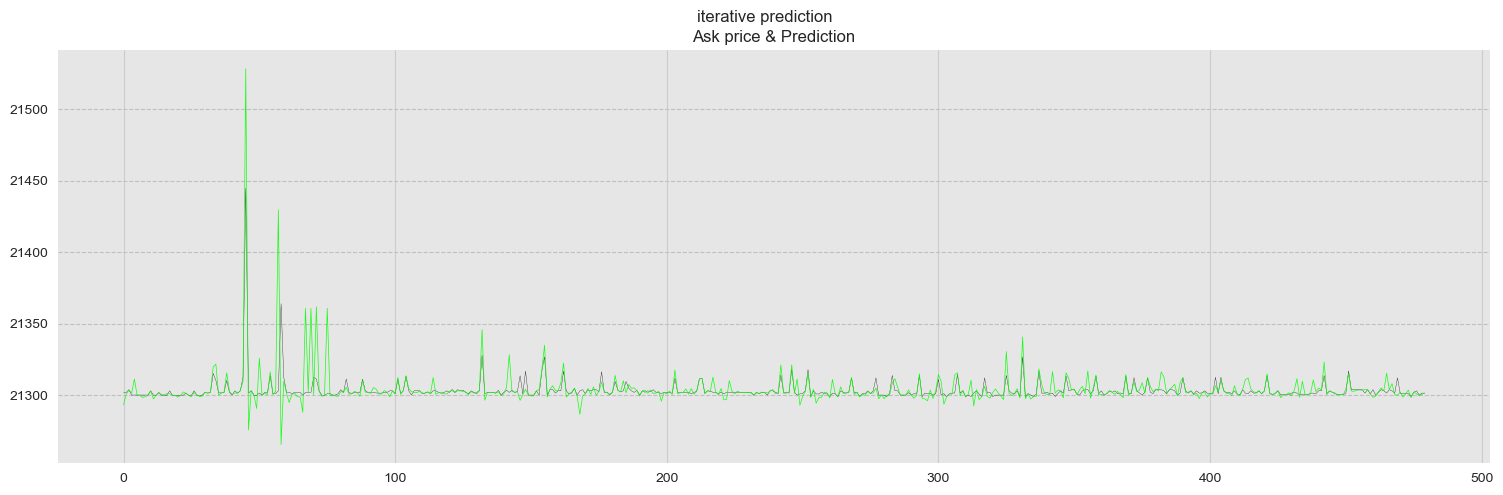

In [41]:
fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('iterative prediction')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('Ask price & Prediction')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, results.shape[0]), results.ask_price, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, results.shape[0]), results.ask_price_pred, '-', color="lime", alpha=0.9, linewidth=0.5)

plt.show()

In [21]:
x = []
steps_ahead = 5
#size = 20
training_data = None
#delta_preds = []
#ask_price_preds = []
#ask_price_preds = {"20": [], "50": [], "100": [], "150": [], "200": []}
#delta_preds = {"20": [], "50": [], "100": [], "150": [], "200": []}
#training_preds_time = {"20": [], "50": [], "100": [], "150": [], "200": []}
ask_price_preds_ahead = {"5": [], "10": [], "20": [], "50": [], "100": [], "150": [], "200": []}
delta_preds_ahead = {"5": [], "10": [], "20": [], "50": [], "100": [], "150": [], "200": []}
training_preds_time_ahead = {"5": [], "10": [], "20": [], "50": [], "100": [], "150": [], "200": []}
#[20, 50, 100, 150, 200]
for size in [5, 10, 20, 50, 100, 150, 200]:
    for index, row in df.iterrows():
        x, is_ready = get_data(row['ask_price'], x, size)
        if is_ready:
            if (len(df) - size) <= len(ask_price_preds_ahead[str(size)]):
                break
            start = time.time()
            training_data = prepare_training_data(x)
            xx_train = training_data['t'].values.reshape(size, 1)
            yy_train = training_data['delta'].values.reshape(size, 1)
            gp4.fit(xx_train, yy_train)
            end = time.time()
            xx = np.arange(size , size + steps_ahead, 1)
            xx = xx.reshape(-1, 1)
            delta_pred, std_dev = gp4.predict(xx, return_std=True)
            delta_preds_ahead[str(size)].extend(delta_pred)
            ask_price_pred = (delta_pred / 10000 + 1) * row['ask_price']
            ask_price_preds_ahead[str(size)].extend(ask_price_pred)
            training_preds_time_ahead[str(size)].append(end - start)
            print(index, delta_pred, ask_price_pred, end - start)

    x = []

/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


5 [ 4.59417433 -5.89962527  0.00989194 -0.2012417   4.23918477] [21309.85562347 21287.50375687 21300.09106989 21299.64135376
 21309.09949324] 1.7512648105621338


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


6 [-2.43158091  0.08454719  0.50636264  1.52142628 -2.1310116 ] [21297.12017339 21302.48010496 21303.3786689  21305.5409879
 21297.76045517] 0.8099122047424316


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


7 [-1.06587191 -1.06587191 -1.06587191 -1.06587191 -1.06587191] [21299.92945833 21299.92945833 21299.92945833 21299.92945833
 21299.92945833] 0.5965659618377686


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


8 [3.532242   2.64567246 2.35928724 2.31657985 2.31350625] [21320.98842986 21319.09884342 21318.48845742 21318.39743319
 21318.39088228] 0.7852051258087158


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


9 [-0.91235406 -0.91235291 -0.91235291 -0.91235291 -0.91235291] [21299.9565125  21299.95651495 21299.95651495 21299.95651495
 21299.95651495] 0.7475249767303467


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10 [-1.83542384  0.61478974  1.176034   -1.75468521  0.08536819] [21299.0899966  21304.30968659 21305.50530523 21299.26199409
 21303.18185985] 0.9912848472595215


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


11 [ 0.44158439 -0.58371338  3.2246463  -3.44493148  3.38605113] [21302.74065423 21300.55658543 21308.66907705 21294.46167587
 21309.01289839] 0.8202521800994873


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


12 [18.41732266 12.9950992   9.67729586  8.52064351  8.26590618] [21390.75361757 21379.17639508 21372.09241052 21369.62279235
 21369.07889171] 1.3093950748443604


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13 [-4.64742189 -4.6474208  -4.6474208  -4.6474208  -4.6474208 ] [21291.90015484 21291.90015716 21291.90015716 21291.90015716
 21291.90015716] 0.7137560844421387
14 [-2.05558406  0.14684151  0.733995   -0.65026939  0.13864956] [21298.62098927 21303.31281647 21304.56362955 21301.61473113
 21303.29536515] 0.9513671398162842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15 [0.1234977 0.1234977 0.1234977 0.1234977 0.1234977] [21303.26308715 21303.26308716 21303.26308716 21303.26308716
 21303.26308716] 0.834845781326294


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

16 [-5.08635958 -5.08635967 -5.08635967 -5.08635967 -5.08635967] [21289.23601848 21289.2360183  21289.2360183  21289.2360183
 21289.2360183 ] 1.0112810134887695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


17 [ 0.00981024 -1.28930377  0.82131388  0.70447761  0.01043696] [21301.92089767 21299.15353801 21303.64955461 21303.40067115
 21301.9222327 ] 1.1369297504425049


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


18 [-1.0707895   0.70309838  0.4309943   0.68805239 -0.50308373] [21300.71889712 21304.49781049 21303.91814715 21304.46575802
 21301.92828072] 1.3265600204467773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


19 [2.89662492e-05 2.89662498e-05 2.89662498e-05 2.89662498e-05
 2.89662498e-05] [21303.00006171 21303.00006171 21303.00006171 21303.00006171
 21303.00006171] 0.8727407455444336


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

20 [-0.26861332  0.01057342  0.13300886  0.13234294  0.09981337] [21301.32780259 21301.92252339 21302.18333415 21302.18191561
 21302.11262144] 2.7662999629974365


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

21 [-0.17377914  0.2065147   0.01182048 -0.19576646  0.2005763 ] [21301.52981742 21302.33991555 21301.92517987 21301.48298024
 21302.32726564] 1.087585210800171


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22 [ 0.04420773 -0.51245741 -0.03428787  0.85282571  0.9151466 ] [21303.89417927 21302.70827098 21303.72695381 21305.61684285
 21305.74961001] 2.131978988647461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may fin

23 [-0.8300234  -0.63033507 -0.62710966 -0.62710614 -0.62710614] [21298.29204518 21298.71738253 21298.72425267 21298.72426017
 21298.72426017] 1.4282522201538086


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

24 [-1.30540925  0.19907051 -0.7907171  -0.59337843  0.70276961] [21297.27947047 21300.48402137 21298.37576783 21298.79610038
 21301.5569035 ] 1.2186481952667236


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25 [-0.81788508 -0.10576478 -0.10766917 -0.27059394 -0.22270708] [21298.30790069 21299.82472048 21299.82066412 21299.47363354
 21299.57563281] 0.7653958797454834
26 [-0.36143968 -0.36143968 -0.36143968 -0.36143968 -0.36143968] [21299.23013347 21299.23013347 21299.23013347 21299.23013347
 21299.23013347] 0.9080977439880371


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

27 [0.00644923 0.00376903 0.00375588 0.00375588 0.00375588] [21300.0637369  21300.05802805 21300.05800005 21300.05800005
 21300.05800005] 1.943289041519165


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28 [-0.00281688 -0.00281688 -0.00281688 -0.00281688 -0.00281688] [21300.03400003 21300.03400003 21300.03400003 21300.03400003
 21300.03400003] 1.2495720386505127


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29 [-0.00244167 -0.00081497 -0.00097575 -0.00094043 -0.00094283] [21300.03479924 21300.03826411 21300.03792164 21300.03799688
 21300.03799178] 1.3782541751861572


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


30 [0.83663778 0.59994978 0.56207751 0.55968159 0.55962395] [21304.78228947 21304.27807302 21304.19739372 21304.1922897
 21304.19216689] 1.6749351024627686


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


31 [-0.28067335 -0.28067315 -0.28067315 -0.28067315 -0.28067315] [21299.43216492 21299.43216535 21299.43216535 21299.43216535
 21299.43216535] 0.7925598621368408


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32 [-0.01967953 -0.01967953 -0.01967953 -0.01967953 -0.01967953] [21299.88808273 21299.88808273 21299.88808273 21299.88808273
 21299.88808273] 0.9505729675292969


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


33 [-1.21273252 -0.00543438  0.86546467  0.9922554  -1.13335595] [21299.31664932 21301.88842374 21303.7436042  21304.01369254
 21299.48573649] 1.3349730968475342


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

34 [ 0.90315118 -0.03836034 -1.38333688  0.26833601  0.75011186] [21301.85370569 21299.84829274 21296.98350214 21300.50155382
 21301.527733  ] 1.0559630393981934


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35 [-0.00937255 -0.00937255 -0.00937255 -0.00937255 -0.00937255] [21299.91003653 21299.91003653 21299.91003653 21299.91003653
 21299.91003653] 1.152562141418457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

36 [-0.1574813  -0.01291465  0.88751305 -0.89250763 -0.00094008] [21299.59456594 21299.90249188 21301.82039658 21298.028965
 21299.92799763] 1.1927778720855713


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


37 [2.36773846 1.68648112 1.99151539 0.9676771  1.2359113 ] [21308.04399323 21306.59271074 21307.24252524 21305.06144253
 21305.63286183] 1.4892621040344238


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38 [-0.29005858 -0.29005844 -0.29005844 -0.29005844 -0.29005844] [21299.30217755 21299.30217784 21299.30217784 21299.30217784
 21299.30217784] 0.8506460189819336


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


39 [-0.00089729 -0.00089729 -0.00089729 -0.00089729 -0.00089729] [21299.91808877 21299.91808877 21299.91808877 21299.91808877
 21299.91808877] 0.8427488803863525


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 [-0.00089729 -0.00089729 -0.00089729 -0.00089729 -0.00089729] [21299.91808877 21299.91808877 21299.91808877 21299.91808877
 21299.91808877] 0.7082641124725342


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


41 [-0.28916115 -0.28916115 -0.28916115 -0.28916115 -0.28916115] [21299.30408906 21299.30408906 21299.30408906 21299.30408906
 21299.30408906] 0.8606312274932861


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


42 [0.02346209 0.01650034 0.01514144 0.01502733 0.01502388] [21300.04997426 21300.03514571 21300.03225127 21300.03200821
 21300.03200086] 1.7183709144592285


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


43 [0.50649572 0.26890223 0.32569523 0.22836157 0.31773675] [21302.47890678 21301.9727994  21302.09377644 21301.88644211
 21302.07682376] 1.0721299648284912


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44 [-0.20768626 -0.1577727  -0.15772695 -0.15772695 -0.15772695] [21299.377632   21299.483947   21299.48404444 21299.48404444
 21299.48404444] 1.5909738540649414


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45 [-0.30893226  0.02261166 -0.04552614 -0.05849954  0.01036395] [21299.26197676 21299.96816265 21299.82302968 21299.79539646
 21299.94207513] 1.2343077659606934


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


46 [-0.17681251 -0.61351478  0.7836506   1.69981588  0.74202972] [21302.62333631 21301.69302945 21304.66941087 21306.62111776
 21304.58074591] 1.353360891342163


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47 [ 0.40052636 -1.35988678 -0.78712058  0.87544717 -1.21295605] [21300.67311394 21296.92346563 21298.14344733 21301.68468672
 21297.23642546] 1.1661808490753174


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48 [4.32147833e-05 4.32147835e-05 4.32147835e-05 4.32147835e-05
 4.32147835e-05] [21299.82009205 21299.82009205 21299.82009205 21299.82009205
 21299.82009205] 0.7319962978363037


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


49 [0.02445657 0.02445657 0.02445657 0.02445657 0.02445657] [21300.05209249 21300.05209249 21300.05209249 21300.05209249
 21300.05209249] 0.7311668395996094


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 [0.07515956 0.07515956 0.07515956 0.07515956 0.07515956] [21302.06010415 21302.06010415 21302.06010415 21302.06010415
 21302.06010415] 0.8097858428955078


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


51 [ 0.08358685  0.77413704 -0.18425564 -0.14334691  0.08632544] [21301.5780517  21303.04902027 21301.00750969 21301.09465102
 21301.58388527] 0.9599213600158691


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


52 [0.22463996 0.2536251  0.2427999  0.24292967 0.24288141] [21302.3785258  21302.44026966 21302.41720991 21302.41748636
 21302.41738354] 1.3477518558502197


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

53 [3.50817902 2.73460744 2.65977904 2.65708908 2.65705691] [21322.57771867 21320.92884311 21320.76934562 21320.76361194
 21320.76354338] 0.7125129699707031


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


54 [ 4.84403074 -1.85230724 -1.92204918  3.44955514 -1.43620969] [21320.63277967 21306.36267585 21306.21405362 21317.66110893
 21307.24939264] 0.8800032138824463


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

55 [-1.42233016 -0.80490914 -0.79807388 -0.79806997 -0.79806997] [21298.57020919 21299.88541475 21299.89997494 21299.89998328
 21299.89998328] 0.9420421123504639


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


56 [-0.0463432 -0.0463432 -0.0463432 -0.0463432 -0.0463432] [21301.40128203 21301.40128203 21301.40128203 21301.40128203
 21301.40128203] 0.8801720142364502


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again m

57 [-0.88711455 -1.19577181 -1.20115999 -1.20116656 -1.20116656] [21300.01027746 21299.35277886 21299.341301   21299.34128701
 21299.34128701] 0.9894030094146729


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a b

58 [6.10634247 4.54199492 4.88867616 2.34614669 1.64731611] [21323.32280509 21319.98913198 21320.72792044 21315.30971133
 21313.82048169] 1.3153431415557861
59 [-0.8264729  -0.76081332 -0.76081063 -0.76081063 -0.76080358] [21300.13945568 21300.27932307 21300.27932881 21300.27932881
 21300.27934382] 1.0980448722839355


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60 [-0.31890803 -0.31890803 -0.31890803 -0.31890803 -0.31890803] [21299.32072589 21299.32072589 21299.32072589 21299.32072589
 21299.32072589] 0.6654038429260254


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


61 [0.38530406 0.38530405 0.38530405 0.38530405 0.38530405] [21303.82081323 21303.82081322 21303.82081322 21303.82081322
 21303.82081322] 0.6255359649658203


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. D

62 [-0.59932906 -0.92575318 -0.98432441 -0.98636649 -0.98645789] [21300.1233452  21299.42801613 21299.30325119 21299.29890129
 21299.29870658] 1.816573143005371


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


63 [0.26463978 0.88812855 0.23815008 0.39642814 0.25220358] [21303.56376213 21304.89198024 21303.50733111 21303.84451087
 21303.5372693 ] 1.342250108718872


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

64 [2.80302243 2.15661862 2.10166763 2.10444091 2.10490703] [21318.68400042 21317.30633873 21317.18922328 21317.19513388
 21317.19612732] 1.1167280673980713


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65 [42.91563511 29.90944264 26.25505444 25.74680748 25.70957541] [21536.86184992 21508.97029129 21501.1335179  21500.04359094
 21499.9637474 ] 1.5492401123046875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

66 [-17.69376213 -13.2967356  -13.29323223 -13.29323221 -13.29323221] [21263.70980954 21273.07609163 21273.08355429 21273.08355434
 21273.08355434] 1.2460699081420898


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


67 [0.23364335 0.23364335 0.23364335 0.23364335 0.23364335] [21303.49773043 21303.49773042 21303.49773042 21303.49773042
 21303.49773042] 0.9844272136688232


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68 [-1.42528922 -1.42528921 -1.42528921 -1.42528921 -1.42528921] [21296.78415963 21296.78415963 21296.78415963 21296.78415963
 21296.78415963] 0.6591939926147461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


69 [-13.52497532 -13.52497532 -13.52497532 -13.52497532 -13.52497532] [21271.01204601 21271.01204601 21271.01204601 21271.01204601
 21271.01204601] 0.8775560855865479


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70 [0.16717099 0.16717099 0.16717099 0.16717099 0.16717099] [21301.85609929 21301.85609929 21301.85609929 21301.85609929
 21301.85609929] 0.6858768463134766


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


71 [-0.422472   -0.42247199 -0.42247199 -0.42247199 -0.42247199] [21299.10013463 21299.10013465 21299.10013465 21299.10013465
 21299.10013465] 0.6817097663879395


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


72 [0.37372017 0.37372017 0.37372017 0.37372017 0.37372017] [21302.69609497 21302.69609497 21302.69609497 21302.69609497
 21302.69609497] 0.7768597602844238


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


73 [0.19531641 0.19531642 0.19531642 0.19531642 0.19531642] [21302.31606107 21302.31606107 21302.31606107 21302.31606107
 21302.31606107] 0.7674939632415771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


74 [4.0634659  3.02205212 2.42790818 2.24134753 2.2054761 ] [21322.08063554 21319.86102661 21318.59470268 21318.19707812
 21318.12062384] 0.9873149394989014


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [-1.16855027 -1.07093445 -1.07092836 -1.07092836 -1.07092836] [21298.51087106 21298.71880252 21298.71881551 21298.71881551
 21298.71881551] 1.1955547332763672
76 [ 5.31913109e+00 -5.73446421e+00 -1.38424436e-03 -6.97682948e-04
  5.31913112e+00] [21312.33028114 21288.78501778 21300.99705142 21300.99851387
 21312.33028121] 0.8785457611083984
77 [-1.1922902   0.22095659  0.44866525  1.40700026 -1.18108961] [21300.46006419 21303.47070383 21303.95579159 21305.99733266
 21300.48392481] 0.8146069049835205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


78 [23.0836593  16.19655057 12.15808057 10.80608059 10.51973835] [21413.31416566 21398.60054778 21389.97276119 21387.08434867
 21386.47260715] 0.8334448337554932


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


79 [-3.74627239 -3.74627112 -3.74627112 -3.74627112 -3.74627112] [21304.41579443 21304.41579714 21304.41579714 21304.41579714
 21304.41579714] 0.7574470043182373


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80 [-0.88656314 -0.88656314 -0.88656314 -0.88656314 -0.88656314] [21300.01145206 21300.01145206 21300.01145206 21300.01145206
 21300.01145206] 0.6481461524963379


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


81 [-0.08900588 -0.08900589 -0.08900589 -0.08900589 -0.08900589] [21301.71040055 21301.71040055 21301.71040055 21301.71040055
 21301.71040055] 0.5981431007385254


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

82 [-3.57217412 -5.54302819 -5.94831791 -5.98002079 -5.98097675] [21293.41090475 21289.21278458 21288.34947612 21288.28194575
 21288.27990945] 0.9553570747375488


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


83 [-0.9027133 -0.9027133 -0.9027133 -0.9027133 -0.9027133] [21299.97704915 21299.97704915 21299.97704915 21299.97704915
 21299.97704915] 1.25797700881958


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84 [3.41331695e-06 3.41331696e-06 3.41331696e-06 3.41331696e-06
 3.41331696e-06] [21301.90000727 21301.90000727 21301.90000727 21301.90000727
 21301.90000727] 0.7681007385253906


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85 [3.41331695e-06 3.41331696e-06 3.41331696e-06 3.41331696e-06
 3.41331696e-06] [21301.90000727 21301.90000727 21301.90000727 21301.90000727
 21301.90000727] 0.6918017864227295


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


86 [-0.81223176 -0.62885122 -0.44874731 -0.33978902 -0.29323504] [21298.26994636 21298.6605469  21299.04416823 21299.27624939
 21299.37540936] 1.5104761123657227


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


87 [0.17841967 0.17841967 0.17841967 0.17841967 0.17841967] [21302.2800678  21302.28006779 21302.28006779 21302.28006779
 21302.28006779] 0.5870819091796875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

88 [-8.84851562e-01  8.84930747e-01  1.27186352e-07  6.24259063e-08
 -8.84851559e-01] [21300.01509805 21303.78507063 21301.90000027 21301.90000013
 21300.01509806] 1.3780598640441895


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


89 [1.59125306e-05 1.59125306e-05 1.59125306e-05 1.59125306e-05
 1.59125306e-05] [21301.9000339 21301.9000339 21301.9000339 21301.9000339 21301.9000339] 0.6294243335723877


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

90 [2.80740495 2.2053449  2.15148965 2.15006909 2.150063  ] [21318.38325373 21317.10011926 21316.98534081 21316.98231324
 21316.98230028] 1.0160801410675049


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [ 4.83511083 -0.78202249 -0.78202124  4.64381637 -1.0279587 ] [21321.55422556 21309.58341233 21309.58341499 21321.14655316
 21309.05929151] 0.87030029296875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

92 [-1.71979823 -0.73744245 -0.6713059  -0.67058013 -0.67057878] [21299.33631383 21301.42902635 21301.56991704 21301.57146315
 21301.57146602] 1.1282198429107666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

93 [-1.76290585 -0.90746344 -0.51200545 -0.46195581 -0.45964737] [21296.24501053 21298.06710286 21298.9094284  21299.01603413
 21299.0209511 ] 1.1078002452850342


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha


94 [-1.1976105  -1.19761064 -1.19761064 -1.19761064 -1.19761064] [21297.26911118 21297.26911089 21297.26911089 21297.26911089
 21297.26911089] 0.6311748027801514


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

95 [ 0.36668473  0.21126988  0.04656023 -0.16956712 -0.40697792] [21301.78107513 21301.45002598 21301.09917795 21300.63880507
 21300.13309632] 1.8380463123321533


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

96 [ 0.08185632 -0.08361001 -0.17049023 -0.1832725  -0.18398097] [21301.19436231 21300.84190215 21300.65683842 21300.62961089
 21300.62810177] 1.1915640830993652


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

97 [ 0.33705501  0.38060565 -0.26954741 -0.55712703 -0.12155474] [21300.74792818 21300.84069118 21299.4558632  21298.84331775
 21299.77108803] 0.9393758773803711


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

98 [-0.01939549  0.01786767  0.02154803  0.02160141  0.02160154] [21299.99868752 21300.07805822 21300.08589739 21300.08601108
 21300.08601137] 1.752802848815918


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

99 [0.24229767 0.11241425 0.09114722 0.09015842 0.09014492] [21301.51611828 21301.23945359 21301.1941527  21301.19204645
 21301.1920177 ] 0.9213109016418457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


100 [1.19473129 0.89537612 0.66420757 0.55557349 0.52469219] [21306.34523165 21305.70749138 21305.21501452 21304.98358264
 21304.91779375] 1.023500919342041


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


101 [-0.13529455 -0.00370568 -0.00276602 -0.00276577 -0.00276577] [21301.6117969  21301.89210619 21301.89410785 21301.89410838
 21301.89410838] 1.1993601322174072


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

102 [2.20087959 1.93653605 1.93601245 1.93601243 1.93601243] [21315.97035613 21315.40700621 21315.40589033 21315.4058903
 21315.4058903 ] 2.4550020694732666
103 [-0.7933634  -0.79544164 -0.79042455 -0.79875066 -0.79883842] [21300.20998523 21300.20555817 21300.21624553 21300.19850933
 21300.19832239] 0.6269218921661377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10 [-0.52435142  4.69790366 -4.81365845  1.23089055  0.84569424] [21301.88297416 21313.00794417 21292.74546341 21305.62216613
 21304.80158245] 1.3602690696716309
11 [ 5.11253532 -5.23700072  0.50255371 -0.56979748 -0.55525902] [21312.69062048 21290.6442458  21302.87052987 21300.58622881
 21300.61719834] 0.7217490673065186


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


12 [14.23815511 11.76631831  2.45942542  6.2058037  -0.91289016] [21381.83049722 21376.55277217 21356.68122497 21364.68027834
 21349.48084897] 1.620959997177124


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13 [-2.23797608 -2.23797608 -2.23797608 -2.23797608 -2.23797608] [21297.03270812 21297.03270812 21297.03270812 21297.03270812
 21297.03270812] 0.7492890357971191


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


14 [ 5.34394729 -5.47973269  0.51533482 -0.55626595 23.14005238] [21314.38421092 21291.32652545 21304.09781778 21301.81498664
 21352.29525358] 1.2575860023498535


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15 [-7.16577339  0.27002904 -0.12183973  5.71580273 -7.16390138] [21287.73475294 21303.57524286 21302.74044482 21315.17637456
 21287.73874088] 0.6340320110321045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16 [ 3.87148655 -4.09293025  0.32459729 -0.47833114 17.26692493] [21308.31629346 21291.35202992 21300.76139451 21299.05115133
 21336.84867097] 0.9205660820007324


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


17 [ 2.28265005e+01 -2.27910270e+01  5.43330254e-01 -8.80280714e-03
 -3.36580989e+00] [21350.5247832  21253.35078215 21303.05739667 21301.88124835
 21294.73018544] 1.2094006538391113


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

18 [-5.57328979e-01  2.30913549e+01 -2.30358009e+01  5.59242302e-01
  9.40936862e-04] [21301.81272208 21352.19151334 21253.9268334  21304.19135388
 21303.00200448] 1.5859158039093018


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


19 [-4.17497617e-01  1.73269821e+01 -1.72839241e+01  4.20306996e-01
  1.39289059e-03] [21302.11060483 21339.91166996 21266.18005645 21303.89537999
 21303.00296727] 0.6914839744567871


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20 [ 1.73152366e+01 -1.72962453e+01  4.08280274e-01 -1.06407990e-02
 -1.03344880e+00] [21338.78474384 21265.05571117 21302.76971456 21301.87733308
 21299.6985577 ] 0.9111769199371338
21 [-2.31972264 -2.31972264 -2.31972264 -2.31972264 -2.31972264] [21296.95855002 21296.95855002 21296.95855002 21296.95855002
 21296.95855002] 0.6039707660675049


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

22 [-1.01445829  0.22065686  0.39385226  0.499334   -0.13676963] [21301.63881834 21304.27008297 21304.63905498 21304.86377116
 21303.50862872] 1.0408082008361816


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


23 [ 0.11610852  0.27405558 -0.49386169 -0.91640595  0.11610622] [21300.30731184 21300.64374002 21299.00807164 21298.10804982
 21300.30730695] 1.5826890468597412
24 [-0.13841868 -0.13985207 -0.13669207 -0.13560226 -0.14320062] [21299.76516738 21299.76211425 21299.76884507 21299.77116637
 21299.75498183] 0.589601993560791


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25 [ 0.00228389 -0.03428855  0.05709758  0.01776791  0.00937282] [21300.05486469 21299.97696521 21300.17161814 21300.08784575
 21300.06996415] 1.1111979484558105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26 [ 0.02498597  0.74641722 -1.47429527 -0.00770784  0.29813551] [21300.05322011 21301.58986867 21296.85975107 21299.98358231
 21300.63502864] 1.74428391456604


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


27 [-0.42400181 -0.07106866  0.05552051 -0.42400181 -0.07106866] [21299.14687402 21299.8986234  21300.16825897 21299.14687403
 21299.8986234 ] 0.930124044418335


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28 [-0.41973903 -0.03573236  0.62758615 -1.34130602 -0.03573236] [21299.14595418 21299.96388993 21301.376761   21297.18301281
 21299.96388993] 0.8292560577392578


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29 [-0.66365641 -0.0571514  -0.05877336 -0.06526119 -0.0490416 ] [21298.62640919 21299.91826728 21299.91481251 21299.90099341
 21299.93554119] 1.052623987197876


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30 [0.26544923 0.19071681 0.19063432 0.19084706 0.19012473] [21303.56548649 21303.40628401 21303.40610829 21303.4065615
 21303.40502271] 0.9888970851898193


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better val

31 [-0.17801279 -0.18634857 -0.1655091  -0.1780128  -0.17592885] [21299.65083222 21299.63307698 21299.67746511 21299.65083221
 21299.65527102] 0.8746109008789062


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32 [-0.00276311 -0.00625442 -0.02021967  0.01469349 -0.00625443] [21299.92411459 21299.91667812 21299.88693224 21299.96129703
 21299.91667812] 0.733083963394165


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


33 [0.03362805 0.01876881 0.05591694 0.03362805 0.03734285] [21301.97163413 21301.93998113 21302.01911371 21301.97163413
 21301.97954738] 0.668226957321167


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

34 [ 0.52313178 -0.02151478  0.12714793 -0.10078846  0.02334573] [21301.04426702 21299.88417366 21300.2008242  21299.71532128
 21299.97972625] 0.9093427658081055


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35 [-0.00663251  1.3624511  -1.36999956 -0.0460136   0.94084494] [21299.91587279 21302.8320113  21297.01191052 21299.83199135
 21301.93399313] 0.9985089302062988


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

36 [ 1.3785784  -1.38313387 -0.04662022  0.91748947 -0.91749478] [21302.86636234 21296.98393454 21299.83069925 21301.88424615
 21297.97574254] 1.119661808013916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


37 [-0.46404448  0.13608697  0.56899878 -0.2549597   0.15700049] [21302.01144605 21303.28990607 21304.21213811 21302.45685936
 21303.33445815] 1.2661411762237549


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38 [ 1.02728227 -1.05654462 -0.03104789  0.1985303   0.70168988] [21302.10810301 21297.66956842 21299.85386824 21300.34286795
 21301.41459382] 0.9064509868621826


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


39 [-1.07387677 -0.07196535  0.65077513 -0.72481253 -0.0370505 ] [21297.63265107 21299.76671439 21301.30614583 21298.37615511
 21299.84108273] 0.8742327690124512


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 [-0.00689984 -0.00512726 -0.00515851 -0.00335547 -0.00689984] [21299.90530339 21299.90907897 21299.90901242 21299.91285289
 21299.9053034 ] 1.1729369163513184
41 [-0.01044996  0.45426345 -0.33226248 -0.11336447 -0.01890559] [21299.89774167 21300.88757751 21299.21228357 21299.67853459
 21299.87973125] 0.6427252292633057


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

42 [ 0.02959747 -0.3225659   1.45612455 -1.13550859 -0.02611301] [21300.06304262 21299.31293464 21303.1015453  21297.5813667
 21299.94437928] 1.0351788997650146


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


43 [ 0.03453957  0.03453957  1.10644968 -1.04070712  0.03453957] [21301.47357413 21301.47357413 21303.75689273 21299.18314814
 21301.47357413] 0.8243482112884521
44 [-0.07931188 -0.07931228 -0.07931208 -0.07931207 -0.07931185] [21299.65106711 21299.65106627 21299.65106669 21299.65106672
 21299.65106719] 0.9482967853546143


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45 [ 1.07292481 -1.07408158  0.00108979  0.00108979  0.00108979] [21302.20532127 21297.63221482 21299.92232124 21299.92232124
 21299.92232124] 0.7552070617675781


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

46 [0.19841883 0.13493062 0.40787217 0.29071908 0.04275818] [21303.42269164 21303.2874427  21303.86889008 21303.61931886
 21303.09108775] 1.5846149921417236


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47 [-0.0754736  -0.21299933 -0.19087811 -0.09674528 -0.19835795] [21299.6592426  21299.36631526 21299.41343305 21299.6139343
 21299.39750115] 0.9963710308074951


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48 [ 0.01259275  0.65007834 -0.74057035  0.05534265  1.42443299] [21299.84682233 21301.20465517 21298.24259849 21299.93787884
 21302.85401663] 0.7813940048217773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


49 [ 0.63950448 -0.72911175  0.05509612  1.43829941 -1.48493066] [21301.36214455 21298.44699198 21300.11735473 21303.06357775
 21296.83709769] 1.2688319683074951


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 [ 0.07186855  0.54457193 -0.52255481  0.07903092  1.14619869] [21302.05309368 21303.06004169 21300.78685897 21302.06835088
 21304.341621  ] 0.6569638252258301
51 [0.04228426 0.04228426 0.04228426 0.04228426 0.04228426] [21301.4900714 21301.4900714 21301.4900714 21301.4900714 21301.4900714] 0.5689389705657959


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

52 [0.25601477 0.51968091 0.05766092 0.24973246 0.04351248] [21302.4453601  21303.00701907 21302.02282872 21302.43197759
 21301.99268985] 1.714278221130371


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

53 [6.17454066 3.20344534 2.54631037 1.35433234 0.27845998] [21328.26109516 21321.92817577 21320.52748602 21317.98677293
 21315.69354024] 1.2234272956848145
54 [0.21054366 0.44848622 0.11647922 0.25480732 1.88291979] [21310.75867506 21311.26573804 21310.55822082 21310.8530023
 21314.32256045] 0.9327518939971924


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

55 [-0.02756445 -0.12914398  0.54786928  0.54223058 -0.80508361] [21301.54128331 21301.32490265 21302.76704922 21302.7550379
 21299.88504309] 1.3050689697265625


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

56 [ 0.88552769 -0.23225329  0.23346136  6.14796257 -2.22876425] [21303.38630681 21301.00526565 21301.99730772 21314.59608247
 21296.75239784] 0.8963661193847656
57 [0.11730862 0.11650438 0.11638358 0.11730821 0.11650447] [21302.14988965 21302.14817647 21302.14791914 21302.14988878
 21302.14817666] 0.6929972171783447


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


58 [-5.32866528 -0.16003592 -0.61423531 -0.32466682  6.28800839] [21298.95444911 21309.96895849 21309.00104552 21309.61812495
 21323.70994082] 1.549180030822754


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


59 [-0.14602985  0.18498891  4.78420868 -3.03291292 -3.86359641] [21301.58892867 21302.29406152 21312.09127349 21295.43931923
 21293.66980556] 0.7657289505004883


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60 [ 0.16840452  4.43709007 -2.78223324 -2.17403166 -0.44537933] [21300.35870163 21309.45100185 21294.07384319 21295.36931257
 21299.05134204] 0.6653270721435547


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


61 [ 0.14989372 -3.50929684  0.94056164  3.82993324  1.26967   ] [21303.3193186  21295.52414494 21305.00367846 21311.15890678
 21305.70477799] 0.714540958404541


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

62 [-4.39191683 -0.16527959  0.81207105  3.51380493 -3.81375646] [21292.04460228 21301.04793134 21303.12982503 21308.88489643
 21293.27616482] 1.027318000793457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


63 [ 2.16673062 -2.38770343 -0.62549482  0.70165019 -1.55393497] [21307.61578624 21297.91347538 21301.6675084  21304.49472541
 21299.68965233] 1.0465030670166016
64 [-1.13653353  0.54695708  1.67813682 -0.03265059  0.6947833 ] [21310.28773904 21313.87571376 21316.28656434 21312.64041273
 21314.1907715 ] 1.5599348545074463


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


65 [41.85218264 22.49173963 14.791563   13.14788902 12.94145186] [21534.58129418 21493.06315327 21476.55025539 21473.02542448
 21472.58272351] 1.0521669387817383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

66 [-13.80166064  -6.68974924  -6.6699612   -6.66996004  -6.66996005] [21272.00053061 21287.14989756 21287.19204884 21287.19205132
 21287.1920513 ] 0.8982951641082764


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

67 [ 1.39550881 -0.74681666  0.74341579  4.52002587 61.49590256] [21305.97285242 21301.40905646 21304.58369867 21312.62901112
 21434.00472123] 1.5578880310058594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

68 [  0.74448197   4.52486917  61.5577295  -66.41852513  -0.07087352] [21301.4057332  21309.45788987 21430.9368558  21158.34973702
 21299.66904068] 0.736732006072998


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


69 [ 1.05592787 -0.54999948  0.56710671  3.39812445 46.10831005] [21302.06910735 21298.64851101 21301.02792709 21307.05794391
 21398.02987046] 0.6304798126220703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

70 [  4.52213083  61.49823346 -66.35066229   0.74550578  -1.48051015] [21311.13281699 21432.500462   21160.16313672 21303.08803913
 21298.34629131] 0.7507078647613525


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


71 [ 60.55819662 -67.25199582  -0.1019517   -2.25540455  -0.68775776] [21428.98895879 21156.75324891 21299.78284287 21295.1959883
 21298.53507596] 1.237656831741333


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

72 [ 6.14366470e+01 -6.62838911e+01  7.44913813e-01 -1.47886724e+00
  5.14759752e-04] [21432.77173114 21160.70271798 21303.48680796 21298.7497318
 21301.90109654] 0.8948459625244141


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


73 [ 45.97906063 -49.85574083   0.43916323  -1.22944559  -0.11939483] [21399.84413516 21195.69779944 21302.83550112 21299.28104731
 21301.64566633] 0.7859420776367188


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


74 [-5.53093228 -5.54332716 -5.5812572  -5.58125667 -5.58322348] [21301.63169174 21301.60527401 21301.52443211 21301.52443325
 21301.52024131] 0.7436668872833252


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [-0.37848164 -0.61381525 -0.36220142 -0.50281398  0.33998276] [21300.19379626 21299.69251215 21300.22847475 21299.92895594
 21301.72419727] 1.5468816757202148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76 [ 1.53064121 -1.72738639 -0.43394089 -0.1957928   1.39206935] [21304.26041884 21297.32049424 21300.07566251 21300.58294175
 21303.96524692] 1.2085456848144531


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

77 [ 0.32833946 -0.08667754  4.85107883 -5.91807789  0.31049756] [21303.69946154 21302.81535083 21313.33425324 21290.39271867
 21303.66145295] 0.9972097873687744


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

78 [36.07347926 16.74668297 17.55102248  5.01458897 10.47495274] [21441.06561475 21399.77585055 21401.49424134 21374.71140699
 21386.37692718] 1.3358850479125977


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


79 [-0.95351053  0.30883332 -0.39661604  3.8802533  -5.00512353] [21310.36784022 21313.05819792 21311.55471603 21320.66975104
 21301.73288052] 0.765211820602417
80 [-0.39566648 -0.39630168 -0.39605596 -0.39603412 -0.39566708] [21301.05715523 21301.05580212 21301.05632555 21301.05637207
 21301.05715395] 0.6430068016052246


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


81 [ 5.25959182e+00 -5.66698789e+00  2.14004899e-04  9.13339009e-01
  2.78471085e+01] [21313.10392989 21289.82823906 21301.90045587 21303.84558562
 21361.21963205] 1.1291570663452148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


82 [ 4.00244928e+00 -4.35283820e+00 -1.92679237e-02  6.78976369e-01
  2.12745692e+01] [21309.54562521 21291.74801064 21300.97895736 21302.46628892
 21346.33700244] 0.6749439239501953


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


83 [ -4.45945737  -0.12614574   0.57205687  21.16642045 -18.08604201] [21292.40050851 21301.6312856  21303.11858983 21346.98849719
 21263.37329418] 0.7964150905609131


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

84 [ 9.30983162e-01  2.83783846e+01 -2.39358367e+01 -4.88226909e+00
  4.44695118e-04] [21303.88317102 21362.35135104 21250.91211999 21291.4998392
 21301.90094729] 1.7335050106048584


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85 [ 7.10897049e-01  2.13062440e+01 -1.79480927e+01 -3.65111687e+00
  1.26610941e-02] [21303.41434579 21347.28634784 21263.66715237 21294.12242736
 21301.92697054] 0.9180150032043457


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


86 [ 21.23656624 -18.01798922  -3.72093369  -0.05713531  -0.36434786] [21345.23388609 21261.62168297 21292.07441124 21299.87830179
 21299.22393906] 0.845721960067749


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again m

87 [-1.59859318 -3.45499663 -3.5728471  -3.18097612 -2.93731398] [21298.4946928  21294.54020074 21294.28915683 21295.12391647
 21295.64296314] 1.3878240585327148


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


88 [-4.01796309 -0.1009696  -0.42941278  0.22748714 -0.10096963] [21293.34097521 21301.68491556 21300.9852692  21302.38459082
 21301.68491549] 0.8215081691741943


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


89 [ 0.14118747 -0.14116808  0.14118741 -0.14116808  0.14118741] [21302.20075614 21301.59928517 21302.200756   21301.59928517
 21302.200756  ] 0.7667529582977295


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

90 [2.18293195 1.13050231 0.99237023 0.98593222 0.98582491] [21317.05235189 21314.80937174 21314.51497913 21314.50125817
 21314.50102947] 1.3890330791473389


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [ 0.04682616 -0.74914006  0.84286339  0.18280005  0.11654357] [21311.34979241 21309.65348888 21313.04624724 21311.63956976
 21311.49836892] 1.1556448936462402


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

92 [-1.44818056 -0.3982603  -0.33583766 -0.33527721 -0.33527642] [21299.91494095 21302.15158609 21302.28456504 21302.28575895
 21302.28576064] 0.9517848491668701


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


93 [ 0.62967758  0.23186426 -0.37740941  4.2131102   0.63678473] [21301.34121326 21300.49387088 21299.19611795 21308.97392472
 21301.35635147] 1.5870261192321777


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


94 [-0.76999632  4.49182418 -0.04027819 -3.98792909 -1.56350978] [21298.1799217  21309.38750465 21299.73420818 21291.32578281
 21296.48975231] 0.9091050624847412


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

95 [-0.09637385  0.47270186  4.81538314 -1.21860811 -3.75424861] [21300.79471407 21302.00690222 21311.25724763 21298.40424286
 21293.00307503] 1.1775619983673096


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


96 [ 4.89094365 -0.5357846  -3.84179969 -1.39777341 -0.08419485] [21311.43820886 21299.87872416 21292.83657479 21298.04260007
 21300.84065637] 1.4635891914367676


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


97 [ 4.79557243  0.1389645  -3.86555382 -1.65203594 -0.16198278] [21310.24458367 21300.32599481 21291.79635876 21296.51115849
 21299.6849762 ] 0.9401838779449463


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

98 [-0.19278406 -0.16203638 -0.10295303 -0.08811544 -0.08664626] [21299.62936918 21299.69486187 21299.82070963 21299.85231375
 21299.85544312] 1.0360279083251953


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base**-self.alpha
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


99 [-1.82070974 -0.44836891 -0.16028115  0.0257386  -0.5368498 ] [21297.12170618 21300.04492939 21300.65858513 21301.05482579
 21299.85645624] 1.4487547874450684


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasin

100 [ 0.90978281  0.51341699 -0.12764144 -0.23665956 -0.39020333] [21305.73818311 21304.89377328 21303.52807524 21303.2958252
 21302.96871862] 1.5594558715820312


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

101 [ 0.48541797  0.32682366 -0.36636651 -0.22329407  0.13511637] [21302.93403251 21302.59619648 21301.11956972 21301.42434121
 21302.18782354] 1.3080809116363525


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


102 [1.73991077 0.99982299 0.97016157 0.96977632 0.96968638] [21314.98797256 21313.41075076 21313.34753848 21313.34671747
 21313.3465258 ] 1.6587448120117188


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


103 [ 0.32429499 -0.08073828 -0.43337636 -0.08422959  0.24747495] [21302.59080995 21301.72801213 21300.97682602 21301.72057497
 21302.42716866] 1.3983449935913086


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


104 [-0.00331225 -0.35592891 -0.00680335  0.32488104  0.96725728] [21301.01294457 21300.26183512 21301.00550818 21301.71202976
 21303.08035666] 0.6875400543212891


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

105 [ 1.36444145 -0.97457156  4.3276436  -4.36356375 -0.50209686] [21304.80651953 21299.82397742 21311.11870312 21292.60478013
 21300.83043828] 0.9972736835479736


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a be

106 [ 3.99193004 -4.12252633 -0.6704191   0.52763572 -1.06408315] [21310.40356946 21293.11823563 21300.47187994 21303.02396433
 21299.63330073] 0.8054981231689453


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


107 [ 0.35761364  0.99999398 -0.64082026  3.29711763 -3.25080493] [21302.66178499 21304.03017718 21300.53493108 21308.923487
 21294.97516784] 0.7899439334869385


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20 [-2.29444392  3.17368038 -2.97759896  2.90803905 -2.53059218] [21297.01239851 21308.66054222 21295.55714848 21308.09467571
 21296.50935785] 1.176448106765747


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better val

21 [ 2.23453931e+01 -2.26956891e+01  1.97578194e-02  3.25500299e-01
 -5.66352298e-01] [21349.49993299 21253.55386998 21301.94208791 21302.59337748
 21300.693562  ] 1.1722841262817383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22 [-0.12140462 -0.06881615 -0.13765129 -0.11757388 -0.15917397] [21303.54136203 21303.65339545 21303.50675044 21303.54952296
 21303.46089896] 1.3145482540130615


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


23 [ 1.64322216 -0.10146494  5.72585746 -6.16137346  0.74917455] [21303.56007306 21299.84387907 21312.25611074 21286.93623756
 21301.65574628] 1.5419797897338867


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


24 [ -0.55614622  20.50540326 -20.45762139   0.64085219  -0.14529781] [21298.87540521 21343.73663197 21256.48514369 21301.42501902
 21299.75051478] 1.3469409942626953


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

25 [ 23.58206049 -22.78926497   0.8176031   -0.97361183   4.4998301 ] [21350.27990675 21251.50875166 21301.79149869 21297.97620193
 21309.63466062] 1.5478780269622803
26 [-0.01954274 -0.10399855 -0.04822672 -0.04929809 -0.04848158] [21299.95837397 21299.77848308 21299.89727709 21299.89499507
 21299.89673424] 0.9469606876373291


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


27 [  0.26144482  -0.48544533  16.02130108 -16.17538426   0.293921  ] [21300.60687878 21299.01599903 21334.1754514  21265.59635064
 21300.67605319] 1.054412841796875


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28 [-0.04116707 -0.04116707 -0.04116707 -0.04116707 -0.04116707] [21299.95231397 21299.95231397 21299.95231397 21299.95231397
 21299.95231397] 1.305807113647461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29 [-0.06675162 -0.06675163 -0.06675163 -0.06675163 -0.06675163] [21299.89781878 21299.89781875 21299.89781877 21299.89781877
 21299.89781877] 0.7852768898010254


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30 [-0.04798783  0.13070783  0.08437156  0.089606    0.10156428] [21302.89777152 21303.2784469  21303.17973674 21303.19088766
 21303.21636239] 1.0841987133026123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


31 [-1.27344516 -1.27344515 -1.27344515 -1.27344515 -1.27344515] [21297.31755798 21297.317558   21297.317558   21297.317558
 21297.317558  ] 1.181811809539795
32 [-0.04612421 -0.04622576 -0.0463545  -0.04595538 -0.04676121] [21299.83175575 21299.83153947 21299.83126524 21299.83211537
 21299.83039894] 0.9661376476287842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


33 [-0.23130906  0.01086172  0.4291783  -0.812488    0.01086172] [21301.40726776 21301.92313753 21302.81423132 21300.16924619
 21301.92313753] 0.6440262794494629


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


34 [-0.03382907  0.58990023 -1.26149482 -0.03383922 -0.03712573] [21299.85794431 21301.18648336 21297.24302487 21299.8579227
 21299.85092246] 1.417051076889038


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a

35 [ 0.29755293  0.70606447 -1.0698262  -0.07521734  0.86766485] [21300.56378566 21301.43391238 21297.65127769 21299.76978758
 21301.77812006] 1.1994388103485107
36 [ 0.50886349 -0.78652357 -0.06444604  1.02826463 -1.45255348] [21301.01387567 21298.25471031 21299.79273039 21302.12019647
 21296.83607126] 1.1984710693359375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


37 [0.07209549 0.07209549 0.07209549 0.07209549 0.07209549] [21303.15358502 21303.15358502 21303.15358502 21303.15358502
 21303.15358502] 1.0505800247192383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better va

38 [-0.05081425 -0.06317617 -0.03227135 -0.05081425 -0.04772378] [21299.81176605 21299.78543527 21299.85126229 21299.81176605
 21299.81834874] 0.8399808406829834


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


39 [-0.02488346  0.01918386 -0.00725655 -0.00284983  1.30154214] [21299.86699842 21299.96086147 21299.9045436  21299.91392989
 21302.69227434] 1.2890710830688477
40 [-0.01225009 -0.00573757 -0.01130492  1.30618899 -1.30326858] [21299.89390742 21299.90777903 21299.89592061 21302.70217211
 21297.14404835] 1.3133788108825684


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

41 [-5.77913861e-03 -1.15028268e-03  1.36899172e+00 -1.37573012e+00
 -4.74388855e-02] [21299.90769048 21299.91754991 21302.83594141 21296.98970585
 21299.81895555] 0.8106198310852051


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

42 [ 2.17396227e-06  1.37929236e+00 -1.38375548e+00 -4.65954893e-02
  9.17980450e-01] [21300.00000463 21302.93789272 21297.05260083 21299.90075161
 21301.95529836] 1.0304419994354248


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


43 [0.06434365 0.06434365 0.06434365 0.06434365 0.06434365] [21301.53706098 21301.53706097 21301.53706097 21301.53706097
 21301.53706097] 0.8092601299285889


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44 [-0.02125869 -0.23110382  0.17616903 -0.00842438  0.3118615 ] [21299.77471937 21299.32775302 21300.19523685 21299.80205622
 21300.48425938] 0.8345882892608643


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decrea

45 [ 4.59387557e-07  1.37725321e+00 -1.38171316e+00 -4.65283700e-02
  9.16622735e-01] [21299.92000098 21302.85353833 21296.97696202 21299.82089494
 21301.87239909] 1.2823810577392578


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


46 [-0.54628509  0.07838603  0.09829224  0.0584153   0.09393931] [21301.83624886 21303.16698576 21303.20939197 21303.12444211
 21303.20011892] 0.8999979496002197


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47 [ 0.19832364  0.60019516 -0.61863116 -0.03499839  0.52098553] [21300.24242577 21301.0984049  21298.50232677 21299.74545406
 21300.92968981] 1.3447868824005127


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find 

48 [ 0.9164819  -0.95685851  0.80485283 -0.78597141 -0.10029486] [21301.77208995 21297.78190859 21301.53432204 21298.14589505
 21299.60637375] 0.9322590827941895
49 [ 0.01557622  0.23205266  0.22008068 -0.52972931  0.72394993] [21300.03317735 21300.49427216 21300.46877185 21298.87167658
 21301.54201334] 1.5105841159820557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 [0.08852564 0.08852564 0.08852564 0.08852564 0.08852564] [21302.08857643 21302.08857642 21302.08857642 21302.08857642
 21302.08857642] 0.8993139266967773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


51 [-0.12459283  0.08253197  0.02208262 -0.04669825  0.18276493] [21301.13459983 21301.57580465 21301.44703906 21301.3005262
 21301.78931489] 1.1354501247406006


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


52 [ 0.00467973  0.03180286  0.47933281 -0.53096497  0.0385838 ] [21301.90996871 21301.96774614 21302.92106995 21300.76894373
 21301.98219083] 1.0732600688934326


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

53 [3.55512091 0.89460042 0.78594128 0.73612575 0.0314553 ] [21322.67777578 21317.00684974 21316.7752417  21316.66905941
 21315.16704728] 2.0734071731567383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


54 [0.13137631 0.13137631 0.13137631 0.13137631 0.13137631] [21310.58996699 21310.58996699 21310.58996699 21310.58996699
 21310.58996699] 0.8618218898773193


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


55 [-0.73858394 -0.16781043 -0.16498481 -0.16498438 -0.16498438] [21300.02669803 21301.24253694 21301.24855595 21301.24855687
 21301.24855687] 1.297168254852295


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


56 [-0.00457182 -0.00457182  0.02767413  0.55973017 -0.64138506] [21301.49026134 21301.49026134 21301.55895004 21302.69230921
 21300.13375361] 1.32908296585083


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


57 [0.0534659  0.16484083 0.00943668 0.07853722 0.9726441 ] [21302.01389252 21302.25114229 21301.92010193 21302.06729919
 21303.97191673] 1.0632808208465576


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

58 [1.02597533 0.44646047 0.44142295 0.44144445 0.44143837] [21312.49638523 21311.2614211  21311.250686   21311.25073182
 21311.25071886] 1.4173431396484375
59 [-0.14454625 -0.15267008 -0.11365587 -0.17090677 -0.17124437] [21301.59208903 21301.57478372 21301.6578914  21301.53593611
 21301.53521695] 1.1265389919281006
60 [-0.04247313 -0.04247313 -0.04247313 -0.04247313 -0.04247313] [21299.90953222 21299.90953222 21299.90953222 21299.90953222
 21299.90953222] 1.0097310543060303


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


61 [0.14109096 0.14109096 0.14109096 0.14109096 0.14109096] [21303.30056606 21303.30056606 21303.30056606 21303.30056606
 21303.30056606] 0.9518980979919434


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


62 [-0.23977257  4.66274758 -1.40878468 -2.62694253 -0.54748895] [21300.88925085 21311.33230513 21298.39909139 21295.80424463
 21300.23377188] 2.521132707595825


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


63 [0.1124504  0.11245037 0.11245037 0.11245037 0.11244916] [21303.23955309 21303.23955303 21303.23955303 21303.23955303
 21303.23955045] 1.0275111198425293


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


64 [-1.42116879 -2.43327656  0.06021332  0.61255758  3.47629953] [21309.68110416 21307.52402824 21312.83833091 21314.01552621
 21320.11893637] 2.004545211791992


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65 [38.9909658  17.95984327  8.01171059  6.81411688  6.37172847] [21528.44546331 21483.34457857 21462.01097716 21459.4427578
 21458.49406338] 1.4118437767028809


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

66 [-12.12536361  -3.32982153  -3.28606141  -3.28601288  -3.28602645] [21275.57127796 21294.30701396 21294.40022915 21294.40033252
 21294.40030363] 1.1520440578460693


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


67 [ 0.11760502  0.2649344   0.02559261  0.60323894 -0.35030755] [21303.25053397 21303.56438974 21303.05451994 21304.28507992
 21302.25373982] 1.3739819526672363


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68 [ 6.14467536 -2.22899617 -4.05369106 -0.04699834  0.18577548] [21312.90804791 21295.07227828 21291.18571101 21299.71989439
 21300.21569843] 2.287821054458618


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


69 [-0.05797849  0.02254924 -0.05895318  0.00718451  0.32993343] [21299.69650685 21299.86802948 21299.6944308  21299.83530288
 21300.52275227] 1.3629517555236816


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  wa

70 [-4.03358491 -0.04577609  0.18590064  3.8972922  -3.89463621] [21292.9078591  21301.40249006 21301.89599626 21309.80181698
 21293.20384068] 1.8564894199371338


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


71 [-0.05871355 -0.05869853 -0.05859791 -0.05810802 -0.05941515] [21299.87494013 21299.87497213 21299.87518645 21299.87622991
 21299.87344573] 1.2139637470245361


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


72 [-0.24412747 -0.24412748 -0.24412748 -0.24412748 -0.24412748] [21301.3799621  21301.37996208 21301.37996208 21301.37996208
 21301.37996208] 0.9308269023895264
73 [-0.17636676 -0.17636676 -0.17636676 -0.17636676 -0.17636676] [21301.52430529 21301.52430529 21301.52430529 21301.52430529
 21301.52430529] 1.228240728378296


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

74 [ 61.65147808 -66.51038755   0.35264756  -0.64914132   1.9700636 ] [21444.8203846  21171.66361758 21314.17161255 21312.03645785
 21317.61887929] 1.6318321228027344


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [ 60.77513508 -65.58417953   0.7302438   -1.46984037  -0.06737769] [21430.45711524 21161.29913918 21302.55549231 21297.86909304
 21300.85647877] 1.1308019161224365


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

76 [  0.63030026   3.85259752  60.95107452 -67.39737558   0.1438896 ] [21302.34260259 21309.20641798 21430.83188383 21157.43685027
 21301.30649924] 0.809089183807373


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


77 [-0.17622299  0.02555241  0.13381097 -0.34894976 -0.09925295] [21302.62459217 21303.0544343  21303.28505752 21302.25663233
 21302.78856145] 0.9446449279785156


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


78 [-46.87105737   1.19033427  -0.18805787  -2.91795311   1.89492638] [21263.86292129 21366.54126993 21363.5964732  21357.7643255
 21368.04656039] 1.4893388748168945


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a be

79 [-1.22013862 -0.40482469  0.02597161 -0.7894338   0.08238122] [21309.79959177 21311.53722142 21312.45535173 21310.7175271
 21312.57557416] 1.2276458740234375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

80 [-0.08993209  0.37641693 -0.50628235  0.43748196 -0.08993215] [21301.70842756 21302.70183958 21300.82152241 21302.8319197
 21301.70842744] 1.5534160137176514


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

81 [ 58.65162349 -63.52644192   1.43672148  -1.55224152   1.1507607 ] [21426.83910183 21166.57660869 21304.96048972 21298.59343063
 21304.35133893] 1.1634509563446045


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


82 [-0.43547357  0.51256197 -0.01723906  3.19474173 -3.47828412] [21300.09239687 21302.11180929 21300.98327905 21307.82512574
 21293.61090005] 1.0530681610107422


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better val

83 [ 0.44639084 -0.08050436  3.13496112 -3.54470132 -0.08201249] [21302.8508973  21301.72851041 21308.57806282 21294.3491127
 21301.72529781] 1.385633945465088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84 [-3.32868642 -3.3286865  -3.3286865  -3.3286865  -3.3286865 ] [21294.80926547 21294.80926531 21294.80926531 21294.80926531
 21294.80926531] 1.1371142864227295


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85 [ 0.01432372  0.08089132  2.03770814 -1.69532878 -0.3335884 ] [21301.93051224 21302.07231389 21306.24070551 21298.28862759
 21301.18939333] 1.5081400871276855


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


86 [-4.03970662e-03  8.94712600e-01  2.74045411e+01 -2.31226841e+01
 -3.28033174e+00] [21299.99139542 21301.90573784 21358.37167248 21250.74868281
 21293.01289339] 1.2628591060638428


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

87 [ 5.36786650e+00 -5.78262677e+00  7.10586105e-04  9.32547890e-01
  2.84182591e+01] [21313.33457554 21289.58190627 21301.90151368 21303.88650419
 21362.43629136] 1.2960660457611084


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may fi

88 [  0.93722667  28.44761927 -25.43950935  -4.86138474   0.42038508] [21303.89647087 21362.49883409 21247.70901157 21291.54432684
 21302.79550008] 1.2074649333953857


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

89 [ 2.75500958e+01 -2.32370939e+01 -4.73969235e+00  4.96887097e-04
 -3.96971955e-01] [21360.58693859 21252.40057492 21291.80355474 21301.90105846
 21301.05437431] 1.2825508117675781


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90 [-5.62449107e+00  4.38370913e-03  9.27800269e-01  2.72209203e+01
 -2.29505512e+01] [21300.41285965 21312.40934274 21314.37736505 21370.4143142
 21263.48686725] 0.9002230167388916


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [0.1962299 0.1962299 0.1962299 0.1962299 0.1962299] [21311.66819044 21311.66819044 21311.66819044 21311.66819044
 21311.66819044] 1.0264050960540771


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


92 [-0.16391001 -0.16390998 -0.16390998 -0.16390998 -0.16390998] [21302.65082251 21302.65082256 21302.65082256 21302.65082256
 21302.65082256] 1.4424500465393066


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

93 [ 27.95553822 -23.88349553  -4.67055751   0.24434332   0.51786726] [21359.54529641 21249.12815452 21290.0517125  21300.52045128
 21301.10305726] 0.9629452228546143
94 [-0.02764806 -0.02871425 -0.02840102 -0.02764638 -0.02869657] [21299.76111013 21299.75883917 21299.75950634 21299.76111372
 21299.75887682] 1.037388801574707


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95 [0.03137863 0.03137862 0.03137862 0.03137862 0.03137862] [21301.06683961 21301.0668396  21301.0668396  21301.0668396
 21301.0668396 ] 1.2099719047546387


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


96 [-2.03495961 -0.97996586 -0.45077307  0.00563087  0.65105516] [21296.68532847 21298.93257276 21300.05980738 21301.03199434
 21302.4068139 ] 1.7474770545959473


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

97 [-0.22728763  6.52567219  2.87332152 -0.52382836  0.25722821] [21299.54587666 21313.92970134 21306.15018346 21298.91424402
 21300.57789685] 1.0838987827301025


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

98 [ 0.15175228  0.56450376  4.63462792 -1.86191428 -2.20318217] [21300.36323295 21301.24239527 21309.91177602 21296.07411514
 21295.34721317] 1.9599180221557617


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a be

99 [-8.74090327e-01  8.74228981e-01  3.03405483e-05  3.03405484e-05
  4.83069719e+00] [21299.13810019 21302.86219515 21301.00006463 21301.00006463
 21311.28986808] 2.2895779609680176


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

100 [0.41853553 0.1212651  0.1104788  0.11043489 0.11043487] [21304.69163972 21304.05834074 21304.03536183 21304.03526828
 21304.03526823] 0.7646927833557129


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


101 [-0.05666038  0.30186433  3.82468254 -0.3319419  -3.1891215 ] [21301.77930263 21302.54302837 21310.0473005  21301.19290069
 21295.10656527] 1.110320806503296


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


102 [-0.16428513 -2.18501509 -0.69115708  0.11173948  0.4990125 ] [21310.92988735 21306.62345317 21309.8070558  21311.51813114
 21312.34345952] 1.6406488418579102
103 [-0.72445074  0.10488026  0.36408492  0.03961814 -0.76062084] [21300.35678229 21302.12341488 21302.67557006 21301.98439416
 21300.27973309] 1.6337430477142334
104 [-0.06526455  0.29020075 -0.01299087 -0.27696156 -0.31858607] [21300.88097986 21301.6381572  21300.99232813 21300.43004364
 21300.34137918] 1.4772589206695557


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

105 [ 0.32578651  0.03558483 -0.21707629  0.03308335  0.09896531] [21302.59398717 21301.97580246 21301.43758625 21301.97047382
 21302.11081491] 1.1637818813323975


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


106 [-0.10984489  0.00127066  0.11278316  0.32861343 -0.4970992 ] [21301.66600951 21301.90270674 21302.14024955 21302.60000905
 21300.84108425] 1.4814181327819824


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  

107 [-1.33628555 -0.93346366 -0.03348677  0.0133111   0.00666418] [21299.05345788 21299.91154505 21301.82866681 21301.92835517
 21301.91419597] 1.5350539684295654


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


108 [-0.35722811  0.17038709  0.42103194  0.19956488  1.91272996] [21310.42870439 21311.55311516 21312.08726917 21311.61529651
 21315.26625515] 1.9996941089630127
109 [-0.59739551 -0.41755728 -0.50397547 -0.43335696 -0.38045865] [21301.72736835 21302.11047772 21301.92638106 21302.07681967
 21302.18950893] 0.6889159679412842


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


110 [ 0.0434475  -0.64469458 -0.14528644 -0.29054346 -0.31999078] [21301.99255143 21300.52667806 21301.59051229 21301.28108722
 21301.21835883] 1.1630351543426514


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


111 [-0.07633454  0.43206093 -0.0015714  -0.37910896 -0.00530923] [21301.33739598 21302.42035459 21301.49665268 21300.69244105
 21301.48869055] 1.011892318725586
112 [0.05417917 0.05417917 0.05417917 0.05417917 0.05417917] [21302.01541192 21302.01541192 21302.01541192 21302.01541192
 21302.01541192] 0.8626129627227783


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


113 [ 1.91728184 -1.47128131  3.67244654 -4.05083746 -0.9641458 ] [21305.58409791 21298.36595011 21309.322862   21292.87110859
 21299.44622483] 2.149294137954712


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

114 [-0.24458046 -0.29305597  0.43807195 -0.34660611 -1.2648129 ] [21300.87900939 21300.77574976 21302.33315458 21300.66168046
 21298.70577144] 2.1714398860931396


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


115 [ 4.10355081e+00 -4.10062861e+00 -3.84370798e-01  3.85503002e-01
  5.58150715e-04] [21310.14113773 21292.66508697 21300.58123639 21302.22117537
 21301.40118894] 1.3577539920806885


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 [ -4.51825502   0.35133866  -0.35491582  19.50694734 -19.47890298] [21292.27525834 21302.64841809 21301.14396186 21343.45350415
 21260.40623566] 1.8309283256530762


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find

51 [ 0.0317225  -0.17656228 -0.01407654  0.07904634 -0.20469459] [21301.46757336 21301.02389763 21301.37001501 21301.56837976
 21300.96397186] 3.4206557273864746


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


52 [-0.10138706 -0.10162084 -0.1010364  -0.10138707 -0.10132849] [21301.68402629 21301.6835283  21301.68477327 21301.68402628
 21301.68415107] 1.815889835357666


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


53 [0.64240736 0.69524609 0.67263818 0.66665533 0.70089697] [21316.4692977  21316.58192399 21316.53373501 21316.52098251
 21316.5939689 ] 1.5801646709442139


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

54 [-0.14118419 -0.24496137  0.28498913  0.05757662  0.03225052] [21310.00913212 21309.78797972 21310.91732068 21310.43269757
 21310.37872685] 2.2513840198516846
55 [-0.0870921 -0.0870921 -0.0870921 -0.0870921 -0.0870921] [21301.41447989 21301.41447989 21301.41447989 21301.41447989
 21301.41447989] 2.6027300357818604


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


56 [ 0.09649128  0.01251487  0.26266131 -0.09272022  0.07462181] [21301.70554089 21301.52665856 21302.059508   21301.30249203
 21301.65895565] 2.041646957397461


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


57 [-0.15903338 -0.0635433  -0.16608635 -0.06898146  0.12554645] [21301.56122869 21301.76464069 21301.54620451 21301.75305638
 21302.16743779] 2.53656005859375


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

58 [ 0.40398955  0.03033909  0.2095551   1.81412203 -0.46992501] [21311.17091426 21310.37465354 21310.7565684  21314.17595029
 21309.30857524] 2.234671115875244


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


59 [-0.0988574  -0.37018518  0.08305065  0.00101082  0.9613965 ] [21301.68941496 21301.11143524 21302.07691367 21301.90215323
 21303.94795721] 1.7643182277679443


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60 [-0.03354089 -0.03354089 -0.03354089 -0.03354089 -0.03354089] [21299.9285579 21299.9285579 21299.9285579 21299.9285579 21299.9285579] 2.037631034851074
61 [-0.42532299 -0.42533409 -0.42533409 -0.42533409 -0.42533409] [21302.09393443 21302.09391079 21302.09391079 21302.09391079
 21302.09391079] 3.026521921157837
62 [-0.0186597  -0.01865894 -0.01865893 -0.01865893 -0.01865893] [21301.36025222 21301.36025386 21301.36025387 21301.36025387
 21301.36025387] 2.0942461490631104


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

63 [-1.27004749  1.06489326  0.1336347  -0.18293164 -0.15799017] [21300.29441784 21305.26854212 21303.28468201 21302.61030072
 21302.66343354] 3.678931951522827


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

64 [0.18244005 0.18244001 0.18243993 0.18244005 0.18243992] [21313.09882918 21313.0988291  21313.09882893 21313.09882918
 21313.09882891] 1.9033639430999756


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


65 [36.95065632 15.52915246  3.9335479   3.20505488  2.44504354] [21524.07005431 21478.13200345 21453.26542659 21451.7031857
 21450.07335431] 3.245673179626465


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may f

66 [-11.0880648   -1.3964048   -1.33391743  -1.33390262  -1.33390262] [21277.78086964 21298.42546228 21298.55856912 21298.55860067
 21298.55860067] 3.3132500648498535


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


67 [0.0234797 0.0234797 0.0234797 0.0234797 0.0234797] [21303.05001881 21303.05001881 21303.05001881 21303.05001881
 21303.05001881] 2.261137008666992


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

68 [-1.00472674e-03  8.73446295e-01 -1.72213901e+00 -1.00472672e-03
 -5.60749805e-03] [21299.81785995 21301.68042489 21296.1518749  21299.81785995
 21299.80805613] 2.342360019683838
69 [-0.01107055 -0.01107055 -0.01107055 -0.01107055 -0.01107055] [21299.79641993 21299.79641993 21299.79641993 21299.79641993
 21299.79641993] 1.8689100742340088


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70 [-0.21507408  0.37458028 -0.19757984  0.21599704  1.18923696] [21301.04185996 21302.29791217 21301.0791253  21301.96010609
 21304.0332531 ] 2.6100199222564697


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

71 [-7.28112115e-04  1.36443513e+00 -1.37031307e+00 -4.68485137e-02
  9.07848064e-01] [21299.99844912 21302.90624683 21297.08123316 21299.90021267
 21301.93371638] 2.1562020778656006
72 [ 1.437359   -1.44391279 -0.15266827  0.89848545 -0.87698325] [21304.96184778 21298.82419142 21301.57478757 21303.81394471
 21300.03185904] 2.7214229106903076


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

73 [ 5.38224732e-04  1.36461113e+00 -1.36795985e+00 -4.55529083e-02
  9.08379745e-01] [21301.90114652 21304.80688098 21298.98598561 21301.80296365
 21303.83502145] 1.683100938796997
74 [ 1.28088818 -1.32499823 -0.03359114  0.89188079 -0.88034964] [21316.15001079 21310.59597563 21313.34840579 21315.32090299
 21311.54367383] 2.138005018234253


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75 [-0.09866545 -0.09863966 -0.09862021 -0.09863165 -0.09862829] [21300.78983272 21300.78988766 21300.78992908 21300.78990472
 21300.78991188] 2.0825181007385254


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76 [0.01744063 0.01744012 0.01744041 0.01744036 0.01744079] [21301.03715029 21301.0371492  21301.03714981 21301.03714971
 21301.03715062] 1.9707608222961426


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


77 [0.00100734 0.00100734 0.00100734 0.03782788 0.64536441] [21303.00214594 21303.00214594 21303.00214594 21303.08058474
 21304.3748198 ] 2.7983949184417725


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


78 [1.18165832 1.18165825 1.18165828 1.18165826 1.18165835] [21366.52273464 21366.52273448 21366.52273454 21366.52273451
 21366.52273469] 1.7782471179962158


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


79 [-0.3848862 -0.3848862 -0.3848862 -0.3848862 -0.3848862] [21311.57971513 21311.57971513 21311.57971513 21311.57971513
 21311.57971513] 2.775801181793213


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80 [-0.04837944  0.15204438 -0.43774414  0.38947548 -0.01994783] [21301.79694259 21302.22388342 21300.96752181 21302.72965677
 21301.85750733] 2.4326040744781494


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

81 [ 0.8047806   4.60703677 -2.34266708 -2.91681909 -0.0645663 ] [21303.61433559 21311.71386367 21296.90967402 21295.68662115
 21301.7624615 ] 2.422290086746216


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

82 [-0.5278793  -0.49677779 -0.35585675  3.6554114  -3.55878067] [21299.89556325 21299.96181264 21300.26198883 21308.80639914
 21293.43943419] 2.5652101039886475


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

83 [-1.70325468  2.16759394 -4.40965992 -3.04769601 11.09861503] [21298.27174391 21306.51738694 21292.50658653 21295.40782843
 21325.54215875] 2.6845009326934814


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84 [-5.43929783  8.70633763  0.26062341 -2.42167713  0.45558193] [21290.31326215 21320.44615336 21302.45517738 21296.7413676
 21302.87047606] 2.658241033554077


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85 [0.02843973 0.02843977 0.02843977 0.02843977 0.02843977] [21301.96058203 21301.96058212 21301.96058212 21301.96058212
 21301.96058212] 2.539825916290283


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

86 [ 1.40934578 -2.29888259 -0.76285501 -6.54415371  6.2576229 ] [21303.00190651 21295.10338009 21298.37511884 21286.06095261
 21313.32873677] 3.1067168712615967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

87 [-2.49601451  0.30678195 -8.6282491   8.40626622  0.62589642] [21296.58301484 21302.55350385 21283.52019004 21319.80694424
 21303.2332783 ] 3.1387457847595215


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fi

88 [  0.60001914  -6.9186691    8.24048161  39.63688381 -36.77673525] [21303.17815478 21287.16192027 21319.45379152 21386.33409353
 21223.55856634] 3.5812220573425293


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


89 [0.02853109 0.02853109 0.0285311  0.02853109 0.02853109] [21301.96077665 21301.96077665 21301.96077666 21301.96077665
 21301.96077665] 1.7322742938995361


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90 [ 0.88235802 -0.22850653  0.23432645  6.11223083 -2.21266379] [21314.2805167  21311.91299774 21312.89940589 21325.42663084
 21307.68428242] 1.7004978656768799


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


91 [ 0.23343916  6.04665333 -2.19489071 -3.97960733 -0.0411758 ] [21311.74748802 21324.13617408 21306.57241354 21302.76895933
 21311.16224923] 2.6390278339385986


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


92 [-0.0524225 -0.0524225 -0.0524225 -0.0524225 -0.0524225] [21302.88832435 21302.88832435 21302.88832435 21302.88832435
 21302.88832435] 1.808363914489746


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


93 [-0.07445749  0.08011118 -0.04522891  0.02178809 -0.14050677] [21299.84140555 21300.17063681 21299.90366243 21300.04640862
 21299.70072059] 2.1584839820861816


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


94 [-3.9045279  -0.88262576  1.43010322 -0.78195615  0.7778028 ] [21291.50342586 21297.94002302 21302.86609411 21298.15444748
 21301.47670597] 3.2869009971618652


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95 [  4.95122691  63.01881794 -66.8729641    0.816614    -2.04638859] [21311.54660844 21435.23638409 21158.55389917 21302.73946948
 21296.64098767] 3.1303980350494385
96 [-2.20094684 -4.00306171 -0.04595056  0.18394275  3.86676446] [21296.33175872 21292.49307025 21300.92212062 21301.41181682
 21309.25660271] 2.854952096939087


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


97 [ 1.38415471 -0.73803415  0.73817764  4.47922119 60.91916701] [21302.97825368 21298.45798505 21301.60232059 21309.57075457
 21429.78800849] 3.7914559841156006


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


98 [-2.0755058  -4.17784392 -0.04623653  0.01225331  3.96915323] [21295.61916435 21291.14117575 21299.94151601 21300.06609961
 21308.49431227] 2.1151139736175537


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


99 [0.01054046 0.01054046 0.01054046 0.01054046 0.01054046] [21301.02245223 21301.02245223 21301.02245223 21301.02245223
 21301.02245223] 1.2469267845153809


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


100 [0.05880052 0.0588005  0.0588005  0.0588005  0.0588005 ] [21303.92526746 21303.9252674  21303.9252674  21303.9252674
 21303.9252674 ] 1.9072849750518799


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better 

101 [ 3.80863664 -3.80770217 -0.86080158  1.35854826 -0.72489302] [21310.01311968 21293.78887091 21300.06632908 21304.79396592
 21300.35584014] 2.2425127029418945


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


102 [-14.90831965   3.351347     1.33437712  -0.64645794   1.13669651] [21279.50846257 21318.42214942 21314.12372843 21309.90231538
 21313.70244576] 1.7674980163574219


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


103 [-0.15701022 -0.15701    -0.15700939 -0.15700835 -0.15700687] [21301.5655384  21301.56553886 21301.56554017 21301.56554237
 21301.56554554] 1.6988391876220703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


104 [ 2.40378375 -1.70592261  2.90116884 -0.15443539  0.75637727] [21306.14030457 21297.38621084 21307.19978554 21300.69103686
 21302.63116074] 2.494802951812744


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

105 [0.02193848 0.02225507 0.02177853 0.02255149 0.02130659] [21301.94673313 21301.94740753 21301.94639242 21301.94803895
 21301.94538708] 2.8436989784240723


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again 

106 [ 1.37621553 -0.73352622  0.73404053  4.45321022 60.56251172] [21304.83160055 21300.33744977 21303.46364579 21311.38618387
 21430.90965685] 2.080441951751709


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


107 [-0.16204378 -0.91646645  0.66050479  1.65502016  3.16901477] [21301.55481596 21299.94775233 21303.30700071 21305.42550739
 21308.65060357] 3.2162861824035645


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


108 [0.18437919 0.18437128 0.18437123 0.18437123 0.18437123] [21311.58293399 21311.58291714 21311.58291702 21311.58291702
 21311.58291702] 2.1119637489318848


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


109 [ 0.29520561  1.54602111  3.28703457 -3.86159564  6.46945202] [21303.62887652 21306.29348877 21310.00236974 21294.7736428
 21316.78187364] 2.2461090087890625
110 [  1.80668594   3.28486274  -5.15862785   7.13851156 -13.883739  ] [21305.74858431 21308.89738176 21290.91114254 21317.10638593
 21272.32499803] 1.9691400527954102


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


111 [ -0.70962652  -0.91278251   5.92313799 -13.34805909   7.71187917] [21299.98838908 21299.55563633 21314.1171724  21273.06663193
 21317.92745941] 4.010972261428833


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


112 [0.00198797 0.00309992 0.00338487 0.00336097 0.00340876] [21301.90423475 21301.90660341 21301.90721041 21301.90715951
 21301.90726131] 2.7692782878875732


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


113 [-0.09904248 -0.09904248 -0.09904248 -0.09904248 -0.09904248] [21301.28902467 21301.28902467 21301.28902467 21301.28902467
 21301.28902467] 3.053744316101074


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


114 [-1.33698831 -1.33698831 -1.33698831 -1.33698831 -1.33698831] [21298.55202773 21298.55202773 21298.55202773 21298.55202773
 21298.55202773] 2.070423126220703


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

115 [ 0.21967483  0.00170742  0.00170745  1.20615651 -0.1301432 ] [21301.86793814 21301.40363705 21301.40363711 21303.96928222
 21301.12277677] 2.8494153022766113
116 [ 0.1629908  -0.03734707  0.20922361 -0.11110924  1.26699792] [21302.24720137 21301.82044365 21302.34568605 21301.6633162
 21304.5989463 ] 2.300713062286377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


117 [ -3.80763869  -2.76784208   3.17237722  25.54701143 -21.0080007 ] [21293.78900614 21296.00397049 21308.65776623 21356.31998828
 21257.148967  ] 2.788120985031128


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


118 [ -5.36285185   0.23465741   0.45026674  26.34552759 -22.06827366] [21291.57551671 21303.49989068 21303.95920323 21359.12387743
 21255.98795663] 2.1901628971099854


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

119 [ 5.30644888e+00 -5.71730917e+00  2.95444575e-04  9.21541561e-01
  2.80948534e+01] [21314.30432805 21290.82041628 21303.00062939 21304.96315999
 21362.85046626] 2.605254888534546


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


120 [-0.91159784 -0.33792449 -0.03035405  0.11861952 -0.00812208] [21299.05820545 21300.28018703 21300.93534284 21301.25267143
 21300.98269915] 2.4737937450408936


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


121 [-2.62226023  0.06890574 -0.35671942  0.03566631  0.21703215] [21305.60165141 21311.33684632 21310.42978846 21311.26600915
 21311.65252134] 1.8041679859161377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


122 [-0.92808346  0.0667144  -0.36599021 -0.16206153  0.11262553] [21299.04308757 21301.16210848 21300.24040351 21300.67479242
 21301.25990387] 3.1653640270233154


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


123 [-0.2532642  -0.10510836 -0.04412316  0.03113226 -0.01308433] [21302.46047127 21302.77608767 21302.90600443 21303.06632104
 21302.97212644] 3.1795573234558105


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  w

124 [ 0.25128897  0.17132813  0.17132813 -0.00130746  0.34397913] [21313.76557797 21313.59515559 21313.59515559 21313.22721337
 21313.96313063] 3.2447221279144287


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


125 [-0.03630905 -0.23841215  0.19959134 -0.08859466  0.03385431] [21302.92265083 21302.4921106  21303.42518944 21302.81126679
 21303.07211984] 3.228484869003296
126 [ 0.05760732  0.00554417  0.14341885 -0.03109923  0.27704472] [21300.15270376 21300.04180909 21300.33548257 21299.96375856
 21300.62010609] 2.0582540035247803


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again m

127 [-0.23088404 -0.5408575  -0.54316036 -0.54317537 -0.54317047] [21302.50814774 21301.84781128 21301.84290549 21301.8428735
 21301.84288396] 3.2314958572387695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

128 [-0.08797322 -0.08800186 -0.08793344 -0.08802524 -0.08799051] [21302.81259064 21302.81252963 21302.8126754  21302.81247984
 21302.81255381] 1.4422757625579834


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


129 [-1.06443247 -0.26046376  1.11020532 -0.78235923 -0.22184224] [21300.73243951 21302.44513405 21305.3650704  21301.33334013
 21302.52740947] 1.9913599491119385
130 [-0.00931715  0.21011541  0.63002118 -0.44742446  2.14079357] [21300.98015353 21301.44756683 21302.34200811 21300.04694116
 21305.56010439] 2.9521851539611816


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


131 [0.00754203 0.00754203 0.00754203 0.00754203 0.00754203] [21301.41606558 21301.41606558 21301.41606558 21301.41606558
 21301.41606558] 1.8321518898010254


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


132 [ 0.64381234 -0.42722936  2.14326008 -2.13089717 -0.19482661] [21303.57146192 21301.28990747 21306.76561548 21297.66072022
 21301.78497646] 3.50805401802063


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better va

133 [-0.01912246 -0.01912231 -0.01912214 -0.01912203 -0.01912201] [21300.97926722 21300.97926754 21300.97926788 21300.97926813
 21300.97926818] 1.5654749870300293


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may fi

134 [-1.65490509 -0.32644255  0.27523239  0.11256665  0.35682223] [21299.47455569 21302.30457943 21303.58632756 21303.23980074
 21303.7601384 ] 1.9758667945861816


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


135 [0.02838584 0.02838584 0.02838584 0.02838584 0.02838584] [21303.06047036 21303.06047036 21303.06047036 21303.06047036
 21303.06047036] 1.2785961627960205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


136 [ 0.52036372 -0.31521497  0.24306864  0.10523217  0.1086959 ] [21303.0084736  21301.22853223 21302.4177824  21302.12416451
 21302.13154292] 2.5270731449127197


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


137 [-0.00917055 -0.00917055 -0.00917055 -0.00917055 -0.00917055] [21301.38046544 21301.38046544 21301.38046544 21301.38046544
 21301.38046544] 2.017467975616455
138 [ 0.22614822  0.22155265 -0.04947194  0.93440883 -1.23604267] [21302.38173867 21302.37194924 21301.79461536 21303.89046835
 21299.26699427] 2.192730188369751
139 [-2.1662811  -0.08844896  3.40724612 -3.15310029 -0.38636613] [21298.38517138 21302.81157717 21310.25845641 21296.28295046
 21302.17692424] 2.204272747039795
100 [ 0.0312608   0.0312608   0.03639672  0.12113898 -0.07016647] [21303.86659739 21303.86659739 21303.87753884 21304.05807206
 21303.65051875] 3.1902918815612793


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


101 [-0.10338644 -1.43698106  2.35657161  0.53380306 -1.10846016] [21301.67976724 21298.83895732 21306.91994528 21303.03710194
 21299.53876925] 3.2349741458892822


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


102 [-0.10394311  0.14086255  3.24985338 -1.15341986 -2.11293077] [21311.05848393 21311.58019612 21318.20585353 21308.82191465
 21306.77707407] 3.711699962615967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may 

103 [ 0.5625033   1.30234613 -0.68990743 -0.42882806 -4.26056703] [21303.09823891 21304.67424471 21300.43036609 21300.98651476
 21292.82418271] 4.544075012207031


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


104 [-0.80899085  2.29238706 -2.12477547  3.32454364 -3.22586224] [21299.29676696 21305.90301826 21296.49401153 21308.10161705
 21294.14858439] 3.958789825439453
105 [ 0.23561802 -2.57965675  5.46222746 -2.81719581 -0.14858782] [21302.40191116 21296.404841   21313.5355823  21295.89883765
 21301.5834797 ] 5.467355251312256


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


106 [-2.11085261e+00  5.48963677e-04  6.64686723e-01  1.82004120e+00
 -2.41432789e+00] [21297.40348289 21301.9011694  21303.31590901 21305.77703356
 21296.75702286] 4.542898893356323
107 [-0.08556807  0.10759072  2.07930497 -2.08474032 -0.43968756] [21301.71772375 21302.12918867 21306.32931465 21297.45910702
 21300.96338196] 4.0751519203186035


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

108 [-0.10876664  0.13163112  0.29869995  0.5281606  -0.33369157] [21310.95820536 21311.47052159 21311.82656514 21312.31557309
 21310.47886355] 4.184981822967529


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


109 [ 2.02060194 -2.04947513 -0.44346291  0.68261033 -0.40342855] [21307.30448832 21298.63400313 21302.05529095 21304.45416479
 21302.14057617] 3.7061450481414795


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

110 [-2.46833079  0.98783126 -1.1020195   0.07393974  0.38751333] [21296.64198643 21304.00426828 21299.55248909 21302.05750569
 21302.72547702] 3.0115630626678467


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better

111 [-0.82850988 -0.09387552  1.45505719 -1.33638014  0.01156094] [21299.73514968 21301.30003106 21304.59949008 21298.65330986
 21301.52462653] 4.6790931224823


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better 

112 [ 0.8335933  -0.65390186 -0.02774329  1.4265137  -1.40915658] [21303.67571212 21300.5070648  21301.84090153 21304.93874521
 21298.89822875] 4.545012950897217


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


113 [-0.00388167 -0.00388167 -0.00388167 -0.00388167 -0.00388167] [21301.49173146 21301.49173146 21301.49173146 21301.49173146
 21301.49173146] 2.68619704246521
114 [-0.00295214 -0.00291929 -0.00291004 -0.00294059 -0.00293582] [21301.39371153 21301.3937815  21301.39380121 21301.39373613
 21301.3937463 ] 2.868104934692383


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


115 [ 1.42211417e+00 -1.42621539e+00  1.62479580e-04  1.62479611e-04
  1.62479219e-04] [21304.42930228 21298.36196154 21301.4003461  21301.4003461
 21301.4003461 ] 4.8501811027526855


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

116 [-0.94515161 -2.1010888   8.58814287 -2.7772228  -3.40104953] [21299.8866475  21297.42428165 21320.19437606 21295.98398777
 21294.6551183 ] 4.830494165420532
117 [-0.84961999  0.01886843  1.49373478 -1.42123739  0.04685426] [21300.09014799 21301.94019333 21305.0819389  21298.87249433
 21301.99980847] 3.1798782348632812


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


118 [0.01020019 0.01020016 0.01020017 0.01020135 0.01019898] [21303.02172946 21303.02172941 21303.02172942 21303.02173194
 21303.02172689] 3.645059108734131


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.

119 [0.01019991 0.01019991 0.01019991 0.01019991 0.01019991] [21303.02172887 21303.02172887 21303.02172888 21303.02172887
 21303.02172887] 4.517047166824341


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


120 [  0.73729124   4.47489073  60.86223359 -65.66554187   0.73729124] [21302.57050407 21310.53196474 21430.64264376 21161.12582927
 21302.57050407] 5.340710878372192
121 [-0.0494004   0.00676592  0.07135193 -0.08891817  0.14172037] [21311.08472188 21311.20441897 21311.34205944 21311.0005048
 21311.49202296] 7.410254001617432


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

122 [ 1.4992102  -1.71911512  0.07526975  0.24795531  0.89238262] [21304.21347065 21297.35810944 21301.18033223 21301.54817011
 21302.920866  ] 3.530756950378418


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


123 [-0.03451173  0.07584693  0.02066543  0.02568245 -0.01067695] [21302.92647965 21303.1615767  21303.04402358 21303.05471133
 21302.9772549 ] 2.9675941467285156
124 [-5.37461048 -0.33416013 -0.27327529  0.02468931 -0.09084493] [21301.77496907 21312.51779683 21312.6475621  21313.2826209
 21313.03638011] 3.7917797565460205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


125 [ 0.07010758  1.65619213 -1.0781808   0.7585232   4.44515434] [21303.14935017 21306.5281861  21300.70315145 21304.61588198
 21312.4695123 ] 4.267509937286377


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find

126 [ 3.78762798 -3.77516767 -0.85634503  1.46101175 -0.84086151] [21308.09765897 21291.98888153 21298.20598251 21303.14195941
 21298.23896247] 5.338793992996216


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


127 [-0.4459286   0.74060064 -0.28143393  1.29305703 -0.91272958] [21302.05003831 21304.57770155 21302.4004613  21305.75459939
 21301.05561218] 3.611283779144287


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


128 [  0.69672356   4.36587676  61.21200241 -65.55415721   0.41167477] [21304.4842302  21312.30062726 21433.39992873 21163.3499789
 21303.87699077] 5.924866199493408


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


129 [-3.70289415 -0.81471746  2.05541703 -1.76117874  1.13491561] [21295.11172459 21301.2644074  21307.37865489 21299.24816093
 21305.41771073] 4.617342948913574


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

130 [  0.67668647   4.5792305   62.42329948 -65.93419516  -0.10316601] [21302.44140984 21310.75421889 21433.96787022 21160.55357089
 21300.78024609] 4.066502809524536
131 [ 3.70926523 -3.41139565 -0.58547569  1.56087683 -0.34161098] [21309.30125423 21294.13324968 21300.15285481 21304.72488617
 21300.67232078] 4.58607816696167


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may fi

132 [-0.23398637  0.23023026  6.00759163 -2.18019449 -3.95868547] [21301.70155756 21302.6904411  21314.99749183 21297.5557061
 21293.76712903] 4.466728925704956


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  wa

133 [-3.93943476 -0.06162389  0.14964604  3.81764034 -3.72687205] [21292.62860213 21300.88873483 21301.33876134 21309.15196332
 21293.08138238] 4.199343204498291


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


134 [ 1.60962776 -1.20241354  0.91281446  4.41058294 61.40041237] [21306.42899003 21300.43849843 21304.94456864 21312.39586483
 21433.80129847] 5.544171094894409


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


135 [-2.47466925 -0.39552292 -0.01815902 -0.09374102 -0.03289743] [21297.72821209 21302.15741752 21302.96131583 21302.80030351
 21302.92991861] 3.727658987045288
136 [-0.00524696 -0.00524696 -0.00524696 -0.00524696 -0.00524696] [21301.88882298 21301.88882298 21301.88882298 21301.88882298
 21301.88882298] 2.571247100830078


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


137 [-0.51493106  0.00600152 -0.03767911  0.04968396  0.00600152] [21300.30312475 21301.41278408 21301.31973822 21301.50583379
 21301.41278408] 3.7872819900512695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  wa

138 [-0.82374037  1.60514896 -1.01364299  0.72829939  4.26477152] [21300.1452765  21305.31927227 21299.74074783 21303.45141607
 21310.98477363] 3.8213610649108887


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

139 [ 0.08394957  0.88406147 -0.23235399  0.23279173  6.14006758] [21303.17883776 21304.88331615 21302.5050163  21303.49591623
 21316.08018596] 3.597787857055664


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a be

140 [ 6.1417615  -2.22724247 -4.05092005 -0.04646078  0.18618382] [21314.98311893 21297.15555037 21293.27077062 21301.8010297
 21302.29660691] 3.6201438903808594


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


141 [ 1.76189824 -1.10986473  0.74950422  4.39401078 61.79565875] [21307.75354801 21301.63554417 21305.59674379 21313.36100057
 21435.64947141] 5.148496866226196


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

142 [-0.00405329  0.72842276 -0.64649295 -0.08837008 -0.04695625] [21301.89136572 21303.45167888 21300.52284719 21301.71175495
 21301.79997427] 3.584203004837036


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


143 [ 5.99344960e+01 -6.46622799e+01  7.27144758e-01 -1.44225481e+00
  9.43538323e-04] [21431.48325155 21166.04477207 21305.34909465 21300.7274492
 21303.8020101 ] 4.8045549392700195


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


144 [0.01578448 0.01578448 0.01578448 0.01578448 0.01578448] [21303.03362569 21303.03362569 21303.03362569 21303.03362569
 21303.03362569] 3.120245933532715


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


145 [ 6.10714505 -5.98950707  0.34351614 -1.05447479 -0.11028318] [21316.41029539 21290.64031352 21304.13180617 21301.15361018
 21303.16505933] 5.000462055206299
146 [ -0.05223327   0.13270038   0.7791511   11.2723941  -12.00483706] [21301.7887332  21302.18267703 21303.55973988 21325.91234119
 21276.32741614] 3.9790570735931396


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a

147 [-0.29751406 -0.63906248  0.63695611  0.32423405 -0.32436078] [21300.36626531 21299.638733   21302.35678022 21301.69065096
 21300.30907911] 6.811920881271362
148 [ 55.06334935 -60.65962497   0.61982284  -1.1854159    0.15962588] [21420.30145312 21173.77680093 21304.3204086  21300.47470852
 21303.340051  ] 4.5069921016693115
149 [  6.98948186 -13.39878521  -0.57852201  -0.27142084   5.38422289] [21316.78892437 21273.35804173 21300.66763819 21301.32182203
 21313.36941776] 4.465063095092773


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find 

150 [ 0.31996835 -0.33066798  0.30159659 -0.27551465  0.41870189] [21301.70156523 21300.31564347 21301.6624315  21300.43312568
 21301.91187773] 6.349436044692993


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


151 [-0.39404788 -0.06600777  0.02132425  0.01255016  0.02943133] [21302.16055981 21302.85938364 21303.04542706 21303.02673561
 21303.06269755] 3.3010029792785645


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


152 [0.18223449 0.18223449 0.18223449 0.18223449 0.18223449] [21328.30866826 21328.30866826 21328.30866826 21328.30866826
 21328.30866826] 2.6314170360565186


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

153 [-0.09624021 -0.20972242 -0.11685736 -0.17389474 -0.08619997] [21300.79499872 21300.55327027 21300.75108214 21300.62958681
 21300.81638545] 6.01883602142334


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


154 [-0.06070019  0.00766795  0.2177378  -0.19395371  0.01283666] [21301.77069705 21301.91633419 21302.36382288 21301.48684174
 21301.92734453] 3.627363920211792


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


155 [ 0.18320648 -0.15134215  0.20634697  0.00645299  1.21832156] [21302.29026461 21301.57761247 21302.33955826 21301.91374609
 21304.49525639] 4.529021978378296


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


156 [-2.38126836  0.25447058  1.01818767 -0.8578254   0.8774079 ] [21296.82744596 21302.44207068 21304.0689332  21300.07266891
 21303.76904554] 4.544173717498779


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


157 [-0.03897696 -0.03897696 -0.03897696 -0.03897696 -0.03897696] [21301.31697361 21301.31697361 21301.31697361 21301.31697361
 21301.31697361] 3.9991490840911865
158 [ 1.23076864 -1.04899564  0.74150106 -1.23484631  0.40024606] [21306.02195566 21301.16528262 21304.97964936 21300.76935751
 21304.25266019] 4.203368902206421


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


159 [-0.00372353 -0.01729985 -0.01111832 -0.00983922 -0.01047879] [21300.02206887 21299.99315126 21300.00631795 21300.00904243
 21300.00768014] 4.367997169494629
160 [  0.03213519   1.53982971  -2.5810842   14.68660478 -14.37708472] [21301.96845405 21305.18012985 21296.40180024 21333.18525863
 21271.27407791] 4.5779430866241455


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better va

161 [0.02184089 0.0217683  0.02660218 0.01804098 0.02008174] [21303.44652852 21303.44637387 21303.45667168 21303.43843341
 21303.44278094] 2.968446969985962


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


162 [  0.44714492  16.80412265 -18.29612513  -0.94831996   1.57942268] [21302.85250365 21337.69597403 21262.9257772  21299.8798983
 21305.2644704 ] 4.134864091873169
163 [ 15.84936775 -17.30487485  -0.86603577   1.64612731  -2.17041648] [21337.1645421  21266.53473291 21301.55504936 21306.90681084
 21298.77627496] 5.085263729095459


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and

164 [-0.67251401 -0.67251401 -0.67251401 -0.67251401 -0.67251401] [21300.46741738 21300.46741738 21300.46741738 21300.46741738
 21300.46741738] 3.802638053894043


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


165 [-0.54830794  0.02798856  0.22231898 -0.12437184  0.11300568] [21301.23197248 21302.45962235 21302.87359279 21302.13505814
 21302.64072922] 6.301703929901123


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


166 [-0.22989425  0.22955932  0.25976557 -0.04936253  0.0427785 ] [21313.0400142  21314.01927196 21314.08365213 21313.42479103
 21313.62117608] 7.4138219356536865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

167 [-0.42565295  0.31159384 -0.0450138   0.00697764 -0.33711621] [21299.99332091 21301.56372292 21300.80411656 21300.914863
 21300.18191213] 9.448172807693481


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may fi

168 [-0.03410649  0.18844274  0.08699866  0.0714866   0.32404903] [21316.75729578 21317.23170018 21317.01545356 21316.98238678
 21317.52076981] 10.813771724700928


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


169 [-0.24782063 -0.04568269  0.02377084  0.53087205 -0.32015737] [21299.50214131 21299.93269574 21300.08063196 21301.16075905
 21299.34806384] 7.061890125274658


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a

170 [ 0.09959793  0.04281433  0.00152311 -0.09231184 -0.06885594] [21300.24214389 21300.12119465 21300.03324423 21299.83337551
 21299.88333664] 4.774449348449707


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


171 [ 0.02355977  0.14778754 -0.02539725  0.95766786 -1.0948102 ] [21300.07018235 21300.33478775 21299.9659038  21302.05983446
 21297.68805209] 7.1661341190338135


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


172 [ 0.46460667 -0.41061666  0.10057512 -0.17417208  1.97853115] [21303.9897516  21302.12526334 21303.21425518 21302.62896122
 21307.21486491] 6.552348852157593
173 [ 0.11024596 -0.05700737 -0.05700637  0.86721248 -0.15817839] [21300.25482411 21299.89857418 21299.89857631 21301.86716431
 21299.68307971] 6.705760955810547
174 [ 1.13220705 -0.95407037  0.21031834 -0.03257411  0.27801644] [21319.24350653 21314.79622441 21317.27833204 21316.76056233
 21317.42264291] 5.153231859207153


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


175 [-0.03272349  1.20101784 -0.38492646 -0.43506799  0.81260204] [21326.76021117 21329.39139032 21326.00907389 21325.90213789
 21328.56302256] 3.5815818309783936


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound a

176 [ 1.28163463 -0.80677195 -0.9871177   0.70199607  0.53310506] [21302.74988433 21298.30157414 21297.91743732 21301.51525303
 21301.15551484] 6.221358299255371


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


177 [-0.06963529 -0.17558148 -0.1755812   0.94283052 -1.16113465] [21303.65165038 21303.42594473 21303.42594533 21305.80858728
 21301.32634197] 5.11609411239624


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


178 [-0.43858714  1.33288323 -1.25586993 -0.05327648  0.1908928 ] [21302.86564273 21306.63954777 21301.12451981 21303.68650086
 21304.2066742 ] 4.163458824157715
179 [ 0.46546034  0.83331106 -1.58295367  0.53953621 -0.36289396] [21302.39149569 21303.17506923 21298.02808707 21302.54928767
 21300.62698507] 8.31367826461792


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


150 [0.00398422 0.00398425 0.00398425 0.00398425 0.00398425] [21301.02848679 21301.02848685 21301.02848685 21301.02848685
 21301.02848685] 6.567991256713867
151 [-0.3813653   0.00376351  0.05281972 -0.0123937   0.05440248] [21302.1875775  21303.00801741 21303.11252185 21302.97359771
 21303.11589359] 7.871479749679565
152 [-0.10269556  0.97580363 -0.62744709 -0.05377372  0.20597751] [21327.70097174 21330.00118618 21326.58178587 21327.80531184
 21328.35930718] 9.116452932357788


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


153 [ 5.37964372e+01 -5.80648034e+01  6.40909707e-01 -1.30674030e+00
 -1.10559266e-02] [21415.59179079 21177.31616221 21302.36520177 21298.21651248
 21300.97644977] 9.133599996566772


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


154 [ 0.80858015  1.48063691 -2.16178474  0.16914737 -0.01366283] [21303.62242935 21305.05403794 21297.29498776 21302.26031603
 21301.87089557] 5.501159191131592


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


155 [0.00262136 0.00262136 0.00262136 0.00262136 0.00262136] [21301.90558399 21301.90558399 21301.90558399 21301.90558399
 21301.90558399] 7.371546983718872


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


156 [ 0.89377637 -0.86139071 -0.46049233  0.45027592 -0.00921427] [21303.80391348 21300.06507411 21300.91906384 21302.85917326
 21301.88037185] 10.158749103546143


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


157 [-2.87357073 -0.74729122  2.5738464  -2.05143071  0.61296693] [21295.27889206 21299.80816509 21306.88265316 21297.03016539
 21302.70570537] 8.41861605644226


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


158 [ 0.01008646  1.65957349 -1.7672871   0.01010008  0.29638682] [21303.4214876  21306.93545579 21299.63507759 21303.42151661
 21304.0314047 ] 10.371242046356201
159 [ 0.98384077 -0.72085139 -0.55731778  0.93012334  5.5131987 ] [21302.12558379 21298.49458437 21298.84291146 21302.01116551
 21311.77312978] 7.992178916931152


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


160 [-0.49026841  0.89935776 -0.94556713  1.47200168 -1.46736056] [21300.85563513 21303.81580291 21299.88576235 21305.03564326
 21298.7742432 ] 8.431088209152222


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

161 [-0.22200287  0.19979423  5.55669779 -2.0302928  -3.6835642 ] [21302.9270584  21303.82562965 21315.23765556 21299.07478604
 21295.55275584] 8.32636308670044


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

162 [-0.00026664 -0.00155537 -0.00087903 -0.00090147 -0.00088654] [21301.89943201 21301.89668677 21301.89812749 21301.89807969
 21301.89811149] 7.814682722091675
163 [0.0094409  0.00944082 0.00944082 0.00944082 0.00944082] [21303.42011233 21303.42011215 21303.42011215 21303.42011215
 21303.42011215] 6.739997863769531
164 [-0.00464177 -0.00464177 -0.00464177 -0.00464177 -0.00464177] [21301.89011214 21301.89011214 21301.89011214 21301.89011214
 21301.89011214] 5.879317998886108


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bet

165 [-1.46673805  1.04044687 -0.6131036   1.20296838  3.80544476] [21299.27549594 21304.61640153 21301.09394219 21304.96261136
 21310.50651065] 11.746863842010498


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


166 [0.0747236  0.07472191 0.07472028 0.074719   0.07471829] [21313.68926236 21313.68925876 21313.68925529 21313.68925255
 21313.68925105] 5.788110733032227


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


167 [-0.04255969 -0.04081984 -0.04064222 -0.04649339 -0.04086182] [21300.80934402 21300.81305006 21300.81342841 21300.8009649
 21300.81296064] 8.08859920501709


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


168 [  0.69634897   4.0625146   57.05224514 -61.11421014   0.44456136] [21318.31439526 21325.48999331 21438.44730107 21186.55387719
 21317.7776639 ] 14.537745952606201


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


169 [ 3.5634469  -3.57097913 -0.8105394   1.2683843  -0.68323026] [21307.62015258 21292.42380373 21298.30354865 21302.73166237
 21298.5747175 ] 9.577203273773193
170 [-3.33008701 -0.97837296  1.08728229 -0.47774089  0.69570996] [21292.93690467 21297.94606267 21302.34591455 21299.01241048
 21301.51186431] 8.389388799667358
171 [ 3.50631136 -4.39347123 -0.59690458  1.59917584 -0.69767643] [21307.48845022 21290.66189748 21298.74859206 21303.42624774
 21298.53394781] 9.767837762832642


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit agai

172 [ 0.71601414 -1.22930863 -0.93967287  4.60444231 -4.19564441] [21304.52532492 21300.38120383 21300.99821489 21312.80884345
 21294.06201871] 16.615280151367188


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

173 [-0.46247004  2.79315838 -1.95291257  0.34954449 -1.01394602] [21299.0349379  21305.96943294 21295.86029233 21300.76453046
 21297.86029294] 8.574743032455444


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


174 [0.10873663 0.10863185 0.10869588 0.10867259 0.1086837 ] [21317.06179203 21317.06156867 21317.06170515 21317.06165551
 21317.0616792 ] 6.711658954620361
175 [ 1.44874071 -1.01001337  1.79524701 -1.52248302  1.55193848] [21329.91970469 21324.67596165 21330.65869277 21323.58302635
 21330.13979282] 6.034587144851685


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a

176 [-0.07066308 -0.06849416  0.05447207 -0.06329988 -0.21709413] [21299.86948749 21299.87410729 21300.13602562 21299.88517113
 21299.55758906] 6.90233302116394
177 [  2.81864189  38.21122344 -41.20574317   0.47322157  -0.9093804 ] [21309.8047783  21385.2044262  21216.01610887 21304.80814177
 21301.86267419] 7.261987924575806


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


178 [-0.3378811  -0.00993583  0.14824703  0.01332608 -0.10414148] [21303.08018486 21303.77883291 21304.11582251 21303.82838961
 21303.57813908] 7.957658052444458
179 [  0.92841735   3.07815634  47.66757373 -50.50588849   0.24565061] [21303.37765894 21307.95690395 21402.9386055  21193.8153867
 21301.9232702 ] 8.547847986221313
180 [0.01890188 0.01792238 0.01706984 0.01791373 0.01871586] [21303.04026667 21303.03818004 21303.03636389 21303.03816162
 21303.0398704 ] 7.0175817012786865


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better va

181 [0.01319964 0.01326032 0.01327516 0.01326908 0.01319813] [21303.02811918 21303.02824845 21303.02828007 21303.02826712
 21303.02811597] 6.5675129890441895


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

182 [ 0.00998479  0.59450455 -0.39718594  2.31506032  1.48161266] [21316.8512844  21318.09729524 21315.98332549 21321.76497473
 21319.98832851] 5.653596878051758


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


183 [-0.02931353 -0.01130979  0.50200942 -0.47621431 -0.12075995] [21302.93755339 21302.97590676 21304.06943068 21301.98552066
 21302.74274507] 8.743429899215698


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound a

184 [-0.75539341  1.14087139 -0.56254328  0.62005948  3.73288893] [21299.29094404 21303.33015874 21299.70173219 21302.22078251
 21308.85138938] 6.330736875534058


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


185 [0.01359016 0.01357115 0.01357934 0.0135979  0.0135884 ] [21302.02894976 21302.02890925 21302.02892671 21302.02896624
 21302.028946  ] 5.4269561767578125


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


186 [ -0.44525439  10.54547034 -11.31442083  -0.21082708  -1.17132994] [21303.85139442 21327.26691364 21280.69485271 21304.35083713
 21302.30450499] 7.169687032699585
187 [  3.7991784   51.68240174 -55.76254803   0.62539298  -1.24535126] [21308.1122576  21410.10361906 21181.24566118 21301.35208829
 21297.36739933] 7.94883394241333


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


188 [0.02255596 0.02290143 0.02241999 0.02265898 0.02279993] [21303.04805095 21303.04878693 21303.04776131 21303.04827043
 21303.04857069] 8.906449317932129


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


189 [0.01512772 0.02378462 0.01296458 0.01919191 0.02067733] [21303.8422278  21303.8606703  21303.8376195  21303.85088608
 21303.85405059] 9.49521517753601


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


190 [-0.07643138 -0.07357052  0.05401792  0.0776879   0.04899823] [21300.85719336 21300.86328729 21301.13506368 21301.18548316
 21301.12437123] 8.073153018951416


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit agai

191 [-1.45472686 -0.01979814  0.14258508  0.8291079  -0.23068811] [21300.70087899 21303.75782243 21304.1037604  21305.56631489
 21303.30854666] 6.851361989974976


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


192 [-0.11781434  2.36292828 -2.24409971 -0.03720963  0.88734667] [21302.74902011 21308.03374611 21298.21939438 21302.92073232
 21304.89031462] 7.049125909805298


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


193 [ 1.90256493 -1.55874803 -0.24799805 -0.15128287  0.36091336] [21307.86318817 21300.48927281 21303.28166967 21303.48770985
 21304.57888296] 7.035705089569092


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


194 [-0.94284365 -0.11904273 -0.03767307  0.05534605 -0.03769111] [21301.79138474 21303.54639376 21303.71974205 21303.91790812
 21303.71970362] 8.267632961273193


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


195 [ 1.38292819 -1.24198632  0.75776666 -0.19030827 -0.16741929] [21305.34596895 21299.75427105 21304.01422486 21301.99459772
 21302.04335674] 8.418306112289429


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


196 [ 5.70174020e+01 -6.15004001e+01  6.98732141e-01 -1.36481728e+00
  7.96978622e-03] [21437.92046081 21185.28341023 21317.86944398 21313.47070362
 21316.3969887 ] 8.150506019592285


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


197 [ 0.52217001 -0.16231677 -0.17796961  0.86592882 -1.11318366] [21303.01232133 21301.55423444 21301.52089091 21303.74459291
 21299.52870731] 9.798174858093262


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


198 [-1.36480424  0.02437584  1.2300731  -0.56172475  0.36964967] [21299.092694   21302.05192542 21304.62030172 21300.80341394
 21302.78742772] 7.006184101104736


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


199 [-0.00127849 -0.01503336 -0.00233454 -0.01480197 -0.00583368] [21300.01727681 21299.98797892 21300.01502742 21299.98847177
 21300.00757426] 8.46425986289978


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


200 [-3.76279415 -0.85035976  1.34303289 -0.7160409   0.71628048] [21293.9844959  21300.18856365 21304.86092867 21300.47468967
 21303.52582067] 11.009106159210205


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasi

201 [0.05126408 0.05126408 0.05126408 0.05126408 0.05126408] [21309.65924144 21309.65924144 21309.65924144 21309.65924144
 21309.65924144] 7.332182168960571


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


202 [-0.05278153 -0.05278152 -0.05278151 -0.05278149 -0.05278146] [21303.18755792 21303.18755794 21303.18755796 21303.18755801
 21303.18755806] 8.008976936340332


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


203 [-0.02450553 -0.02450553 -0.02450552 -0.02450552 -0.02450552] [21302.24779759 21302.2477976  21302.2477976  21302.2477976
 21302.2477976 ] 7.315107107162476


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


204 [  0.72822385   4.41747024  60.07533348 -64.81555985   0.72822385] [21304.55133526 21312.41053684 21430.97848291 21164.92341285
 21304.55133526] 12.137806177139282


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


205 [-0.00788154  0.09183771  0.04194194  0.04192883  0.56839751] [21309.53320479 21309.74570202 21309.63937639 21309.63934844
 21310.76122952] 11.59555196762085


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


206 [-0.00209894 -0.00209894 -0.00209894 -0.00209894 -0.00209894] [21304.79552824 21304.79552825 21304.79552826 21304.79552826
 21304.79552826] 10.707589864730835
207 [-0.02482462 -0.02482358 -0.02482386 -0.02482367 -0.02482265] [21302.94711611 21302.94711834 21302.94711772 21302.94711813
 21302.9471203 ] 10.211529970169067


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


208 [0.0002328  0.0002334  0.00023354 0.00023359 0.00023361] [21301.9004959  21301.9004972  21301.90049748 21301.90049759
 21301.90049764] 7.980377197265625
209 [0.01841393 0.01822046 0.01927275 0.01815119 0.01885973] [21303.33922774 21303.33881559 21303.34105732 21303.33866803
 21303.34017745] 9.064058780670166


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


210 [-0.0159148 -0.0159148 -0.0159148 -0.0159148 -0.0159148] [21299.98610145 21299.98610145 21299.98610145 21299.98610145
 21299.98610145] 8.539939880371094


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may f

211 [-0.25598278  0.11953864 -0.04258966  0.11202329  0.08842541] [21302.45467988 21303.25465316 21302.90927124 21303.23864321
 21303.18837266] 9.359674215316772


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a be

212 [-0.00258256 -0.00258256 -0.00258256 -0.00258256 -0.00258256] [21301.99449864 21301.99449864 21301.99449864 21301.99449864
 21301.99449864] 7.9412150382995605


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


213 [-0.77972137 -0.12933653  0.09736847  0.37429794 -0.29584016] [21301.33895957 21302.72447439 21303.20742405 21303.79736691
 21302.36977171] 10.787862062454224


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value

214 [-0.44436622 -0.44436622 -0.44436622 -0.44436622 -0.44436622] [21301.35339776 21301.35339775 21301.35339775 21301.35339775
 21301.35339775] 10.105718851089478


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


215 [-0.02683507  0.76508533  2.83148558 -3.34171261  0.08737662] [21303.7428311  21305.42992249 21309.83214024 21296.68088229
 21303.98614541] 10.6749849319458


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


216 [-0.01793881 -0.00595712  0.05333728 -0.00608691  0.12456905] [21301.96178674 21301.98731015 21302.11361908 21301.98703367
 21302.26535698] 6.803683280944824


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


217 [0.0069735  0.00588359 0.00661604 0.00924292 0.01327451] [21301.91485488 21301.91253316 21301.91409342 21301.91968917
 21301.92827723] 10.08270525932312


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


218 [-1.18760575 -0.22605349  0.78017124 -0.56732444 -0.33367988] [21298.470281   21300.51848346 21302.66184276 21299.79154221
 21300.28922849] 8.137462854385376
219 [-0.56888755  0.48230036 -0.31228257 -0.10353405  0.96481763] [21300.78815573 21303.02739623 21301.33477566 21301.77945176
 21304.05525452] 11.287823915481567


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


200 [0.01223748 0.0122382  0.01223699 0.01223428 0.01223112] [21302.02606827 21302.02606982 21302.02606723 21302.02606147
 21302.02605474] 8.38125491142273


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


201 [ 0.41432381 -1.54066361  0.61791739 -0.77629435  0.65206946] [21310.4329054  21306.26691517 21310.86675415 21307.89575167
 21310.93953067] 8.175727128982544


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


202 [ 0.09611381  2.27599332 -2.30087223 -0.5299225   0.80372351] [21303.50475413 21308.14861685 21298.39838286 21302.1710902
 21305.0121963 ] 11.648666143417358


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


203 [-0.18545055  0.22819044  0.21426586 -0.22925985  0.00880258] [21301.90494768 21302.78609811 21302.75643556 21301.81162379
 21302.31875151] 10.657747030258179
204 [ 0.1093193  -0.02160366 -0.0804947   2.11600811 -1.12672826] [21303.23288291 21302.95397773 21302.82852215 21307.50773207
 21300.59973079] 7.061982154846191


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


205 [ 2.19220658 -2.3358884   0.95225978 -0.26720129 -0.91360151] [21314.22149357 21304.57232693 21311.57922274 21308.98060608
 21307.60315629] 11.874610900878906


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


206 [-2.60199677 -0.1166136  -1.08038548  0.76667341  0.5150762 ] [21299.25649792 21304.55155706 21302.49826034 21306.43338237
 21305.89735955] 14.85149598121643


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


207 [-0.02570495 -0.02570499 -0.02570501 -0.02570501 -0.02570498] [21302.94524074 21302.94524067 21302.94524061 21302.94524062
 21302.94524067] 8.183842182159424


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better va

208 [0.00047484 0.00047484 0.00047484 0.00047484 0.00047484] [21301.9010115 21301.9010115 21301.9010115 21301.9010115 21301.9010115] 10.475560903549194


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


209 [0.00704696 0.00704694 0.00704685 0.00704682 0.00704688] [21303.31501235 21303.3150123  21303.31501213 21303.31501205
 21303.31501218] 11.127733945846558


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


210 [-1.10990146  0.0572651   0.70702626 -0.57722744 -0.4848203 ] [21297.65590767 21300.14197478 21301.52596734 21298.79050439
 21298.98733179] 12.581544876098633


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


211 [-0.77139916  0.86760976 -0.82924196 -0.23220238  0.89305683] [21301.35668837 21304.84826906 21301.23346586 21302.50533927
 21304.90247897] 11.650839805603027


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


212 [  3.99103192  54.27654829 -58.55931556   0.65788777  -1.30673169] [21310.5016962  21417.61990317 21177.256946   21303.40143254
 21299.21640016] 12.458389043807983
213 [-3.73389164 -0.04180934  0.17268678  3.60885027 -3.60524706] [21295.04569065 21302.91093356 21303.36787465 21310.68793372
 21295.31974219] 11.645946741104126


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 15. Increasing the bound and callin

214 [ 0.0561945  -0.02822325 -0.02726079  0.06792971 -0.0624746 ] [21302.41970722 21302.23987799 21302.24192824 21302.44470591
 21302.16691474] 9.370230913162231
215 [0.01501902 0.01553724 0.01467735 0.01501384 0.01518945] [21303.83199622 21303.83310023 21303.83126833 21303.83198518
 21303.8323593 ] 8.571044206619263


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


216 [ 0.19700408  0.93079868 -1.13864025  0.26675228  0.21094624] [21302.4196581  21303.98278736 21299.57446853 21302.5682357
 21302.44935767] 17.2273051738739


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


217 [-0.66447125 -0.05197382  0.42487636 -0.26831809 -0.18650349] [21300.48454999 21301.78928589 21302.80506738 21301.32843149
 21301.50271213] 12.297652959823608


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette

218 [-0.0040203 -0.0040203 -0.0040203 -0.0040203 -0.0040203] [21300.99143636 21300.99143636 21300.99143636 21300.99143636
 21300.99143636] 11.52087116241455


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


219 [ 0.4432767  -0.25343234 -0.17941597  0.2455422  -0.06201346] [21302.94426803 21301.46013843 21301.61780809 21302.52305399
 21301.86789893] 9.152743816375732


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


220 [-0.00174944 -0.02374804  0.01900265 -0.00080652  0.0030614 ] [21301.89627336 21301.84941217 21301.94047925 21301.89828197
 21301.90652136] 16.751547813415527


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better 

221 [ 0.00538956  0.00822791  0.5187457  -0.39249954 -0.13233331] [21302.01148084 21302.0175271  21303.10503209 21301.16389748
 21301.71810358] 14.613746881484985
222 [ 0.1281661  -0.18491139  0.54379988  0.06017536 -0.42827376] [21301.47300918 21300.80611655 21302.358359   21301.32818075
 21300.2877255 ] 9.458729982376099
223 [  4.26191017  58.33245512 -62.91378323   0.70334586  -1.47175217] [21320.87289345 21436.10690338 21177.70946637 21313.28895592
 21308.65343267] 8.069289922714233
224 [-4.19783403 -1.46564758  0.58567179 -1.3881912  -0.05658921] [21292.95781593 21298.77789218 21303.14759219 21298.94288898
 21301.77945423] 12.794074058532715


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


225 [0.0072571 0.0072571 0.0072571 0.0072571 0.0072571] [21301.91545899 21301.91545899 21301.91545899 21301.91545899
 21301.91545899] 10.765398025512695


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


226 [-6.32001469e-03  1.08953040e+00  5.73110476e+00 -6.49815524e+00
 -1.90445275e-01] [21301.88653717 21304.22090676 21314.10834204 21288.05769468
 21301.49431538] 15.441667079925537
227 [-0.03921664  0.12444001  0.32289854 -0.45943747  0.03357437] [21301.81646111 21302.16508086 21302.58783525 21300.9213109
 21301.97151979] 16.99761414527893


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may fi

228 [ 0.03631972  0.6301729  -0.71044924  0.04531774  1.38599141] [21302.07736826 21303.3423943  21300.48660104 21302.09653585
 21304.95243891] 11.485939979553223


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


229 [-0.00343338 -0.00452057 -0.00377112 -0.00166691  0.02567923] [21301.01268655 21301.01037072 21301.01196713 21301.0164493
 21301.07469938] 9.54262113571167


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


230 [0.00922279 0.00924704 0.00923779 0.00924716 0.0092211 ] [21301.9196463  21301.91969794 21301.91967825 21301.9196982
 21301.9196427 ] 8.684234142303467


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


231 [-0.73392664 -0.77008992  0.47508624 -0.24075857 -0.04646717] [21301.13653811 21301.05950054 21303.71206196 21302.18711924
 21302.60101238] 10.29956316947937
232 [-0.57722985 -0.01871113  0.09699369  0.03914008  0.03914008] [21310.16984237 21311.36012396 21311.60670713 21311.483413
 21311.483413  ] 13.088612079620361


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


233 [0.02971783 0.02971783 0.02971783 0.02971783 0.02971783] [21311.46333285 21311.46333285 21311.46333285 21311.46333285
 21311.46333285] 7.114465713500977


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


234 [ 60.06826543 -63.78196109   0.07021446  -1.43479133  -0.06770043] [21429.15261356 21165.33676905 21301.34956522 21298.14372229
 21301.05578996] 12.161111831665039


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


235 [-0.15688792  0.02217595 -0.02438056  0.11865202 -0.00571376] [21302.66578167 21303.04724143 21302.9480621  21303.2527644
 21302.98782799] 13.568113088607788
236 [ 5.82031481 -2.05802092 -3.73769019  0.02316668  0.18688312] [21315.09884202 21298.31585977 21294.73771072 21302.74935129
 21303.0981115 ] 9.82829999923706
237 [ 0.02167326 -0.00906112  0.09076962  0.06344881 -0.13533709] [21302.04616837 21301.98069801 21302.19335745 21302.13515866
 21301.71170494] 8.141088008880615


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


238 [ 3.70056039 -3.69827265 -0.83552899  1.32044112 -0.70350173] [21309.88293375 21294.12193959 21300.22015615 21304.81280368
 21300.50140063] 10.964390993118286
239 [ 3.67219483 -3.71300542 -0.85635631  1.29155578 -0.70859375] [21308.84214955 21293.11091973 21299.1958737  21303.77114555
 21299.51062303] 10.166311979293823


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


240 [ 0.12448976  0.00747478 -0.13185938  0.37270449 -0.5848013 ] [21302.26518808 21302.01592279 21301.71911316 21302.7939351
 21300.75425626] 11.887201070785522


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


241 [-1.12311962 -0.17986502  0.96584637 -0.63576041 -0.32632983] [21298.60764289 21300.61686951 21303.05734936 21299.64576675
 21300.30488483] 12.6510591506958


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


242 [ 3.70439401 -3.70108435 -0.83670745  1.32169612 -0.70378102] [21309.79106307 21294.01598713 21300.11765415 21304.71546385
 21300.40081271] 14.194944143295288


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


243 [0.00768739 0.00768739 0.00768739 0.00768739 0.00768739] [21301.91637561 21301.91637561 21301.91637561 21301.91637561
 21301.91637561] 8.599769115447998


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


244 [0.00735547 0.00736218 0.00734991 0.00735668 0.0073582 ] [21301.91566856 21301.91568283 21301.9156567  21301.91567113
 21301.91567437] 13.125128030776978


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing t

245 [0.00022258 0.00022258 0.00022258 0.00022258 0.00022258] [21301.90047413 21301.90047413 21301.90047413 21301.90047413
 21301.90047413] 8.361523151397705


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


246 [0.00815575 0.00815575 0.00815575 0.00815575 0.00815575] [21302.01737339 21302.01737339 21302.01737339 21302.01737339
 21302.01737339] 8.685126066207886


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


247 [0.00745159 0.00745159 0.00745159 0.00745159 0.00745159] [21301.9158733  21301.91587331 21301.91587331 21301.91587331
 21301.91587331] 9.121834993362427


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


248 [ 0.00038038  0.11115673  0.12695735 -0.09225719  0.08691869] [21301.90081028 21302.13678496 21302.17044327 21301.70347465
 21302.08515333] 13.538115978240967


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


249 [-0.2129062   0.15611724  1.4931669  -1.95336559  1.4654456 ] [21301.44646934 21302.23255938 21305.08072921 21297.73896015
 21305.02167757] 11.060796976089478


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


250 [0.00397729 0.00397729 0.00397729 0.00397729 0.00397729] [21301.90847237 21301.90847237 21301.90847237 21301.90847237
 21301.90847237] 10.878718852996826


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


251 [ 8.40397916e-06  8.99568713e-03 -2.72106994e-03  1.35344874e-02
 -7.55426751e-03] [21302.0000179  21302.01916261 21301.99420358 21302.02883117
 21301.9839079 ] 8.734706163406372
252 [-0.21707487  0.76737298 -0.50215972 -0.38763479  0.13488262] [21299.53763053 21301.63450445 21298.9303998  21299.1743379
 21300.28729998] 15.822613954544067


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


253 [ 2.38145569 -2.50186708 -0.03618813 -0.01080544  0.43794965] [21306.97295309 21296.57054777 21301.82291241 21301.87698236
 21302.83291596] 13.788802146911621


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


254 [ 0.00308751 -0.00395967 -0.00075626  0.00033764 -0.00172111] [21301.02657671 21301.01156549 21301.01838909 21301.02071921
 21301.01633386] 9.342045068740845


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find 

255 [ 4.04436753 -4.42335702  0.19046321 -0.15311476  0.01105313] [21310.61531171 21292.57736488 21302.40572473 21301.67383493
 21302.02354538] 14.22786283493042


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  w

256 [ 0.01057045 -0.02133562  0.00546299  0.00268571  0.00056504] [21301.92251707 21301.85455107 21301.91163721 21301.90572108
 21301.90120365] 14.430464029312134


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bo

257 [-0.02587483 -0.02586151 -0.02583539 -0.02588146 -0.02589557] [21299.94488661 21299.94491498 21299.94497061 21299.94487249
 21299.94484243] 13.035801887512207
258 [0.01240614 0.01240614 0.01240614 0.01240614 0.01240614] [21303.02642881 21303.02642881 21303.02642881 21303.02642881
 21303.02642881] 15.101638793945312
259 [-0.1291782   0.03589906  0.06341279 -0.07278044  0.1445833 ] [21302.72481169 21303.07647577 21303.13508826 21302.84495583
 21303.30800581] 17.718093156814575


/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/users/.conda/envs/scientificProject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [45]:
s = 200
results_ahead = pd.concat([df.iloc[s:, 1:2].reset_index(), pd.DataFrame({'delta_pred' : delta_preds_ahead[str(s)]}), pd.DataFrame({'ask_price_pred' : ask_price_preds_ahead[str(s)]}), pd.DataFrame({'training_time' : training_preds_time_ahead[str(s)]})],  axis='columns')

results_ahead['training_time'] = results_ahead['training_time'].fillna(0)
results_ahead = results_ahead.dropna()
results_ahead

,index,ask_price,delta_pred,ask_price_pred,training_time
0,200,21302.00,0.012237,21302.026068,8.381255
1,201,21309.55,0.012238,21302.026070,8.175727
2,202,21303.30,0.012237,21302.026067,11.648666
3,203,21302.30,0.012234,21302.026061,10.657747
4,204,21303.00,0.012231,21302.026055,7.061982
...,...,...,...,...,...
295,495,21302.00,-0.129178,21302.724812,0.000000
296,496,21303.00,0.035899,21303.076476,0.000000
297,497,21300.00,0.063413,21303.135088,0.000000
298,498,21301.40,-0.072780,21302.844956,0.000000


In [43]:
results_ahead.mean()['training_time']

0.21608784800828104

In [46]:
# Calculation of Mean Squared Error (MSE)
mean_squared_error(np.array(results_ahead['ask_price']),np.array(results_ahead['ask_price_pred']))

360.97199799366365

In [32]:
results_table_dict = {"window": [], "avg_training_time": [], "mean_squared_error": []}
for size in [5, 10, 20, 50, 100, 150, 200]:
    results_table = pd.concat([df.iloc[size:, 1:2].reset_index(), pd.DataFrame({'delta_pred' : delta_preds_ahead[str(size)]}), pd.DataFrame({'ask_price_pred' : ask_price_preds_ahead[str(size)]}), pd.DataFrame({'training_time' : training_preds_time_ahead[str(size)]})],  axis='columns')
    results_table['training_time'] = results_table['training_time'].fillna(0)
    results_table = results_table.dropna()

    results_table_dict['window'].append(size)
    results_table_dict['avg_training_time'].append(results_table.mean()['training_time'])
    results_table_dict['mean_squared_error'].append(mean_squared_error(np.array(results_table['ask_price']),np.array(results_table['ask_price_pred'])))
results_table_dict

results_table_df = pd.DataFrame.from_dict(results_table_dict)
results_table_df

,window,avg_training_time,mean_squared_error
0,5,0.216088,713.091949
1,10,0.208037,1095.088788
2,20,0.254992,874.286248
3,50,0.487220,695.523806
4,100,0.936419,604.804554
5,150,1.707583,606.554433
6,200,2.310528,360.971998


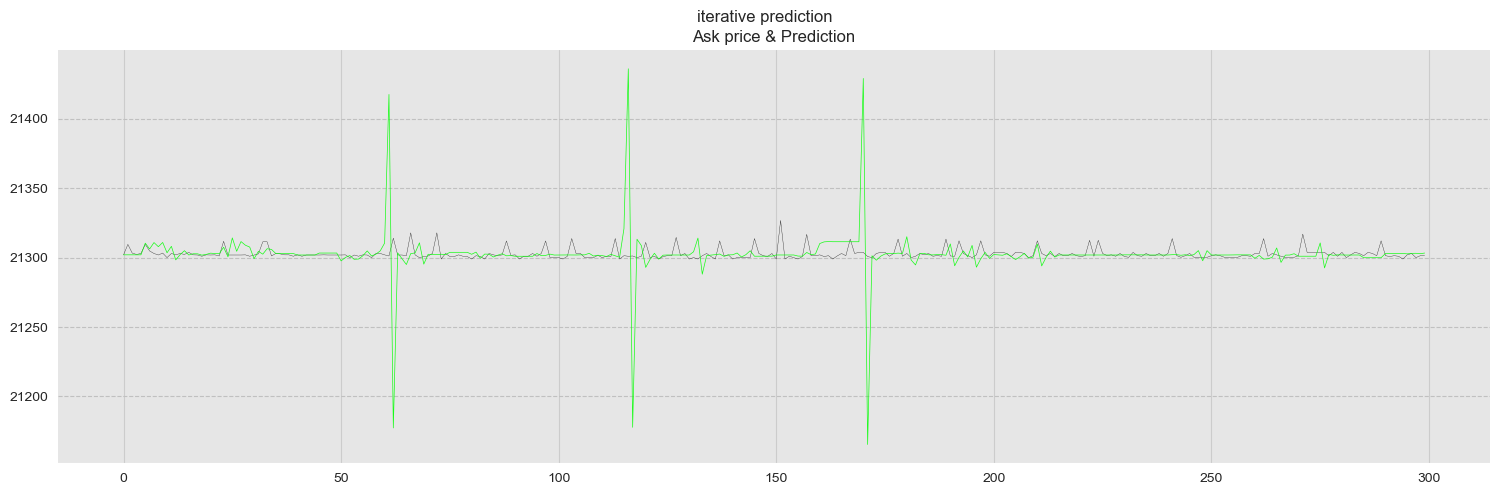

In [47]:
fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('iterative prediction')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('Ask price & Prediction')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, results_ahead.shape[0]), results_ahead.ask_price, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, results_ahead.shape[0]), results_ahead.ask_price_pred, '-', color="lime", alpha=0.9, linewidth=0.5)

plt.show()